### Inverse Modelling: Demonstration of parameterisation of structure and history matching
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


### 1. Project parameters

In [1]:
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

C:\Users\19904604\AppData\Local\Temp\ipykernel_26312\3209728366.py:21: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [2]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [(2000, 2000), (2500, 2000), (2000, 2500), (2500, 2500),] 
P.idpumpbores = ['P0','P1','P2','P3'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (1500, 3500), (4500,4500)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4', 'OB5'] 
P.nobs = len(P.xyobsbores)
P.nzobs = 3
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100      # Interior boundary
P.boundmaxtri = 50000 
P.modelmaxtri = 50000 # 10000 for ref
P.angle = 32   # minimum triangle angles

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 100000

#P.geo_bores = ['P1', 'P2', 'P3', 'P4']
#P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 5 # Number sublayers for conformable
P.geo_pl = 2 # Which geological layer pumping from (zero-based)

P.hk = [1.7, 0.07, 8.2, 0.05] 
P.vk = [0.12,0.003,0.51,0.005]
P.ss = [0.00009, 0.00007, 0.00002, 0.00008]
P.sy = [0.12, 0.1, 0.1, 0.1]

P.rch = 0.4/365 # 0.0027 m/d
P.strt = 0.

P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True

past_years = 2
P.nts_past = past_years * 6
P.tdis_past = [(past_years * 365, P.nts_past, 1.2)] # period length, number of timesteps, tsmult
P.qwell_past = -2000 #m3/d 

future_years = 5
P.nts_future = future_years * 6
P.tdis_future = [(future_years * 365, P.nts_future, 1.2)] # period length, number of timesteps, tsmult
P.qwell_future = -5000 #m3/d 

#P.zobs = [-50, -100, -200]
   
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(workspace, exist_ok=True)
    
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)

### 2. Meshing

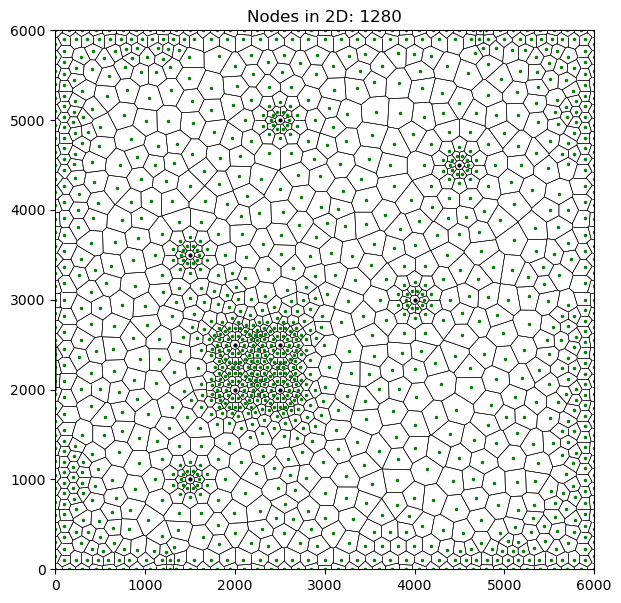

In [3]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)      
plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

P.nlv  = 30  
P.delx, P.dely = 40, 40
P.ncol, P.nrow = int((P.x1 - P.x0) / P.delx), int((P.y1 - P.y0) / P.dely)
P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False)    

### 3. Geological model (Reference)

In [4]:
P.control_points = ([])
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "inverse_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)     # Prepare geomodel inputs
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

C:\Users\19904604\Anaconda3\envs\loopenv\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
C:\Users\19904604\Anaconda3\envs\loopenv\lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


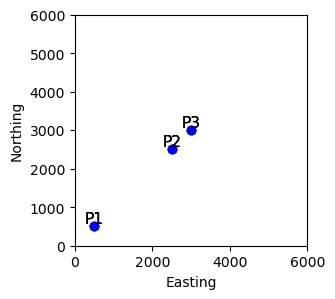

In [5]:
P.data
P.geomodel.feature_names()
plot_bores(P)

### 4. Flow model (Reference)

In [6]:
# Initiate REFERENCE
R = Model('ref', P, plan = 'vor', transect = 'con') 
R.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)

   Creating lithology and discretisation arrays for  ref  ...


In [7]:
P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_icpl, wel_coords = find_cell_disv(P.xypumpbores[n][0], P.xypumpbores[n][1], R.xcyc)
    if P.geo_pl == 0:
        wel_top = R.top[wel_icpl]  
    else:   
        wel_top = R.botm[(P.geo_pl)* P.nls-1, wel_icpl]
    wel_bot = R.botm[(P.geo_pl + 1) * P.nls-1, wel_icpl]   
    print(wel_coords, wel_top, wel_bot)
    P.wel_screens.append((wel_top, wel_bot))
    
P.zobs = np.zeros((P.nobs,P.nzobs))
for n in range(len(P.xyobsbores)):
    obs_icpl, obs_coords = find_cell_disv(P.xyobsbores[n][0], P.xyobsbores[n][1], R.xcyc) # Cell id in plan
    for m in range(3): # For the top three geological layers
        if m == 0:
            lay_top = R.top[obs_icpl]  
        else:   
            lay_top = R.botm[(m)* P.nls-1, obs_icpl]
        lay_bot = R.botm[(m + 1) * P.nls-1, obs_icpl]   
        obsz = lay_bot + (lay_top-lay_bot)/2
        P.zobs[n][m] = obsz
P.zobs

(2000.0, 2000.0) -186.0 -288.0
(2500.0, 2000.0) -164.0 -266.0
(2000.0, 2500.0) -164.0 -266.0
(2500.0, 2500.0) -148.0 -250.0


array([[ -25., -162., -326.],
       [ -25.,  -50., -101.],
       [ -25.,  -60., -121.],
       [ -25.,  -99., -199.],
       [ -25.,  -50.,  -73.]])

In [8]:
R.create_prop_arrays(P)         # Create property arrays (NPF)
R.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(R.modelname, ' has ', R.nnodes_div, ' nodes.')

   Creating property arrays for  ref  ...
   Adding flow packages to  ref  ...
   Time taken =  0.734168
ref  has  25600  nodes.


In [9]:
R.gwf, R.head_ss, R.obs_ss, R.runtime_ss = R.write_run_model(P, period = 'Steady', ic_array = P.strt)   # 3 hours to run!

   Writing simulation and gwf for  ref  ...
Period =  Steady 
   Model success =  True
   run_time =  23.807657


In [10]:
R.gwf, R.head_present, R.obs_present, R.runtime_past = R.write_run_model(P, period = 'Past', ic_array = R.head_ss)

   Writing simulation and gwf for  ref  ...
Period =  Past 
   Model success =  True
   run_time =  74.680099


In [11]:
R.gwf, R.head_future, R.obs_future, R.runtime_future = R.write_run_model(P, period = 'Future', ic_array = R.head_present)

   Writing simulation and gwf for  ref  ...
Period =  Future 
   Model success =  True
   run_time =  164.904335


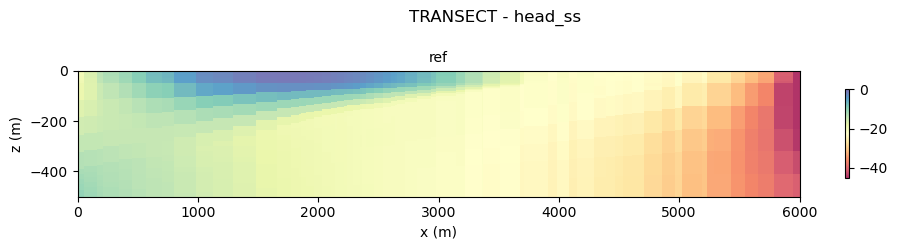

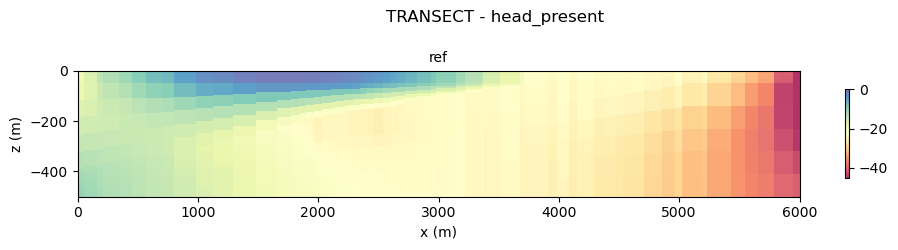

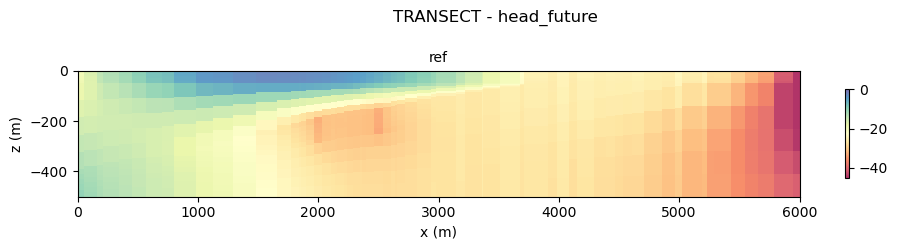

In [12]:
multiplot_prop_transect(P, models = [R], array = 'head_ss', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_present', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_future', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, 
                        vmin = -45, vmax = 0)

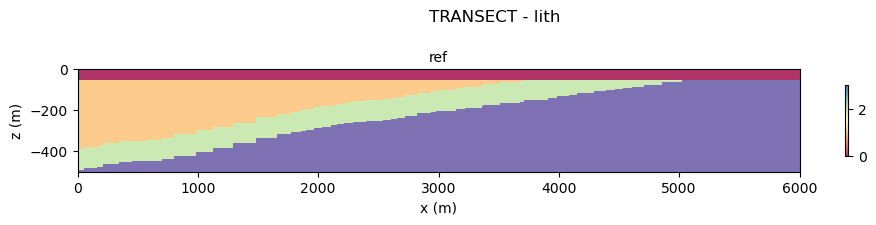

In [13]:
multiplot_vgrid_transect(P, models = [R], array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1) 

In [14]:
#f = os.path.join(vtk_workspace, "test", R.modelname)
#R.gwf.export(f, fmt="vtk")

In [15]:
#plot_flow_features(P, [R])
#multiplot_prop_transect(P, models = [R], array = 'logk11', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)

In [16]:
#y_ = [1000,1500,2000,2500,3000,4000,5000]
#for y in y_:
#    multiplot_prop_transect(P, models=[R], array ='head_future',X0=P.x0, Y0=y, X1=P.x1, Y1=y, vmin = -45, vmax = 0)

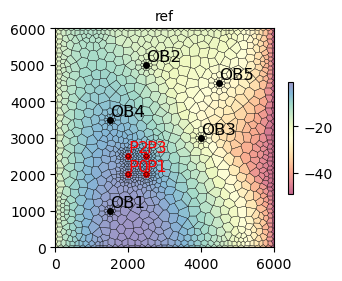

In [17]:
plot_bylayer(P, models = [R], layer = 1)#, vmin = -20, vmax = 5) 

In [18]:
#multiplot_prop_plan(P, models = [R], array = 'k11', layer = 3)#, vmin = None, vmax = None):   # array needs to be a string of a property eg. 'k11', 'logk11'  


### Testing convergence

In [19]:
loghk0, loghk1, loghk2, loghk3 = 0.044015243472100535, -1.3719587715817576, 0.8768808959774438, -1.0139391057981466
logvk0, logvk1, logvk2, logvk3 = -0.23941590413088842, -2.8420741462553125, -0.6046196768904785, -2.736295808069907
logss1, logss2, logss3 = -4.3882114206936365, -4.4574707130820475, -4.792126406159769
sy0 =  0.17280184660890327
cp =  -47.371110247370005

P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3]
P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3]
P.ss = [0.00009, 10**logss1, 10**logss2, 10**logss3]
P.sy = [sy0, 0.1, 0.1, 0.1]

In [20]:
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
# Initiate TEST
P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False)
T = Model('test', P, plan = 'vor', transect = 'con') 
T.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)
T.create_prop_arrays(P)         # Create property arrays (NPF)
T.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(T.modelname, ' has ', T.ncell_disu, ' nodes.')

T.gwf, T.head_ss, T.obs_ss, T.runtime_ss = T.write_run_model(P, period = 'Steady', ic_array = P.strt) 
T.gwf, T.head_present, T.obs_present, T.runtime_past = T.write_run_model(P, period = 'Past', ic_array = T.head_ss)
T.gwf, T.head_future, T.obs_future, T.runtime_future = T.write_run_model(P, period = 'Future', ic_array = T.head_present)

loop2flopy routines loaded!
   Creating lithology and discretisation arrays for  test  ...


C:\Users\19904604\Anaconda3\envs\loopenv\lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  test  ...
   Adding flow packages to  test  ...
   Time taken =  1.312597
test  has  20250  nodes.
   Writing simulation and gwf for  test  ...
Period =  Steady 
   Model success =  True
   run_time =  25.461555
   Writing simulation and gwf for  test  ...
Period =  Past 
   Model success =  True
   run_time =  61.565007
   Writing simulation and gwf for  test  ...
Period =  Future 
   Model success =  True
   run_time =  115.118794


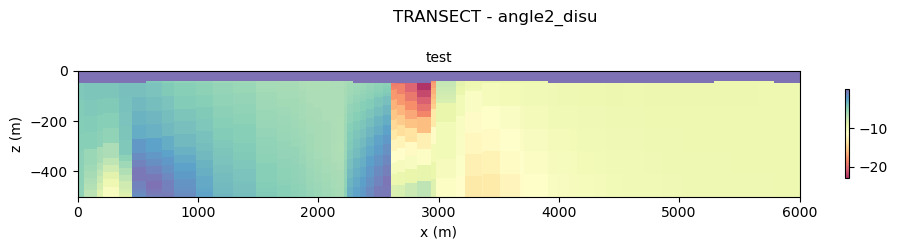

In [21]:
T.angle2_disu = T.gwf.npf.angle2.array

multiplot_prop_transect(P, models = [T], array = 'angle2_disu', X0=P.x0, Y0=P.y0, X1=P.x1, Y1=P.y1)

In [22]:
def plot_problem_cell(P, M, array, X, Y, Z, vmin = None, vmax = None): # array needs to be a string of a property eg. 'k11', 'angle2'
    fig = plt.figure(figsize = (10,3))
    
    a = getattr(M, array)
    ax = plt.subplot(121)
    ax.set_title("West-East Transect\nY = %i (%s)" %(Y, array))
    xsect = flopy.plot.PlotCrossSection(modelgrid=M.vgrid, line={"line": [(P.x0, Y),(P.x1, Y)]},geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Z, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    a = getattr(M, array)
    ax = plt.subplot(122)
    ax.set_title("South-North Transect\nX = %i (%s)" %(X, array))
    xsect = flopy.plot.PlotCrossSection(modelgrid=M.vgrid, line={"line": [(X, P.y0),(X, P.y1)]},geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(Y, Z, 'o', color = 'red')
    ax.set_xlabel('y (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    #ax.set_ylim([-51, -49])
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    plt.colorbar(csa, shrink = 0.7)
    plt.tight_layout()  
    plt.show()  
    
# grid = VC.gwf.modelgrid
# grid.intersect(999, 999, z=-200)

In [23]:
T.gwf.modelgrid.thick.min()
node = 6181-1
X = T.gwf.modelgrid.xyzcellcenters[0][node]
Y = T.gwf.modelgrid.xyzcellcenters[1][node]
Z = T.gwf.modelgrid.xyzcellcenters[2][0][node]
print(X,Y,Z)
print(T.gwf.modelgrid.thick[node])
#plot_problem_cell(P, T, array = 'lith', X=X, Y=Y, Z=Z)


5086.148237610827 3332.8415405136034 -45.0
10.0


### 14. Create "truth" observations and plot observations

In [24]:
R.ref_steady  = process_obs_steady(P, R)
R.ref_past    = process_obs_past(P, R)
R.ref_future  = process_obs_future(P, R)

In [25]:
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)
    
fname = '../results/ref_ss.pkl'
pickle.dump(R.ref_steady, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_past.pkl'
pickle.dump(R.ref_past, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_future.pkl'
pickle.dump(R.ref_future, open(os.path.join(P.workspace, fname),'wb'))

In [26]:
# Get times
csv_file = os.path.join(P.workspace, R.modelname + "_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365

csv_file = os.path.join(P.workspace, R.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2

Text(0, 0.5, 'Head (m)')

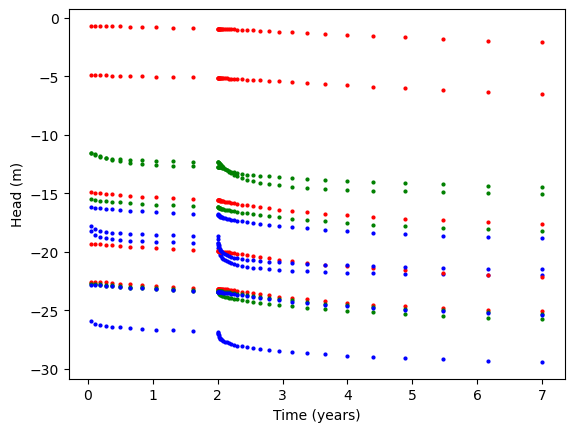

In [27]:
colors = ['red','green','blue']
R.ref_future.shape
for j in range(P.nobs):
    for i in range(P.nzobs):
        plt.plot(times_past, R.ref_past[j][i],'o', ms = 2, color = colors[i])
        plt.plot(times_future, R.ref_future[j][i],'o', ms = 2, color = colors[i])
plt.xlabel('Time (years)')
plt.ylabel('Head (m)')

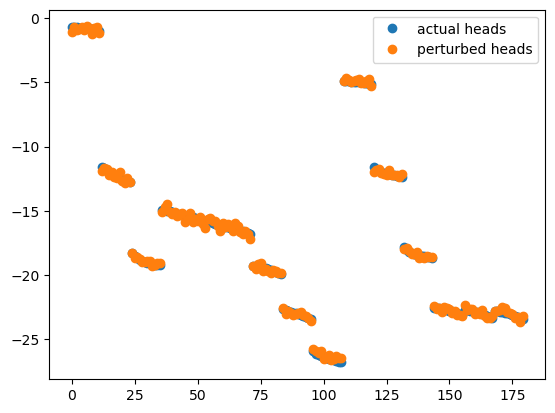

In [28]:
# CREATE SYNTHETIC OBSERVATIONS BY PERTURBING ACTUAL HEADS
err = 0.2
hobs_ref = np.copy(R.ref_past)    
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            hobs_ref[i][j][k] += np.random.normal(0.,err) # Perturb samples either side of measurement
plt.plot(R.ref_past.flatten(), 'o', label = 'actual heads')
plt.plot(hobs_ref.flatten(),'o', label = 'perturbed heads')
plt.legend()

### 15. Set up Markov Chain Monte Carlo (MCMC)

#### Define statistics of parameters

In [29]:
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
print(P.hk, P.vk)
print(logfunc(P.hk), logfunc(P.vk))

loop2flopy routines loaded!
[1.106662626480911, 0.04246598758192241, 7.531489864477075, 0.09684136319700516] [0.5762143846980817, 0.0014385529559306153, 0.2485308602749323, 0.0018352878602941036]
[ 0.044015 -1.371959  0.876881 -1.013939] [-0.239416 -2.842074 -0.60462  -2.736296]


In [30]:
#k_min = [-1, -3, -1, -3,   -3,  1, -2.5, -2]
#k_max = [1,   -1,  1,    -1, -0.5, -1, -0.5, -0.5]
#klist =[0.,-1.,0.69897,-1.,-1.,-2.,-0.30103,-2.] 
k_min = [0,-2,0,-2]
k_max = [1,-1,1,-1]
k_mean = [(k_max[i] - k_min[i])/2 + k_min[i] for i in range(4)]
"""plt.plot(np.linspace(0,7,8), k_min, 'o', color = 'blue')
plt.plot(np.linspace(0,7,8), k_max, 'o', color = 'blue')
plt.plot(np.linspace(0,7,8), k_mean, 'o', color = 'orange')
plt.plot(np.linspace(0,7,8), logfunc(P.hk + P.vk), 'o', color = 'red')"""

"plt.plot(np.linspace(0,7,8), k_min, 'o', color = 'blue')\nplt.plot(np.linspace(0,7,8), k_max, 'o', color = 'blue')\nplt.plot(np.linspace(0,7,8), k_mean, 'o', color = 'orange')\nplt.plot(np.linspace(0,7,8), logfunc(P.hk + P.vk), 'o', color = 'red')"

In [31]:
def Likelihood(obs, mod, err):
    return(np.sum(-(obs-mod)**2/(2*err**2)))

#from DREAM import *
%run ../../Lab_tools/Uncertainty_tools/DREAM.py

Unif = [] # True = Uniform, False = Normal
Log = []  # ?? Just put False
Mean = []
Width = []  # for uniform distributon the range,  for normal, the standard deviation
Min = []
Max = []

###K values
for i in range(len(P.hk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i])
    Width.append(k_mean[i] - k_min[i])
    Min.append(k_min[i]) 
    Max.append(k_max[i]) 

#make this anisotropy
for i in range(len(P.vk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i]-1)
    Width.append(0.5)
    Min.append(k_min[i]-1) 
    Max.append(k_max[i]-1)
    
for i in range(3): # 1e-4 to 1e-6 # Botom 3 layers
    Unif.append(True) # True if uniform, False if normal
    Log.append(True) # Ignore
    Mean.append(-4.5)
    Width.append(0.5)
    Min.append(-5) 
    Max.append(-4)
    
#Sy top geo layer #0.05 - 0.2
Unif.append(True)
Log.append(False)
Mean.append(0.125)
Width.append(0.125/2)
Min.append(0.05)
Max.append(0.2)

#Control points z value
Unif.append(True)
Log.append(False)
Mean.append(-125)
Width.append(125)
Min.append(-250)
Max.append(0)

#### Set up DREAM and define "run model" function

In [32]:
## DREAM for Steady State
err = 0.2
nchains = 5     #number of parallel chains 
npars = len(Mean)  #number of parameters
nburn = 50 
minsamp = 50 # minimum number of samples

D = DREAM(nchains, npars, nburn = nburn, npairs = 1) #nburn is burn in perion, npairs defines how you sample
D.par_set(Log,Unif,Mean,Width,Min,Max) #initialise the class
D.set_CR(ncr=3)  #crossover testing thingy. Use 3
D.k = 1  # Number of things to try each chain. Numbers other than 1 can give weird results for some models

In [33]:
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
    
# Include this here when ignoring structural parameters
#P.control_points = (['CP1', 'control', 3000, 3000, -100, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
#P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
#P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

In [34]:
def update_model(P, loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, 
                 logss1, logss2, logss3, sy0, cp):
    print(loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, 
                 logss1, logss2, logss3, sy0, cp)
    del P.hk
    del P.vk
    del P.ss
    del P.sy
    P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3] #[1, 0.1, 10, 0.1] 
    P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3] #[i/10 for i in P.hk]
    P.ss = [0.00005, 10**logss1, 10**logss2, 10**logss3]
    P.sy = [sy0, 0.1, 0.1,0.1]#[sy0, 0.1, 0.1, 0.1]
    P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = Model('run', P, plan = 'vor', transect = 'con') # Create flow model 
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady', ic_array = P.strt)
    M.gwf, M.head_past, M.obs_past, M.runtime_past = M.write_run_model(P, period = 'Past', ic_array = M.head_ss)   
    #hobs_steady = process_obs_steady(P, M)
    hobs_past = process_obs_past(P, M)
    return(hobs_past, M)


In [35]:
#this function and argument statement are for the labtools dream implementation.

def L_func(Prop, P, hobs_ref, err):
    hmod, M = update_model(P,
                        Prop[0],
                        Prop[1],
                        Prop[2],
                        Prop[3],
                        Prop[4],
                        Prop[5],
                        Prop[6],
                        Prop[7],
                        Prop[8],
                        Prop[9],
                        Prop[10],
                        Prop[11],
                        Prop[12],
                        ) 
    a = np.array(hobs_ref) 
    b = np.array(hmod)
    P.hmod = hmod
    P.M = M
    return(Likelihood(a,b,err))
    
    
args = (P, hobs_ref, err,) # P - project object, hobs_ref - real observations, err - 
    
def result_func(Prop,P):
    M = P.M
    hpred = run_prediction(M, ic_array = M.head_past)
    overall = np.append(P.hmod,hpred,axis=2)
    #print(overall)
    return(overall)

Rfunc_args = (P,)
    

In [47]:
a = 5
b = a // 2
b

2

In [36]:
def run_prediction(M, ic_array):
    M.gwf, M.head_future, M.obs_future, M.runtime_future = M.write_run_model(P, period = 'Future', ic_array = ic_array)   
    hpred = process_obs_future(P, M)
    return hpred

In [37]:
results = Dream_ZS(D,       # DREAM class being used.
                   L_func,  # function that recieves the proposed pars, places in model, runs model & returns Likelihood 
                   args,    # contains all the args for the model outside of the parameters
                   result_func = result_func,      # save the model outputs
                   result_func_args = Rfunc_args,  
                   minsamp = minsamp,         
                   print_freq = 1,
                   Test = False,      # If True, only initial likelihoods obtained
                   lookback = 10,
                   R_overide = True)  # Stops even if R=1.2 not reached

0.1557620289273829 -1.973431090273495 0.0137155524926873 -1.3524122753429855 -0.779425641641918 -2.801665994864863 -0.880780360345497 -2.52998013834069 -4.814702409656503 -4.76268867950108 -4.781458249681478 0.10178019358280196 -55.882745837381265
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.793044
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.772843
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  60.676576
Initial Likelihood for chain  0  =  -425891.80891818344
0.4454251708157524 -1.6547509347024563 0.27814895460762157 -1.3969582982415316 -0.8459721289441365 -2.6460214893928926 -0.1300559464692651 -2.233297518493755 -4.538979111817014 -4.216176495646309 -4.52034035189854 0.13370566752804053 -4.713093344238814
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.868633
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.019926
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  63.757025
Initial Likelihood for chain  1  =  -133965.15588437207
0.7071847298358295 -1.2914207018399453 0.02425892778952987 -1.4999350622635395 -0.8114166833417381 -2.158096759046618 -0.05518132952535848 -2.03094171133258 -4.407405346311509 -4.270371105814149 -4.749314958262163 0.11319218716366997 -207.463764343567
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755803
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.754397
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  78.005278
Initial Likelihood for chain  2  =  -29336.347264088472
0.8039071857759916 -1.1338143119317907 0.5610432643436115 -1.0093205618468872 -0.8878354692531284 -2.2091402812927536 -0.34206990764871115 -2.993184155071786 -4.039043632891174 -4.083236709125634 -4.354447114651994 0.10348979557952731 -79.14166767542238
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.502962
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.292363
Initial Likelihood for chain  3  =  -17722.726074409307
0.27655540083446806 -1.2843214719398302 0.6066862806637292 -1.6625729045440252 -0.12204554933015643 -2.6680121268977106 -0.32375540096409616 -2.151749899015307 -4.45563564442945 -4.430838986308656 -4.728869928746124 0.14604967373413985 -246.92805571765555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757203
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.510675
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.749996
Initial Likelihood for chain  4  =  -24786.23299097867
0.15576251017426193 -1.9734084239461795 0.013734747961559624 -1.5334400079807629 -0.7793729776143553 -2.801577351801095 -0.7816884438305202 -2.5299214530371286 -4.048066396018853 -4.76273291587753 -4.781474389731205 0.10178445624929308 -55.90812786089177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.7357
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.547148
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.730504
0.44524153053071913 -1.6545151715711643 0.27812406977289245 -1.3969463687405737 -0.8459166281743884 -2.6458862476791993 -0.13010636089389313 -2.2333382237046617 -4.539052820248233 -4.216188163701946 -4.5203395298579805 0.13370989554133056 -4.71147561942504
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820065
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.367542
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.533514
0.46103373353471694 -1.3617584090013837 0.045581789143153244 -1.8048879235667696 -0.4540666117730777 -2.372238938514292 -0.04675149157885313 -2.6380437684742812 -4.601905423047595 -4.432493014556514 -4.924067837491806 0.13304507397573384 -35.211814596726526
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.72423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.243534
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  63.317841
0.8038923759884982 -1.133823953270123 0.561136011513561 -1.0093709772757733 -0.887925254129045 -2.2092484012883706 -0.34199728654826544 -2.9930935995395043 -4.039120746140697 -4.083151659606056 -4.354415281968168 0.10349055850519996 -79.12456948325378
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.784275
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.271417
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  63.430681
0.2766013667007296 -1.2840777829148502 0.6068331293118558 -1.6626503834872075 -0.1221357898627196 -2.6678930866032644 -0.3236444021278884 -2.151666946599902 -4.455618596119848 -4.430716480518686 -4.728826245448315 0.14605072369372848 -246.92666651734322
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.732292
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.068899
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.504689
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  1
sampled =   1.0  tried =  5.0
Currenty sampling at a rate of  20.0 %
Current Likelihood for chain  0  =  -425891.80891818344
Current Likelihood for chain  1  =  -133965.15588437207
Current Likelihood for chain  2  =  -29336.347264088472
Current Likelihood for chain  3  =  -17722.726074409307
Current Likelihood for chain  4  =  -24767.546566815858
1
0.09944799207558058 -1.2951323872315137 0.7371161710842247 -1.3525668932060855 -0.08612880144074997 -2.863938032213017 -0.8807558225879385 -2.7066198398747066 -4.814843212569936 -4.762606500193393 -4.805922060505277 0.1017838254413125 -218.7338750185454
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.851706
   Writing simulation and gwf for  run  ...
Period =  Stead

Period =  Past 
   Model success =  True
   run_time =  74.656494
0.44560564067934805 -1.654640205897645 0.14597441173455203 -1.5780093895939673 -0.8459061761181553 -2.646085916879656 -0.13037718780473656 -2.233338775254695 -4.772528801500138 -4.216168109683152 -4.520354125674022 0.13370859872033994 -4.668836585503402
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.735789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.762163
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  61.413702
0.6283109935487837 -1.118600883167234 0.177694785237797 -1.62387134899418 -0.4736394190515927 -2.1684320539494593 -0.14559269128308616 -2.9929262222016204 -4.368630259400408 -4.370585425794754 -4.846691662252092 0.11895556959869803 -75.1905621993069
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.264105
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.336578
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  56.820086
0.8037658356942093 -1.1339704527914969 0.2844042048457706 -1.8645571008310826 -0.8877972856218922 -2.20897126305541 -0.6022238093946721 -2.9932028323927318 -4.039176454544209 -4.238277596263826 -4.354518990048664 0.10348414691248885 -238.24734454449165
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.727385
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.404999
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.206338
0.2765983330780989 -1.284214188591507 0.6065413715208913 -1.6626694430245736 -0.12193497928471952 -2.6678922554962003 -0.32368704807771154 -2.1515811814472703 -4.455536988034515 -4.430674786026101 -4.728835555974482 0.14605333431234022 -246.92761315415905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.779166
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.20145
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.807846
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  2
sampled =   3.0  tried =  10.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -18090.043549262853
Current Likelihood for chain  1  =  -133965.15588437207
Current Likelihood for chain  2  =  -29336.347264088472
Current Likelihood for chain  3  =  -8758.616637950961
Current Likelihood for chain  4  =  -24767.546566815858
2
0.01671875611805695 -1.3001857180348548 0.7979173748074662 -1.3525536232157715 -0.06944425693738603 -2.9553060780019806 -0.14079969108798296 -2.965626905500325 -4.815116600097926 -4.917585625860431 -4.805988992915828 0.10178330391788191 -205.13246617055765
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745611
   Writing simulation and gwf for  run  ...
Period =  St

Period =  Past 
   Model success =  True
   run_time =  71.940673
0.44536243921917495 -1.6547039112602933 0.2781600607594815 -1.3971503836832846 -0.8459742194115677 -2.6460361755406123 -0.12996165068600585 -2.233182827563401 -4.538891030959454 -4.216225092766623 -4.520283972242326 0.1337170061308711 -4.698135880718024
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.895801
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.721307
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.485137
0.37840432191954937 -1.366519563666648 0.10640828337947407 -1.660100620476247 -0.4373238445739372 -2.4637196797517644 -0.3065737132888346 -2.897398862796374 -4.769314174089417 -4.587499119602857 -4.959910975869496 0.1123929261618719 -23.621753483380076
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.931421
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.77082
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.455852
0.7248405655738446 -1.9610662194644677 0.4377759579417386 -1.9888501657497237 -0.5498485409573097 -2.219265306314304 -0.6926859817030768 -2.955420190078718 -4.00034539451708 -4.338449867846876 -4.451771117751199 0.10925095575602606 -106.12667023923615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746178
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.089001
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.798933
0.533878690145462 -1.9656265813634577 0.6065847393603675 -1.7314299829423514 -0.13709466940388693 -2.3673088023387923 -0.9381737195410402 -2.1517057965136246 -4.455395238875968 -4.430625951126252 -4.713657728281829 0.14605684982073272 -71.10122233392485
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.738252
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.652285
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  51.863555
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  3
sampled =   3.0  tried =  15.0
Currenty sampling at a rate of  20.0 %
Current Likelihood for chain  0  =  -18090.043549262853
Current Likelihood for chain  1  =  -133965.15588437207
Current Likelihood for chain  2  =  -29336.347264088472
Current Likelihood for chain  3  =  -8758.616637950961
Current Likelihood for chain  4  =  -24767.546566815858
3
0.09960954248841158 -1.2951608425432384 0.7373253583360128 -1.3525516647231546 -0.0859031465779594 -2.8642395839133767 -0.8807745115165111 -2.7065951630508756 -4.814988733361653 -4.76267430912401 -4.806024407045821 0.1017838378988215 -218.76587472441216
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754797
   Writing simulation and gwf for  run  ...
Period =  Stead

Period =  Past 
   Model success =  True
   run_time =  73.384206
0.16185668956720933 -1.656210163010102 0.27808927363989433 -1.3283325018490904 -0.8457162507268137 -2.6461200579570465 -0.1303192549219485 -2.5488089299148395 -4.729164069238822 -4.216173255478306 -4.546657222588808 0.1283689835824884 -9.710256161112822
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.741326
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.831956
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.995824
0.9644857211171154 -1.9730015108528371 0.02910650810558047 -1.5686643919664578 -0.8264967205694564 -2.8577095678195477 -0.6696643699655289 -2.798384146045872 -4.217180044012349 -4.040669602319524 -4.734266775151615 0.11852357608857346 -26.6591013970513
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.738269
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.347608
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  50.320251
0.8037844012101596 -1.13356827443657 0.2846860996191793 -1.8644131421493875 -0.9027253776468099 -2.9086790383215666 -0.2168932413519321 -2.992784117275875 -4.039175936403526 -4.238105095034385 -4.3393646764765 0.10881664724328358 -59.806851029809366
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.883313
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.497132
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  59.548686
0.2766733593069551 -1.8926564810867195 0.725985943954293 -1.800812464403955 -0.15058037428346352 -2.3647634693975106 -0.3236264785601257 -2.1516374066856763 -4.372809469814988 -4.52278487324751 -4.728740263816744 0.13904336826884933 -247.05307809705582
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.777671
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.252815
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.496834
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  4
sampled =   6.0  tried =  20.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -18044.238996699598
Current Likelihood for chain  1  =  -133965.15588437207
Current Likelihood for chain  2  =  -15893.046155669592
Current Likelihood for chain  3  =  -8758.616637950961
Current Likelihood for chain  4  =  -10676.28141663385
4
0.741184197913198 -1.8158683620105243 0.7309870225532463 -1.8849393092507154 -0.0441594143624755 -2.8642872284527705 -0.8806772077912407 -2.7063939037956275 -4.814844265150695 -4.740466938810769 -4.971848669165264 0.13201037737003185 -218.89470461177845
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.738388
   Writing simulation and gwf for  run  ...
Period =  Steady

Period =  Past 
   Model success =  True
   run_time =  64.277206
0.6059149329558429 -1.4936806219598462 0.022978082326436226 -1.1009146765720033 -0.7850081709564389 -2.294722881957359 -0.1968854390742831 -2.038373850255563 -4.717075582997451 -4.018466301831975 -4.900074291373633 0.14875909239270796 -51.96470507292486
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.738936
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.411263
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  53.635877
0.13353108052389184 -1.343592900821895 0.7002727265447839 -1.302731470364729 -0.5503104695281607 -2.836052224690515 -0.47600654668792247 -2.879995187371328 -4.300483003354709 -4.826140299586676 -4.525614686063536 0.10618342171054124 -49.1288975654403
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.725601
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.641427
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.273236
0.8037113142340006 -1.1341989162877875 0.2843333072358804 -1.3970650899452435 -0.8878341101806662 -2.208950290713037 -0.6024607187226526 -2.2333938908934865 -4.539110979094089 -4.215988952611284 -4.354636975601904 0.13370884480363018 -14.295554434049109
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752934
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.748781
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  59.18708
0.4457029157429775 -1.263427011206519 0.39729294773798973 -1.5351684029806545 -0.8744583446021649 -2.3425409513509137 -0.12997086446129125 -2.2329609775458903 -4.4564038583788514 -4.307956945825076 -4.5204422958211925 0.12671010682109055 -20.152754305870115
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.766814
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.399141
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  63.49143
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  5
sampled =   8.0  tried =  25.0
Currenty sampling at a rate of  32.0 %
Current Likelihood for chain  0  =  -6107.183139059503
Current Likelihood for chain  1  =  -62546.75741832999
Current Likelihood for chain  2  =  -15893.046155669592
Current Likelihood for chain  3  =  -8758.616637950961
Current Likelihood for chain  4  =  -10676.28141663385
5
0.8948991183541469 -1.9138895097857835 0.45829072601829607 -1.6227739536023995 -0.35345705749236905 -2.689731055226331 -0.8215558569973311 -2.653405873380154 -4.936949217221109 -4.548083227384652 -4.05183782410673 0.1332792478429198 -128.95217716424995
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74798
   Writing simulation and gwf for  run  ...
Period =  Steady 
   

Period =  Past 
   Model success =  True
   run_time =  52.985311
0.46776652802608065 -1.4181223913019294 0.811614240103714 -1.873152221975134 -0.1592203752831618 -2.193142080380323 -0.846476803090915 -2.8176442649741125 -4.58807856103392 -4.773706581703445 -4.689255256564276 0.14954158276548127 -207.6777298653306
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.735404
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.031442
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.884421
0.661924148334037 -1.3652067341731478 0.02895354347905856 -1.5683698200964333 -0.8268473126917184 -2.85774051013002 -0.6694511699128577 -2.582263498030189 -4.217253726924743 -4.040736794132372 -4.933401079210914 0.1185071343927312 -26.765747947072516
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.865849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.278756
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  51.987473
0.04959178411958032 -1.133710491586311 0.1340652408348149 -1.9587999506972416 -0.24541902959509154 -2.995095119405536 -0.7326266928088252 -2.9936738126127045 -4.8447283124776375 -4.148378898401944 -4.3544820701051155 0.08361034651681765 -234.48704686078722
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753052
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.90336
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.17156
0.36571292593909144 -1.8926775970064862 0.8211332303996898 -1.8987626489664544 -0.1677480424435197 -2.1433530778704952 -0.32319195389043615 -2.1512921929581132 -4.434589244127532 -4.682899173027983 -4.710183421711436 0.13902720661161816 -229.25822685131385
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.724725
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.461354
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.666709
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  6
sampled =   10.0  tried =  30.0
Currenty sampling at a rate of  33.3 %
Current Likelihood for chain  0  =  -6107.183139059503
Current Likelihood for chain  1  =  -6212.291474566592
Current Likelihood for chain  2  =  -15893.046155669592
Current Likelihood for chain  3  =  -8758.616637950961
Current Likelihood for chain  4  =  -6351.23678146577
6
Minimum likelihood for outlier chains is:  -29209.93872385312
Removing chain 1with average lilihood of -67574.73492575622compared to interquartile minimum of -29209.93872385312
0.7411842428779716 -1.8158683871168793 0.7310944308799743 -1.8848314628307614 -0.04415942926232015 -2.8642873132815323 -0.8806154371416283 -2.706393896829561 -4.8148441767515315 -4.74042764467703 -4.971848682333316 0.1320103776228777 -218.87013097945194
   Creating lithology and discretisation arrays for 

Period =  Past 
   Model success =  True
   run_time =  64.503288
0.803766402943897 -1.1339146520194112 0.2845596553924104 -1.4653887272618473 -0.8876216975098079 -2.208995551316698 -0.6021998471847161 -2.99319958697903 -4.039118619494337 -4.165974497106004 -4.354497320335671 0.10348736114367976 -238.2654275711979
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.726071
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.043966
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.858346
0.9644714616680907 -1.973027132476828 0.029003326594376905 -1.568212896314184 -0.8264268641557756 -2.857646710013633 -0.6697784037519781 -2.7983755210089964 -4.2170563784838695 -4.0406944587509175 -4.734311591680959 0.11851612298420643 -26.698126372574453
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.732059
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.019538
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  52.777435
0.8036909347597115 -1.13426714472425 0.1554116971212643 -1.2636614354699525 -0.8879141396822768 -2.2088865861564813 -0.6024322196515818 -2.9932483266117473 -4.039112169686172 -4.23836700757896 -4.3546916891606475 0.1034848214133492 -62.23932871432862
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.877579
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.609611
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.379649
0.3656854880424365 -1.8926406256358304 0.6920804247534814 -1.29825133091046 -0.16779240893884068 -2.143315849268664 -0.4446450131542099 -2.15133421475613 -4.4348078051741195 -4.755131584321718 -4.710173505731347 0.13902083751325647 -54.92912677402808
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.768082
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.776596
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  58.595883
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  7
sampled =   12.0  tried =  35.0
Currenty sampling at a rate of  34.3 %
Current Likelihood for chain  0  =  -6099.081629854383
Current Likelihood for chain  1  =  -8758.616637950961
Current Likelihood for chain  2  =  -15891.807374754762
Current Likelihood for chain  3  =  -8758.616637950961
Current Likelihood for chain  4  =  -6351.23678146577
0
0.7410746536315224 -1.8158560355699669 0.7310890232108718 -1.8849374379283834 -0.044367247269084614 -2.8643832251407284 -0.8807582132677539 -2.70625670840713 -4.814928066562205 -4.740381767815199 -4.971838543262816 0.13200958348828118 -218.87392806933923
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736248
   Writing simulation and gwf for  run  ...
Period =  Steady 

Period =  Past 
   Model success =  True
   run_time =  61.763374
0.8037021600283792 -1.1338737186832641 0.2843278334882428 -1.26341287364705 -0.8879221344242688 -2.2088713135062408 -0.6023263487180185 -2.993366082563198 -4.03931146518484 -4.31080060059605 -4.354358850885646 0.10348135086885842 -238.1420513474305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.010504
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.101852
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.863499
0.9645676011044093 -1.9730513832390044 0.029045896531517783 -1.5680128152566024 -0.8265765719088384 -2.8573954371396395 -0.5483967700085345 -2.7984762185359444 -4.217015484813884 -4.968620151061659 -4.734031331863029 0.1185259366823909 -26.710921527008285
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.850112
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.776624
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  52.965317
0.8037133910946952 -1.1339009987683644 0.2842905770484416 -1.864597663575895 -0.8878974857437433 -2.2089474572462944 -0.6021261076096186 -2.993109416452853 -4.039237079316816 -4.238020474675215 -4.354343718114599 0.1034780839612963 -238.24701122349578
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.593789
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.372811
0.3656632973317558 -1.8928559277305919 0.8210286417333551 -1.8985720555503323 -0.16783489725070683 -2.1432155954160046 -0.32328544128675923 -2.1512507753816394 -4.434402024512975 -4.683246857443121 -4.7102205748357795 0.13902621473358706 -229.17060418695795
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.738299
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.180324
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.571158
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  8
sampled =   16.0  tried =  40.0
Currenty sampling at a rate of  40.0 %
Current Likelihood for chain  0  =  -6095.51797677033
Current Likelihood for chain  1  =  -8758.616637950961
Current Likelihood for chain  2  =  -15673.011391457552
Current Likelihood for chain  3  =  -8756.762546180453
Current Likelihood for chain  4  =  -6285.014636510938
1
0.7410286847977586 -1.8159046291418537 0.8602751473045477 -1.8851244032719796 -0.04439203934849996 -2.864441143233807 -0.8807045598410802 -2.7061758246965826 -4.814811800227531 -4.740104472564363 -4.971868481280924 0.13200551144921438 -144.27331907971404
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.898783
   Writing simulation and gwf for  run  ...
Period =  Steady 

Period =  Past 
   Model success =  True
   run_time =  58.446367
0.8037859351696212 -1.1339082120944146 0.28463756977559723 -1.864754908310763 -0.8879533288618381 -2.208973941620413 -0.6021568126779777 -2.9932770600728063 -4.03916232866156 -4.238305761093352 -4.354531978917068 0.10348978581028018 -238.25606390843467
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.882139
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.469253
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.771989
0.9645137270458704 -1.9730281419678615 0.029171723508300006 -1.5679272171547263 -0.826647734166363 -2.857296396064102 -0.5483989337612606 -2.7986616871207572 -4.217209442692959 -4.968770901087251 -4.733878372259239 0.11852954681610987 -26.63557241186967
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756292
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.315974
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  52.50797
0.8036662495008117 -1.1337663418698725 0.28414171883134465 -1.8642680173796953 -0.8879771599853407 -2.2088975285640666 -0.5770129772075139 -2.9930218826060098 -4.039439188361693 -4.579059527404266 -4.354122571989202 0.10346460823391405 -238.12346666347298
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757636
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.389718
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.534009
0.29047112228513866 -1.8928631714316533 0.821389563044846 -1.037132315466578 -0.1964055361410289 -2.8404143958633523 -0.3483620203101533 -2.1511685228047996 -4.351463909187795 -4.683219700450198 -4.532949051719099 0.13200886167013876 -229.22149972608008
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.826747
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  33.574412
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.86271
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  9
sampled =   16.0  tried =  45.0
Currenty sampling at a rate of  35.6 %
Current Likelihood for chain  0  =  -6095.51797677033
Current Likelihood for chain  1  =  -8758.616637950961
Current Likelihood for chain  2  =  -15673.011391457552
Current Likelihood for chain  3  =  -8756.762546180453
Current Likelihood for chain  4  =  -6285.014636510938
2
0.7410665330982816 -1.8150099761134302 0.6016773926016913 -1.2848384795067367 -0.04437795574118769 -2.864263884529966 -0.0022883590761642036 -2.7059573710014964 -4.814763345768539 -4.812706131156025 -4.971666724321701 0.1320069116525025 -45.34386186576518
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.806603
   Writing simulation and gwf for  run  ...
Period =  Steady 

Period =  Past 
   Model success =  True
   run_time =  64.700065
0.8036519035665806 -1.1338310676131433 0.2845299250245309 -1.8642788493834521 -0.8873202476765215 -2.20889609119375 -0.6021057928008866 -2.993481126426381 -4.038997427877132 -4.238117646419732 -4.354604016374413 0.10349037308387662 -238.24778924359023
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.848991
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.08721
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  79.626228
0.9645009329409162 -1.97339066513326 0.9001824748302035 -1.9669933523174932 -0.8267896928553282 -2.8576291644960294 -0.6696315458325425 -2.798349746600934 -4.217117807045391 -4.040763668704484 -4.734052737677576 0.11852017693157581 -97.11052297352762
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.82742
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.202083
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  54.457991
0.832967218599901 -1.8153766812651315 0.07561807884044824 -1.854844381382142 -0.28138075426633335 -2.902717054281563 -0.47230498099437745 -2.1270580532042227 -4.677080784134431 -4.003655653068488 -4.066110045888359 0.0901768741563024 -246.94546537344746
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.964742
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  30.488933
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  69.325559
0.4407561023267444 -1.8926404927000011 0.7018713655771466 -1.7600273679216543 -0.13924476154319937 -2.1433736324938684 -0.29801029360998416 -2.0605699311642285 -4.434409190316536 -4.023906438395554 -4.710420419193809 0.14606124130352893 -134.98667989449208
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.730169
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.05276
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  53.177729
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  10
sampled =   18.0  tried =  50.0
Currenty sampling at a rate of  36.0 %
Current Likelihood for chain  0  =  -6095.51797677033
Current Likelihood for chain  1  =  -8758.303818400018
Current Likelihood for chain  2  =  -14370.812871441809
Current Likelihood for chain  3  =  -8756.762546180453
Current Likelihood for chain  4  =  -6285.014636510938
3
0.8035680111011951 -1.1341052758852082 0.284210092755931 -1.8648633219245125 -0.8881720596475853 -2.209085739940033 -0.6022136824455202 -2.9934429761239962 -4.039136452780059 -4.238108474884747 -4.3544593419916025 0.10349041746732601 -238.59906402506743
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.796313
   Writing simulation and gwf for  run  ...
Period =  Steady 

Period =  Past 
   Model success =  True
   run_time =  70.648297
0.8036030657310348 -1.1339650070751408 0.2842564930259421 -1.7961440878412227 -0.22847230532171786 -2.2089608668987237 -0.6020370476498774 -2.993423863837789 -4.03889710087173 -4.238171497765201 -4.33047049418135 0.10348841206160757 -128.08471427994232
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.837879
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.724326
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.172734
0.027106583998718348 -1.2910665192912731 0.453326664816726 -1.9464426478232888 -0.6705521418705995 -2.202091293530994 -0.3909777016720444 -2.0850659732717194 -4.441525079915676 -4.5384545070951265 -4.117080810966971 0.08999375549634546 -115.70800793709839
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.859623
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.02604
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  56.971489
0.8662270656813361 -1.451546038302981 0.8377255182801697 -1.8442981134496452 -0.7312234012435515 -2.554285229228572 -0.3235147808033709 -2.2805810750009927 -4.2633454086264395 -4.735577337228787 -4.737206033838806 0.07494564270682166 -7.817895560163663
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737816
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.389237
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  56.267141
0.36573442554487906 -1.89289391371617 0.3743060753193048 -1.8782126893572262 -0.01149345604127272 -2.4883930448747362 -0.04508910592965209 -2.4381093006010106 -4.434320362164036 -4.1811946080484566 -4.093019290204434 0.11049855844962345 -247.60613329488024
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.735437
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.989256
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.555581
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  11
sampled =   18.0  tried =  55.0
Currenty sampling at a rate of  32.7 %
Current Likelihood for chain  0  =  -6095.51797677033
Current Likelihood for chain  1  =  -8758.303818400018
Current Likelihood for chain  2  =  -14370.812871441809
Current Likelihood for chain  3  =  -8756.762546180453
Current Likelihood for chain  4  =  -6285.014636510938
4
0.6661722932073599 -1.4239758979123953 0.4434466605570591 -1.8371568203489408 -0.07317049273814383 -2.5612268154142317 -0.8491275230011632 -2.7973048450145104 -4.731809774758823 -4.8323917408143 -4.794770948471436 0.12497248568799543 -37.13433094427046
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.7377
   Writing simulation and gwf for  run  ...
Period =  Steady 
  

Period =  Past 
   Model success =  True
   run_time =  51.706919
0.8037093285497581 -1.1339165016030068 0.2842619886578203 -1.8641589025257033 -0.887361199158048 -2.209031524949486 -0.6021081598260164 -2.99333316986328 -4.0390583480433255 -4.238101141551177 -4.35457041684274 0.10349831985296522 -238.36489832814416
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.856924
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.966016
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.499761
0.889380906871163 -1.9735351591182524 0.9002665053303763 -1.9664698789402406 -0.8554064792868901 -2.5550837064788436 -0.6696213739956636 -2.7984284187813024 -4.133820023007102 -4.132904716965638 -4.733895962776033 0.11851008002808665 -97.17640758642322
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.715746
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.243355
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  50.586199
0.8037367398019664 -1.1339331477245609 0.2840709706035784 -1.8648111893838142 -0.888175959250826 -2.208726508101034 -0.6021415660884945 -2.9929052881847262 -4.038950523805751 -4.2381441079663205 -4.354354432515975 0.1034552914558215 -238.31751148609928
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.71801
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.012182
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.270836
0.36561266483619825 -1.892466255115002 0.8208116323512522 -1.8985064864874726 -0.5614599289473577 -2.1428669188348 -0.19333047819225319 -2.15142030351275 -4.072561594458391 -4.68305461143954 -4.709821494943237 0.1390329854076937 -229.11312587367453
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.742597
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.415485
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.510419
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  12
sampled =   19.0  tried =  60.0
Currenty sampling at a rate of  31.7 %
Current Likelihood for chain  0  =  -6095.51797677033
Current Likelihood for chain  1  =  -8758.303818400018
Current Likelihood for chain  2  =  -14370.812871441809
Current Likelihood for chain  3  =  -8756.762546180453
Current Likelihood for chain  4  =  -6096.123321994237
5
0.7411079439894295 -1.8156177581363973 0.7311007318821954 -1.8845917432176755 -0.04492211118530616 -2.864270882520533 -0.880841881710442 -2.7061925425158635 -4.8146781422904175 -4.739978590946727 -4.971697714842095 0.1320176911430303 -218.6770388946015
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.880277
   Writing simulation and gwf for  run  ...
Period =  Steady 


Period =  Past 
   Model success =  True
   run_time =  63.133813
0.8783960358478 -1.5255035638110361 0.5717539736265245 -1.911806500298766 -0.8588414664977624 -2.511826624180923 -0.6335547804400071 -2.902957298825706 -4.121932552462074 -4.146014470474803 -4.531740450084381 0.11052098013695114 -171.4267647032926
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.723026
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.633252
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  61.928405
0.9647352313753547 -1.972769090767764 0.6496529535571565 -1.9668976618398446 -0.1624940719911414 -2.8579382161840963 -0.669712004110622 -2.7985648985336384 -4.217192086546445 -4.040727654859221 -4.733748354255978 0.11854584798195088 -97.14480543308042
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755885
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.053934
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  46.060802
0.7284962739858759 -1.7417303845619743 0.28429373211683345 -1.816670766888369 -0.8880132008663975 -2.9061110096351643 -0.5704300694566034 -2.0839672420921667 -4.956558808479763 -4.237856506713858 -4.354467598382536 0.10345735899724023 -51.47712154434561
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.997272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.35852
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  57.778126
0.365890777520171 -1.8926292674750504 0.8208990577135481 -1.897983857361027 -0.56199679285352 -2.1429365088006223 -0.19326292435354275 -2.151124905026059 -4.072967922770145 -4.682989113410704 -4.709537748912751 0.13902875846930982 -229.2676978295723
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748527
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.439682
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  75.015545
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  13
sampled =   20.0  tried =  65.0
Currenty sampling at a rate of  30.8 %
Current Likelihood for chain  0  =  -6065.4471461471785
Current Likelihood for chain  1  =  -8758.303818400018
Current Likelihood for chain  2  =  -14370.812871441809
Current Likelihood for chain  3  =  -8756.762546180453
Current Likelihood for chain  4  =  -6096.123321994237
6
Minimum likelihood for outlier chains is:  -12283.59615332158
Removing chain 2with average lilihood of -13099.693155728999compared to interquartile minimum of -12283.59615332158
0.7117856816990102 -1.133921805628149 0.9393130861165085 -1.894451664604463 -0.651683765715287 -2.170328731305301 -0.010863849559918481 -2.706089068085547 -4.17711403764055 -4.974019897334624 -4.259306736411925 0.14529986939373055 -218.7395139231909
   Creating lithology and discretisation arrays for 

Period =  Past 
   Model success =  True
   run_time =  67.975933
0.7743689623634513 -1.1346251703351788 0.4930794814168045 -1.8731895174326523 -0.8872174028833248 -2.515097318829564 -0.7320932450249096 -2.9935528202261046 -4.400764044499283 -4.4729601903731195 -4.354959165720055 0.10346681722791062 -228.80935910964735
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.881571
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.994052
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.032783
0.7703604257336268 -1.497568781194871 0.5224021131722453 -1.8751379146401688 -0.4387960369976258 -2.557856304192619 -0.7507930170615466 -2.839999520747442 -4.814773672005033 -4.505798146425403 -4.6833243027737 0.11869425769282085 -227.47787274625608
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.723019
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.378403
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.416097
0.8329995753758194 -1.816160401203564 0.07598129674963289 -1.8552395945949665 -0.28148477550209305 -2.903252873039552 -0.47178037917243715 -2.126839650787296 -4.677011412592612 -4.003914326937213 -4.065625225673946 0.09017997931189932 -247.69542388231966
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.727399
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.900077
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.480133
0.36559126800625313 -1.892386287767831 0.8208847696767532 -1.8989069942638412 -0.5615937166798313 -2.14321442268189 -0.1935260667411681 -2.1512764195149616 -4.072798011136485 -4.682387296216941 -4.710001080357349 0.13904442920068938 -229.04948201619786
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752014
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.56327
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  76.845107
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  14
sampled =   22.0  tried =  70.0
Currenty sampling at a rate of  31.4 %
Current Likelihood for chain  0  =  -6065.4471461471785
Current Likelihood for chain  1  =  -8119.616445729043
Current Likelihood for chain  2  =  -6065.4471461471785
Current Likelihood for chain  3  =  -8756.762546180453
Current Likelihood for chain  4  =  -6058.846824552129
0
0.7275076455957107 -1.8153626089892134 0.828381283372765 -1.8883508348224025 -0.04468302828863044 -2.0069822876570753 -0.9418524582321346 -2.7067872013932015 -4.983002091306508 -4.84945485356162 -4.9719803259983 0.13199618525097945 -214.40932041394205
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745756
   Writing simulation and gwf for  run  ...
Period =  Steady 

Period =  Past 
   Model success =  True
   run_time =  63.267165
0.7743820947632973 -1.1345281641255027 0.49272571399458953 -1.8730109038875273 -0.8876396404781027 -2.51546325899254 -0.7321942196473571 -2.9935144671374756 -4.400192966419624 -4.472903786500253 -4.354881259989523 0.10347125314108518 -228.74656890764786
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.77529
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.500084
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.848948
0.7411131134232434 -1.81547598725135 0.730917082921683 -1.8842237834804205 -0.045193552120232725 -2.863562637783238 -0.880845183196011 -2.705971470175165 -4.815196964085143 -4.739739616956266 -4.971242739436618 0.1320203493772063 -218.64352795056058
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.793084
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.408526
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  59.14904
0.8036812258137721 -1.1340481235363602 0.2842035066070639 -1.8646358902276599 -0.887943936027439 -2.208807849725952 -0.6022270042602961 -2.992751152677753 -4.038882241634623 -4.237965621069226 -4.354455292476737 0.10347430629895464 -238.26520896866313
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.853532
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.660684
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.493278
0.36558641502314687 -1.2108083980382318 0.8205829830607851 -1.9081520514153876 -0.16794050206867625 -2.4491461165590125 -0.1935379126578364 -2.1515069315206348 -4.072502273587594 -4.916317137181465 -4.9984450515015935 0.1390539786850829 -220.27564150657003
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74494
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.816583
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.324321
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  15
sampled =   24.0  tried =  75.0
Currenty sampling at a rate of  32.0 %
Current Likelihood for chain  0  =  -6065.4471461471785
Current Likelihood for chain  1  =  -8097.949975536432
Current Likelihood for chain  2  =  -6065.4471461471785
Current Likelihood for chain  3  =  -8756.762546180453
Current Likelihood for chain  4  =  -894.6903578086058
1
0.7411006499796225 -1.8159410265261726 0.7309487721703033 -1.884523361532754 -0.044642664643154764 -2.864451116980282 -0.8808745163721687 -2.7061157135681304 -4.815149592463013 -4.740499324796419 -4.971872889528995 0.1320054122277394 -218.7836912192656
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.738812
   Writing simulation and gwf for  run  ...
Period =  Steady

Period =  Past 
   Model success =  True
   run_time =  63.915027
0.7743580148952088 -1.1343534575333691 0.49269732767326735 -1.8734696718218242 -0.8870970979087799 -2.5160692271668545 -0.7320483393011173 -2.993567054902786 -4.400076292731942 -4.472070420756144 -4.355558901302401 0.1034441744084503 -228.80422662970213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.871057
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.364693
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.374173
0.7411126598088509 -1.8152474903467362 0.7312191026739359 -1.8847107197900468 -0.04528822988432389 -2.8641773651740947 -0.8807974125952657 -2.705803129857937 -4.81472507655398 -4.739720493564694 -4.971940788436934 0.1320042550651591 -218.67399042164493
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744101
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.053461
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  56.433331
0.803845273673234 -1.1333292028083295 0.2842034412941074 -1.8641948625820257 -0.8874261359676705 -2.208746260868971 -0.6018924011295884 -2.9929178356072152 -4.038698174242878 -4.237664332458128 -4.3543482130068165 0.10344028730293046 -238.1575080835476
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.885695
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.106176
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  69.81013
0.3654565555472303 -1.2108718293038923 0.8209580470540645 -1.9079311810637176 -0.16844520476686675 -2.4488475984034266 -0.1934710005791783 -2.1515367430235086 -4.072636899609088 -4.916521131029602 -4.998140531590416 0.1390508981195038 -220.35685253488344
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.739948
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  30.727829
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.590846
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  16
sampled =   26.0  tried =  80.0
Currenty sampling at a rate of  32.5 %
Current Likelihood for chain  0  =  -6065.4471461471785
Current Likelihood for chain  1  =  -8097.949975536432
Current Likelihood for chain  2  =  -6065.4471461471785
Current Likelihood for chain  3  =  -8752.518194118487
Current Likelihood for chain  4  =  -887.6633684707392
2
0.916408082646197 -1.8150956804447305 0.6893151362906921 -1.8840841791656735 -0.04494405155460494 -2.0576174191312733 -0.8808286050322618 -2.7062331865324367 -4.8143090705903 -4.657830953843554 -4.972036859182783 0.12873971210508336 -218.6656140913576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.966656
   Writing simulation and gwf for  run  ...
Period =  Steady 

Period =  Past 
   Model success =  True
   run_time =  64.265841
0.7742278704372321 -1.1350290727281134 0.49225533543807837 -1.872612627975309 -0.8874440691293722 -2.5153163621612027 -0.732068423896888 -2.993815318735003 -4.400000156719312 -4.473205681185631 -4.354957896469483 0.10347885333959285 -228.84003601521047
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753189
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.210372
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.551548
0.7411056409453678 -1.8147705666241984 0.7312206001508268 -1.88470619908295 -0.04519663092010534 -2.864175600408607 -0.8810123956797098 -2.7064133913356776 -4.814085165765242 -4.739852995761489 -4.9717349686655155 0.13200779771557616 -218.53428229344252
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.802986
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.635951
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  57.278238
0.8038947263476924 -1.1338801377440044 0.28421127686197356 -1.8651364158333228 -0.887107630789743 -2.2084072009313953 -0.6017945951629882 -2.992871558827631 -4.037713316899219 -4.237606012649604 -4.354551091024267 0.10344689922778466 -238.16178951992313
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.723578
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.398566
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.71482
0.3654910236590314 -1.2107836715626625 0.8209029129486389 -1.9083107423365966 -0.1683844067230601 -2.4482248441277226 -0.19363740973582586 -2.1513811191433976 -4.072844501261601 -4.916417291583139 -4.998490408448201 0.13903819312748267 -220.32171332698113
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736357
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.523769
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  63.006434
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  17
sampled =   27.0  tried =  85.0
Currenty sampling at a rate of  31.8 %
Current Likelihood for chain  0  =  -6065.4471461471785
Current Likelihood for chain  1  =  -8097.949975536432
Current Likelihood for chain  2  =  -6044.094434573173
Current Likelihood for chain  3  =  -8752.518194118487
Current Likelihood for chain  4  =  -887.6633684707392
3
0.3654947313564093 -1.89213681998979 0.7310834146721876 -1.8993162854863852 -0.5620327202377553 -2.8638299354013883 -0.8806044069587654 -2.706215030410391 -4.072500719060557 -4.740385135273836 -4.709992959911844 0.13902033143557196 -228.49843968587678
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.728178
   Writing simulation and gwf for  run  ...
Period =  Steady 


Period =  Past 
   Model success =  True
   run_time =  75.694331
0.7743682706627756 -1.1347816616485147 0.4930457172038469 -1.8728487718795377 -0.8859777682433667 -2.51561766757038 -0.7321451097488358 -2.9932969555761706 -4.4005834814375335 -4.473453793016814 -4.355373246174988 0.10347986990416955 -228.93821938070394
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.873822
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.338831
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.032897
0.3652661997055827 -1.209672897303627 0.8208077901299266 -1.9077541236004265 -0.04539831546811542 -2.4487119337575884 -0.19302928422915808 -2.1518940776623787 -4.071043442749889 -4.916976089564826 -4.971603224373329 0.13201980624192988 -220.16568174469722
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745413
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.554516
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.60091
0.8665600409499256 -1.450711969645369 0.8374884253094202 -1.8432025773309224 -0.7288964412919992 -2.552856197235811 -0.32321228609336583 -2.279779685774768 -4.262101606572086 -4.734637326048958 -4.735934376608847 0.07489882763116312 -6.6288879106046465
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.728259
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.24554
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  56.031829
0.36526700863976264 -1.2109451309485983 0.8209259463893144 -1.9075806472264285 -0.16878533161258003 -2.4481737291923658 -0.19307485269580862 -2.151207115182845 -4.073103196874276 -4.916360822620658 -4.998258376394621 0.1390272664288436 -220.37129761035752
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.735368
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.564144
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  61.497464
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  18
sampled =   29.0  tried =  90.0
Currenty sampling at a rate of  32.2 %
Current Likelihood for chain  0  =  -6065.4471461471785
Current Likelihood for chain  1  =  -8097.949975536432
Current Likelihood for chain  2  =  -884.5593551367137
Current Likelihood for chain  3  =  -8752.518194118487
Current Likelihood for chain  4  =  -886.1091500182008
4
0.7410491011890826 -1.8155297718127308 0.7311421711194689 -1.8843470173124377 -0.04493823094331801 -2.863877628702171 -0.8807584709882779 -2.705860079893229 -4.81530066537719 -4.740090221689911 -4.9717438807772085 0.1319970567156983 -218.68047800415295
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.738979
   Writing simulation and gwf for  run  ...
Period =  Steady 

Period =  Past 
   Model success =  True
   run_time =  63.72862
0.7744007140701442 -1.1344463767177355 0.49292605426145414 -1.8730110733557006 -0.8874159636925055 -2.516034834223928 -0.7318898021590923 -2.993378426254102 -4.400811342644785 -4.4731789420278885 -4.354907517838954 0.1034503803344657 -228.6718614392374
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745533
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.561641
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  78.153065
0.540574708510893 -1.4918504726307722 0.8212579121263388 -1.8974385214553902 -0.046289993772420705 -2.448578484293503 -0.5140386663849774 -2.410688148239835 -4.417410830329703 -4.834640489243357 -4.959009149186381 0.12872570509904702 -219.41131722270202
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.793522
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.22035
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  63.55499
0.8037505719116665 -1.1335028898130155 0.2845014302493012 -1.8641543956998186 -0.8874165266814014 -2.208604994098461 -0.6018225389586102 -2.9926386595207073 -4.038705012043347 -4.237729917079854 -4.35472380021395 0.10340061505948195 -238.16623191862564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.740642
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.588175
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.87102
0.18973580533044407 -1.2110835630524874 0.8631348018894704 -1.9182409539380065 -0.22662487306949541 -2.4479917156823223 -0.8717298104875186 -2.892041144875194 -4.726901667207674 -4.999123275706684 -4.99781008385827 0.1422777039429521 -221.16381931920975
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.878343
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.939496
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.617591
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  19
sampled =   32.0  tried =  95.0
Currenty sampling at a rate of  33.7 %
Current Likelihood for chain  0  =  -6064.941833054387
Current Likelihood for chain  1  =  -8087.48334883033
Current Likelihood for chain  2  =  -884.5593551367137
Current Likelihood for chain  3  =  -8752.518194118487
Current Likelihood for chain  4  =  -685.6977549205955
5
0.7410570070491339 -1.8156385413551246 0.7310157621779864 -1.885159152282772 -0.044733893424644636 -2.864450700518739 -0.8802821811921678 -2.70627839654174 -4.81474848955627 -4.740350170712076 -4.971913947895491 0.13201661676075696 -218.72362267053987
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.857182
   Writing simulation and gwf for  run  ...
Period =  Steady 
  

Period =  Past 
   Model success =  True
   run_time =  62.232897
0.7745841098582821 -1.1343316971278212 0.49306161231457085 -1.873242178139113 -0.8868560425969163 -2.51668499241726 -0.731738838884032 -2.993251077277559 -4.400372061835296 -4.472700817727039 -4.35564908832301 0.10344960270283016 -228.65594012943876
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.846952
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.715898
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.083303
0.36522270188130274 -1.2096552876897284 0.8213127230537117 -1.9072994915985677 -0.04583501957392934 -2.448800099327993 -0.19289116137903126 -2.1515376419944494 -4.071807500267281 -4.917165781968318 -4.971891329267662 0.13201451955070298 -220.2389300392454
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.739916
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.010548
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.878568
0.7881712215236472 -1.4520677771199604 0.3960533765347852 -1.864114773303366 -0.49375614117443956 -2.3718313875889847 -0.6711466535029711 -2.9921082387838895 -4.232120419918487 -4.238085929591884 -4.354968151656074 0.11680305394456063 -238.06374359171502
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736967
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.758376
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.845166
0.18958396759985627 -1.2117796659042963 0.863176750616346 -1.9183542614070013 -0.22690648427703095 -2.4484418283874807 -0.8716110594638046 -2.8926396440915787 -4.727774656984644 -4.999981839550333 -4.997351481989892 0.14225371553924226 -221.33780095730148
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.937128
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.860274
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  20
sampled =   32.0  tried =  100.0
Currenty sampling at a rate of  32.0 %
Current Likelihood for chain  0  =  -6064.941833054387
Current Likelihood for chain  1  =  -8087.48334883033
Current Likelihood for chain  2  =  -884.5593551367137
Current Likelihood for chain  3  =  -8752.518194118487
Current Likelihood for chain  4  =  -685.6977549205955
6
Minimum likelihood for outlier chains is:  -10893.464107850745
0.7410798515004506 -1.780952564884465 0.5781948590696658 -1.8839237716714836 -0.04418461041007649 -2.8952754314414015 -0.1324057957372491 -2.0982747184588106 -4.96935668436694 -4.533078419909718 -4.971986333873398 0.11869740054499228 -222.71303530446158
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.86772

Period =  Past 
   Model success =  True
   run_time =  65.845518
0.9498088575258218 -1.417104449381662 0.4512224696831369 -1.862749834334686 -0.8872138923808971 -2.7099003974006934 -0.052576324239003824 -2.2514754671664767 -4.747270251977602 -4.390798032005854 -4.354031933233439 0.10344105443116088 -228.0631946322925
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.743734
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.172611
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  76.016554
0.36540092465287105 -1.1742978765429573 0.5706035038639538 -1.9076666036159873 -0.044865206212426754 -2.336112790281127 -0.19231484277009314 -2.1519007919556232 -4.055390869123287 -4.600076211979429 -4.972034082789046 0.13207077190316485 -220.1948373006399
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736633
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  36.558123
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.346862
0.8036004381089819 -1.1331008989078237 0.2841009200161956 -1.8640865644275506 -0.8873707399334333 -2.2090462014901924 -0.6021972083234312 -2.992981587240703 -4.038321173888594 -4.237825027001635 -4.354403733282374 0.10343912625896544 -238.19826568900746
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747975
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.294413
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  76.461822
0.18971732733321842 -1.246849472741412 0.8632319819041684 -1.9179529029289895 -0.22519818723608595 -2.4483291828834735 -0.871542046989774 -2.892050935967742 -4.725657890849387 -4.999018673333993 -4.997096444280667 0.14555678379028011 -221.14095930181773
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.766204
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.162703
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  75.873389
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  21
sampled =   34.0  tried =  105.0
Currenty sampling at a rate of  32.4 %
Current Likelihood for chain  0  =  -5519.704569597368
Current Likelihood for chain  1  =  -8087.48334883033
Current Likelihood for chain  2  =  -884.5593551367137
Current Likelihood for chain  3  =  -8749.333835217163
Current Likelihood for chain  4  =  -685.6977549205955
7
Minimum likelihood for outlier chains is:  -11537.901176093348
0.7117437893309021 -1.0985935854640627 0.7865966578101206 -1.8931950720207131 -0.6502737156347189 -2.2014084118969297 -0.2628434567385264 -2.964916508376069 -4.332258972728698 -4.767247359775506 -4.260253252543727 0.13200910651336414 -213.2108104234989
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.721874

Period =  Past 
   Model success =  True
   run_time =  62.23005
0.774496216195505 -1.1344254536164666 0.6045580853615086 -1.8783863960966967 -0.8864278771169324 -2.5164186452348383 -0.8016895579809269 -2.8593381380738583 -4.59368642037131 -4.597695049674693 -4.354829022356961 0.11676729680200887 -223.93867957590552
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736384
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.88191
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.176443
0.3652145322239333 -1.2100456225755198 0.7090595432861562 -1.9024956002571325 -0.04535336236370177 -2.4483788488497473 -0.12382529223573205 -2.151669665449788 -4.071587224345348 -4.917009415389119 -4.971418404638479 0.11868790596159515 -220.1900477892788
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.76243
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.183355
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.833256
0.9788941709945521 -1.4158717911268437 0.24192803433207186 -1.8646916950074215 -0.8286952953114877 -2.402896065505581 -0.9225991710393363 -2.9934983393920374 -4.384702737722697 -4.155671070087396 -4.353734253334962 0.1034354807800572 -238.20152121148462
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744903
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.395493
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.562048
0.18969703366862078 -1.5291540643260266 0.9745098781390269 -1.918107417924721 -0.8325597145663958 -2.447718219644382 -0.9407491169326392 -2.8913653777532726 -4.726141832401047 -4.124208941772231 -4.997740101137596 0.15563154404613125 -216.4957795612799
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.952273
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.397527
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.64937
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  22
sampled =   35.0  tried =  110.0
Currenty sampling at a rate of  31.8 %
Current Likelihood for chain  0  =  -5519.704569597368
Current Likelihood for chain  1  =  -8087.48334883033
Current Likelihood for chain  2  =  -884.5593551367137
Current Likelihood for chain  3  =  -8749.333835217163
Current Likelihood for chain  4  =  -321.60599682273727
8
Minimum likelihood for outlier chains is:  -12300.940881552604
0.6784436740065898 -1.42861959090463 0.8718756909065423 -1.903807119604455 -0.20199093924822986 -2.581708394400259 -0.6629136353544338 -2.2040698618831307 -4.8999928515587206 -4.828136391111672 -4.589397525784064 0.13392582476059156 -207.40451920690415
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.770473

Period =  Past 
   Model success =  True
   run_time =  66.069144
0.39904945870465913 -1.1345219150166859 0.5828822586541572 -1.896314091451935 -0.012121735795579403 -2.5160617872031197 -0.7320982694457624 -2.9932372994338574 -4.4011253243075865 -4.4729054905385945 -4.381319277634697 0.1104659856055485 -230.37829667607414
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754036
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.87199
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.693727
0.36508222209148994 -1.2092601254611997 0.8205534043082274 -1.9076051014150948 -0.045198081955647215 -2.4488108174609096 -0.1928860102340779 -2.1520544368428447 -4.071176207636143 -4.916852628960789 -4.971223252158823 0.13200234169925 -220.10163681953108
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.742394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.640215
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.302244
0.803685503780048 -1.1326976590025424 0.28386895364931997 -1.8644552333069282 -0.8877632913527013 -2.2090174073382145 -0.6023236239087172 -2.993095590601455 -4.037607359472246 -4.238024898807126 -4.354792730226532 0.10346178420855573 -238.21327681998355
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.229107
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.68502
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.031314
0.18962312868550685 -1.8468032530148015 0.9741768712436629 -1.9183052467724975 -0.8322502975809396 -2.4478408497014574 -0.6623123623633124 -2.1784114514157342 -4.725951934908581 -4.124565590383083 -4.38120796671324 0.1555884826406788 -216.51007286414375
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.739336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.062738
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.086629
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  23
sampled =   36.0  tried =  115.0
Currenty sampling at a rate of  31.3 %
Current Likelihood for chain  0  =  -5519.704569597368
Current Likelihood for chain  1  =  -3959.8490205618364
Current Likelihood for chain  2  =  -884.5593551367137
Current Likelihood for chain  3  =  -8749.333835217163
Current Likelihood for chain  4  =  -321.60599682273727
9
Minimum likelihood for outlier chains is:  -12185.650748387314
0.7408522123754749 -1.7805233973057883 0.5778059558679399 -1.8834520639534347 -0.04394066747765169 -2.89491930646718 -0.13278326799241494 -2.0982695023606928 -4.969306975248974 -4.533773954610176 -4.972937372275373 0.11868297206021501 -222.6687398051368
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.72

Period =  Past 
   Model success =  True
   run_time =  61.954379
0.39930192467449793 -1.0003535704924509 0.5829310921124543 -1.8967135606412688 -0.37991814961042736 -2.5164422047773956 -0.7317250329960631 -2.993497848599802 -4.4012601856498055 -4.1854556118689805 -4.381951171113392 0.11044832589199224 -230.3467998497775
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.725947
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.927988
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.727474
0.34975061487883335 -1.209723811309337 0.8206564184478539 -1.9134779638385369 -0.04508856376457654 -2.4485178113816657 -0.19290922098488367 -2.018258113886393 -4.2647703807658175 -4.041640805207001 -4.970938202800491 0.1453110545386077 -215.46925118790497
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.869469
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.499889
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.237589
0.817100049015433 -1.1322696479574326 0.18673873470896063 -1.860079750034791 -0.8872866406297706 -2.0661558385172727 -0.5410385138346145 -2.992653889500323 -4.8700782270185705 -4.127732494307125 -4.353871591690787 0.10346775494280876 -242.80619535653736
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.738125
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.453742
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  81.275451
0.014443298912303172 -1.2464566815086517 0.9745519376143443 -1.9180381594974971 -0.8324517270815329 -2.253905852224435 -0.6200684416075462 -2.892123866882037 -4.7261760289076955 -4.2062934506050915 -4.998135811484105 0.15563174600725835 -217.19554476138117
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.72642
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.908338
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.665892
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  24
sampled =   37.0  tried =  120.0
Currenty sampling at a rate of  30.8 %
Current Likelihood for chain  0  =  -5511.652807818342
Current Likelihood for chain  1  =  -3959.8490205618364
Current Likelihood for chain  2  =  -884.5593551367137
Current Likelihood for chain  3  =  -8749.333835217163
Current Likelihood for chain  4  =  -321.60599682273727
10
Minimum likelihood for outlier chains is:  -12256.798733306317
0.7116355216805095 -1.0829928755904277 0.7150751716952776 -1.8924360695551163 -0.6499081454327232 -2.2161164312709603 -0.9130794729285712 -2.6804750723926443 -4.4041010494953845 -4.670542832642953 -4.261269936640579 0.12577035767782785 -215.28004012312817
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0

Period =  Past 
   Model success =  True
   run_time =  68.664682
0.5747479018389374 -1.4161559987279029 0.5413845964010561 -1.885183302876931 -0.9554855628300899 -2.710184408198539 -0.7318734903094365 -2.252514667880313 -4.401010967775505 -4.473278323805209 -4.36887650546202 0.11044982226332645 -229.55089442952604
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754389
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.130464
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.332539
0.3654677121958495 -1.1742753033673323 0.8211366397589527 -1.907432974819594 -0.43798314182401 -2.336977004514369 -0.19290143489736583 -2.544157296923339 -4.05526286906739 -4.9165160628888795 -4.682729822093426 0.13199470758642742 -220.12717097909746
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.065264
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.400531
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.091625
0.8037481034919411 -1.0982232201066167 0.1311536433845155 -1.8646738093320145 -0.2798874782206595 -2.2407617668578053 -0.6017621254984735 -2.9931343971006843 -4.039032252438858 -4.030383818662356 -4.066855952005568 0.10344814294617774 -238.2135988045953
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.876138
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.781445
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.79727
0.44668504768416784 -1.663489188833053 0.8608054812699228 -1.9023962464275452 -0.8328506510651568 -2.6415510047086075 -0.9125995340391856 -2.8046281917259948 -4.76718723207215 -4.123909898811126 -4.985471615404967 0.14461199278876666 -217.47075216938185
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748934
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.935083
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  63.502716
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  25
sampled =   37.0  tried =  125.0
Currenty sampling at a rate of  29.6 %
Current Likelihood for chain  0  =  -5511.652807818342
Current Likelihood for chain  1  =  -3959.8490205618364
Current Likelihood for chain  2  =  -884.5593551367137
Current Likelihood for chain  3  =  -8749.333835217163
Current Likelihood for chain  4  =  -321.60599682273727
11
Minimum likelihood for outlier chains is:  -12149.480214211606
0.931845619018959 -1.7452157123927157 0.4249165989191851 -1.8672721463758852 -0.4371836664686074 -2.9265616480395815 -0.3840893220676623 -2.4907829929461993 -4.122907591696527 -4.326404865906504 -4.684755665035197 0.10530611087783297 -226.58999318434988
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.8

Period =  Past 
   Model success =  True
   run_time =  65.980242
0.4147014350685496 -1.816495101123694 0.5830778904055764 -1.8905815885058792 -0.012165888426147449 -2.515488096815628 -0.7316813044818561 -2.9931914257393575 -4.400890975054095 -4.348516850085859 -4.092637578081279 0.11046629218960513 -230.41602151176505
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.8159
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.100458
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.553514
0.36523966139060476 -1.2102521865874731 0.8213924369548204 -1.907984684750234 -0.04475519454118656 -2.447870457528511 -0.25459886566341877 -2.1524796660133845 -4.070661880434656 -4.026168067104811 -4.970986111120665 0.13205341618926533 -216.7722992800946
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80265
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.239367
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  63.774187
0.06070737514830249 -1.133212071932595 0.09907218816410732 -1.8641369346296452 -0.8868076429164513 -2.2083779972902517 -0.6020000183888187 -2.993150200724235 -4.0380265403704145 -4.428653789492398 -4.342575502580772 0.08619723919107339 -240.94469066933917
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.726033
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.10777
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  87.283951
0.27187930217933015 -1.5294210576838463 0.9547703015652874 -1.913371939003271 -0.8331488313618682 -2.4473143229198207 -0.6233911702509614 -2.5461356147587773 -4.419812596099861 -4.085754797467836 -4.9860633752386 0.15083245500474968 -216.1041557757821
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.734477
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.320122
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  69.415132
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  26
sampled =   38.0  tried =  130.0
Currenty sampling at a rate of  29.2 %
Current Likelihood for chain  0  =  -5511.652807818342
Current Likelihood for chain  1  =  -3959.8490205618364
Current Likelihood for chain  2  =  -884.5593551367137
Current Likelihood for chain  3  =  -8749.333835217163
Current Likelihood for chain  4  =  -155.65626018136084
12
Minimum likelihood for outlier chains is:  -12217.070799884665
0.756249897225558 -1.462240566152991 0.46647963289092886 -1.8778556138015412 -0.43740364735654685 -2.732661223647053 -0.06295997981752842 -2.2320899746212457 -4.7756339543220605 -4.409256766580418 -4.685537446205713 0.10534739254045505 -227.50457742337676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0

Period =  Past 
   Model success =  True
   run_time =  64.427157
0.39895601217559257 -1.134414900693123 0.5829490124508736 -1.8857181768064526 -0.01222957060075449 -2.516192601737237 -0.7317813462650671 -2.9937465034650916 -4.401583134413147 -4.472654915744902 -4.3811127832818615 0.11048489271617176 -230.4497351643507
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746418
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.599217
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.412832
0.36531712066197 -1.2100044350789505 0.8211433802104166 -1.9083081668518582 -0.04560024673528134 -2.4489682502002363 -0.19318529996284176 -2.151884189668131 -4.071881402735155 -4.916853837569229 -4.97124654844493 0.13201861064199502 -220.11702708314223
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.857908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.9726
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.602051
0.8032257750381802 -1.1336437983435663 0.28456176857593196 -1.8640085871248697 -0.8867984766683348 -2.208652625972183 -0.6020313278644124 -2.993562290333553 -4.038888887914442 -4.23795911847056 -4.353983301848391 0.10343603598461529 -238.1462236149519
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.884066
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.086634
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.818064
0.2718352579622159 -1.5299898844221216 0.22517288896350385 -1.9133794040600218 -0.8339409467432584 -2.4473669918201635 -0.7494066625341387 -2.498673749836273 -4.420711084317467 -4.086041369974322 -4.986162490589346 0.15081605358831018 -208.0815424133417
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.722862
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.398246
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  75.20635
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  27
sampled =   40.0  tried =  135.0
Currenty sampling at a rate of  29.6 %
Current Likelihood for chain  0  =  -5511.652807818342
Current Likelihood for chain  1  =  -3959.8490205618364
Current Likelihood for chain  2  =  -883.6854781245158
Current Likelihood for chain  3  =  -8740.071766124194
Current Likelihood for chain  4  =  -155.65626018136084
13
Minimum likelihood for outlier chains is:  -12116.837719196656
0.8039267732995253 -1.7802984841820388 0.5780787457184788 -1.8836526553458497 -0.8874745065685011 -2.2090319011760036 -0.6031240803191548 -2.992697746221782 -4.9695433855317015 -4.23827783208235 -4.35613499467858 0.11873042982809469 -238.9054903201405
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.7395

Period =  Past 
   Model success =  True
   run_time =  72.431083
0.37009237763450376 -1.1343888299237523 0.7912161540761062 -1.8969091454281242 -0.012691828008774046 -2.823098655396314 -0.7320299836215078 -2.9927611439144544 -4.763089700285088 -4.472714896742173 -4.38092857552893 0.11048927478128234 -220.76584094954347
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.741856
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.470638
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.286169
0.8032957819130778 -1.2100866723328993 0.28421493291882366 -1.9083127940714757 -0.04538639766110109 -2.208378269128648 -0.19336046200838547 -2.993187532148981 -4.0391413876696145 -4.916546942062067 -4.352985429950069 0.1034467940958464 -220.1761565804179
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748511
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.54051
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.089198
0.8032692812573793 -1.1328460031041292 0.2846838205038295 -1.8641552478375654 -0.8874014044465035 -2.209098435042019 -0.6020576427367393 -2.994017771033773 -4.038366088046429 -4.238887791664687 -4.354399036594334 0.10350012518491752 -238.08590045484615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736195
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.657503
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.508012
0.8026224685636916 -1.2430615374184137 0.17810668748030545 -1.9422807377554534 -0.6207355140158706 -2.031159265024587 -0.3657684561836774 -2.385495396798804 -4.024849600965022 -4.43158199940388 -4.000687819018467 0.16965034203232218 -213.4708496517662
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.739732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.662915
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  61.75273
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  28
sampled =   42.0  tried =  140.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -5511.652807818342
Current Likelihood for chain  1  =  -2183.2287731085567
Current Likelihood for chain  2  =  -883.6854781245158
Current Likelihood for chain  3  =  -8735.851076028115
Current Likelihood for chain  4  =  -155.65626018136084
14
Minimum likelihood for outlier chains is:  -12054.134563635813
0.5359860837377115 -1.8164107532006428 0.8292511811770534 -1.882815641824424 -0.6517813293590802 -2.0067906555124853 -0.9421575117149323 -2.706232748517584 -4.984385376668236 -4.851146497834052 -4.26050246601407 0.1320845817231622 -222.67869121636957
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74421

Period =  Past 
   Model success =  True
   run_time =  74.37835
0.3699951657019145 -1.1343663318988675 0.7912266909699412 -1.8968055973803422 -0.012481572022513463 -2.822873857816958 -0.7315634415679299 -2.993135916666455 -4.932568754687501 -4.582725692759093 -4.38111134394708 0.11048050811197384 -220.78355483302445
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.867696
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.91924
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.840298
0.4089556095560157 -1.2105465472170187 0.7589588086261938 -1.9085832591680083 -0.6768720873814522 -2.4496064593421454 -0.9916499923347152 -2.967573159333555 -4.072240832514413 -4.304756782638704 -4.963105029784743 0.13201162976599387 -221.97193167468663
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.803811
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.980892
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.405628
0.8038530747530809 -1.1318990029648248 0.2839767021916269 -1.8636758251134675 -0.270412670227556 -2.033749427120325 -0.6017639732175978 -2.9940786396501475 -4.878953673540383 -4.058226288831258 -4.353761452180198 0.12229599664535772 -238.13174116576562
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.767731
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.647596
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.390293
0.27241905241308617 -1.5290277653244537 0.9549102895146813 -1.9129336967623403 -0.83324730157641 -2.447216291011192 -0.6234600915045582 -2.5459324427663907 -4.419243851989594 -4.085133507456867 -4.9865092838906735 0.1507901532697661 -216.03626873932555
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.740132
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.312335
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.512504
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  29
sampled =   42.0  tried =  145.0
Currenty sampling at a rate of  29.0 %
Current Likelihood for chain  0  =  -5511.652807818342
Current Likelihood for chain  1  =  -2183.2287731085567
Current Likelihood for chain  2  =  -883.6854781245158
Current Likelihood for chain  3  =  -8735.851076028115
Current Likelihood for chain  4  =  -155.65626018136084
15
Minimum likelihood for outlier chains is:  -11723.59732724676
0.7256810232322704 -1.7799866934628907 0.6175063100018872 -1.8882776958886882 -0.6502602346575901 -2.0718008848563736 -0.8536720174774525 -2.680436529527384 -4.234958673273927 -4.534093327447355 -4.9724561743241065 0.12576980221612674 -219.90501764615652
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.7

Period =  Past 
   Model success =  True
   run_time =  70.339794
0.19440064427875153 -1.1343923168135643 0.832957647634175 -1.9076488932175448 -0.01302864422092085 -2.8232588881368317 -0.7323022641580732 -2.993807661981105 -4.763245874530451 -4.472576671333179 -4.3806411227160025 0.1137643320982245 -220.77270826145198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.768465
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.741814
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  82.939342
0.36547132809169225 -1.2104175873160639 0.8211308992384687 -1.9084127071113366 -0.0460134006863958 -2.4484489260428988 -0.19304906976571867 -2.151880158103556 -4.071286385215116 -4.9168248968732655 -4.9703684649376445 0.131962742379292 -220.24540874126123
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.742949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.542644
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.645963
0.885504773912583 -1.1329828985044714 0.28460263763335203 -1.8594874200163212 -0.5204377905790494 -2.2084346161550563 -0.2539068703491577 -2.9942907080051775 -4.732541686973846 -4.238908931765145 -4.342122382567581 0.0924711461588133 -239.7663340581002
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75555
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.998827
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  69.588159
0.3310074214864823 -1.3454827101371423 0.7814772977611141 -1.9052369802096103 -0.4509931590556929 -2.479112919425976 -0.6738713619936528 -2.754698157707105 -4.410248489824212 -4.266508924035503 -4.70328903437087 0.13199198856071556 -222.86057959944884
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757887
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.534413
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  69.384306
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  30
sampled =   42.0  tried =  150.0
Currenty sampling at a rate of  28.0 %
Current Likelihood for chain  0  =  -5511.652807818342
Current Likelihood for chain  1  =  -2183.2287731085567
Current Likelihood for chain  2  =  -883.6854781245158
Current Likelihood for chain  3  =  -8735.851076028115
Current Likelihood for chain  4  =  -155.65626018136084
16
Minimum likelihood for outlier chains is:  -11663.906299351587
0.5363917082103098 -1.8155230063833365 0.8284295936245666 -1.904011674870881 -0.6507135404790424 -2.0066925280609627 -0.942162275503369 -2.706256934373245 -4.985005029284286 -4.850847306116294 -4.261054514816299 0.1320405751926263 -213.9287299720278
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.72980

Period =  Past 
   Model success =  True
   run_time =  72.051303
0.3852662353992452 -1.1349230375566943 0.7518801761785276 -1.8969788046588945 -0.013010324612291835 -2.8227969037142633 -0.7321163306990808 -2.992867731029829 -4.497659838608868 -4.472208224306255 -4.381487844329085 0.11045191022977012 -223.53189532465905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745897
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.424129
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.114284
0.44685428977597597 -1.2096537478351592 0.8012480492098525 -1.903978683823169 -0.960935935118829 -2.4501639413842438 -0.8761893385419518 -2.8057220912286405 -4.765823325805455 -4.878218456639695 -4.959316293885866 0.12725155754778622 -219.6459825154061
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.784396
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.725786
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  76.260336
0.8194507618671172 -1.0981405751842837 0.17299306712553295 -1.8585749186445077 -0.8718193526368269 -2.2405740009218817 -0.8531417422453563 -2.3862127883624384 -4.192123550933167 -4.032180694470855 -4.078502131955654 0.09348721601574268 -242.79105911525744
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.742699
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.122398
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.364069
0.2718824482286571 -1.2632920235992076 0.9540901339257829 -1.913398260173847 -0.8346042992403359 -2.239265591883245 -0.6232717594766579 -2.5455641046297375 -4.420385272207434 -4.085991016304196 -4.98515463756192 0.15082960164638565 -216.08555192546757
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.767807
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.993684
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  69.802264
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  31
sampled =   42.0  tried =  155.0
Currenty sampling at a rate of  27.1 %
Current Likelihood for chain  0  =  -5511.652807818342
Current Likelihood for chain  1  =  -2183.2287731085567
Current Likelihood for chain  2  =  -883.6854781245158
Current Likelihood for chain  3  =  -8735.851076028115
Current Likelihood for chain  4  =  -155.65626018136084
17
Minimum likelihood for outlier chains is:  -11588.525688610598
0.8004294049267353 -1.595578144728806 0.40467332039344445 -1.8837348950996173 -0.04456646026253339 -2.9279659716285855 -0.18384138090982646 -2.307584075532374 -4.969133710269778 -4.7140173919456085 -4.690015898521803 0.09984304903483411 -222.62359751838758
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  

Period =  Past 
   Model success =  True
   run_time =  67.428942
0.5742419206271824 -1.098783983339584 0.7912286987604548 -1.8768284081969213 -0.012020046016176969 -2.8232328537910383 -0.7322913825666324 -2.992224112780731 -4.747760445975204 -4.155921305851305 -4.3806003768885144 0.11049996107229831 -220.75135639206238
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.727541
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.703805
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.429235
0.350189776662824 -1.2456726391954167 0.9324191683798038 -1.9134785612225862 -0.061111536134942884 -2.417824973451094 -0.941903138737526 -2.7579208138067246 -4.918855026181921 -4.12423278007304 -4.246671865045102 0.14208658701963245 -215.12066862047902
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.774992
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.259079
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  60.73159
0.6276392003626227 -1.8655959422861286 0.39832123272750153 -1.8751423839482073 -0.8877279644596706 -2.001250360859464 -0.6301527393988635 -2.018634118298068 -4.620222893452292 -4.417598906557278 -4.3539037678689985 0.10971159250832888 -236.87992496032874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.994422
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.90827
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  81.626707
0.2691203854817311 -1.5646946357955434 0.9680600001855717 -1.9182583701003506 -0.8485085589930894 -2.273251281543393 -0.37190959082764785 -2.1542415768400995 -4.096730707684844 -4.2931368456570524 -4.261556292135315 0.1608814132805525 -215.80821993299156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.79785
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.064234
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.087434
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  32
sampled =   43.0  tried =  160.0
Currenty sampling at a rate of  26.9 %
Current Likelihood for chain  0  =  -5511.652807818342
Current Likelihood for chain  1  =  -2183.2287731085567
Current Likelihood for chain  2  =  -883.6854781245158
Current Likelihood for chain  3  =  -6461.447043952394
Current Likelihood for chain  4  =  -155.65626018136084
18
Minimum likelihood for outlier chains is:  -11965.572188194757
0.7407245894213237 -1.132070384046294 0.28479494002314276 -1.883393546894099 -0.887308364187411 -2.208967031307106 -0.6024083332087529 -2.9938442854307166 -4.96967693949142 -4.238767857487037 -4.3546480807803105 0.10348833010041913 -222.7044088767983
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.7266

Period =  Past 
   Model success =  True
   run_time =  74.50332
0.36976355359866536 -1.1353176576163795 0.7915381421189476 -1.8974174042156065 -0.011493968035471029 -2.8229142658330595 -0.7323806516166013 -2.9931912363350084 -4.764305544472162 -4.473419714019231 -4.381072259302285 0.11049002807481563 -220.73599666322676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.750104
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.718158
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.643321
0.3651946881877317 -1.2099680643577024 0.8209542511747034 -1.9085890698592167 -0.04573184925649891 -2.448821851821273 -0.19334145808182218 -2.1523656332844254 -4.0722000533090315 -4.916696689381905 -4.97069687969253 0.13202913835284358 -220.102430390473
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.768699
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  30.278561
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.920053
0.25187685911318575 -1.2942868042965008 0.6415218980517067 -1.8995117018395837 -0.886740240804481 -2.001055676018372 -0.6908799292289362 -2.018031521191618 -4.722993554817058 -4.800563656030036 -4.3527342364097965 0.12307937707963183 -234.23746208985676
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75946
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.056133
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  80.41256
0.2716845483865394 -1.1339538857161027 0.9550910274080324 -1.9136081104335203 -0.83338766640007 -2.447481312811474 -0.622927133907789 -2.5461302474015644 -4.419452459307631 -4.472324498758294 -4.9865233695280455 0.15080275512012015 -216.0572753257874
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.785409
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.78952
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.119281
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  33
sampled =   44.0  tried =  165.0
Currenty sampling at a rate of  26.7 %
Current Likelihood for chain  0  =  -5511.652807818342
Current Likelihood for chain  1  =  -2183.2287731085567
Current Likelihood for chain  2  =  -883.6854781245158
Current Likelihood for chain  3  =  -4102.009310545525
Current Likelihood for chain  4  =  -155.65626018136084
19
Minimum likelihood for outlier chains is:  -12082.32282482022
0.7408688538850616 -1.7791580502940259 0.8139676605593983 -1.8982536488423638 -0.043434137564716466 -2.8954492524281568 -0.1338018964927398 -2.0977528912715213 -4.968961988705845 -4.533863689952157 -4.973289689601178 0.1187204850077316 -222.72361161080156
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.

Period =  Past 
   Model success =  True
   run_time =  63.146908
0.3696211581731247 -1.1345718889556096 0.7913359904622388 -1.8828125188223201 -0.6440041990010902 -2.8245901095937596 -0.5026717289464924 -2.992524313575867 -4.761984359598144 -4.473041120321979 -4.380935415750469 0.1104583087855172 -220.77559719768982
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.915974
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.451385
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.905893
0.3650700575738372 -1.210391520943999 0.8216074628510682 -1.9085473860349091 -0.04612305489175779 -2.4494774301298152 -0.1926896011417201 -2.1516180071357214 -4.071780151237596 -4.917187550728088 -4.971549863468589 0.13207012502803783 -220.18119928442638
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.725231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.505575
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.205649
0.0929734326141998 -1.9921886604635852 0.6439745483008187 -1.905472115733297 -0.8715529209847116 -2.001006789769993 -0.97012178773854 -2.0183223319555323 -4.457958186034477 -4.800365121481623 -4.076882003489955 0.11927592166941754 -234.20943123994806
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737628
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.733199
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.526845
0.09922211222572802 -1.2285935351757147 0.0542246259406185 -1.919891844953806 -0.818838618460953 -2.4132640746563934 -0.9025713120273633 -2.964262937649054 -4.322650052103563 -4.057074077800401 -4.709445638021984 0.14701390267733788 -215.20457902042858
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.823569
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.763537
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.20383
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  34
sampled =   47.0  tried =  170.0
Currenty sampling at a rate of  27.6 %
Current Likelihood for chain  0  =  -5511.652807818342
Current Likelihood for chain  1  =  -2125.125879441028
Current Likelihood for chain  2  =  -879.4623129016111
Current Likelihood for chain  3  =  -3450.684448888087
Current Likelihood for chain  4  =  -155.65626018136084
20
Minimum likelihood for outlier chains is:  -12444.010984023615
0.7408934866184403 -1.7811207566479432 0.5778593957600257 -1.8830096019853988 -0.04389045405370783 -2.8943028085471414 -0.13341163033383643 -2.09717166337409 -4.968210712351411 -4.534207081976438 -4.972858883151147 0.11866736861487556 -222.77535785677148
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75

Period =  Past 
   Model success =  True
   run_time =  74.368489
0.36978411204210015 -1.9500617559374818 0.7147627006996926 -1.8746922516877433 -0.26034162998866167 -2.9999595863703816 -0.5546547318978069 -2.2005303944079193 -4.762356673667331 -4.654109689962533 -4.381076996219117 0.091590873447304 -222.96853052260195
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747698
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.293501
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.180886
0.3649904339874934 -1.2112463506861275 0.8215988211336815 -1.8944940369154033 -0.6776145285268882 -2.658638234373077 -0.9645994631938511 -2.1510408293611505 -4.3288658151962585 -4.12601109622578 -4.97165547009855 0.1321038429153936 -220.2268000689834
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.850942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.839123
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  75.671299
0.09280735972448818 -1.0321940113024057 0.6438010645344363 -1.9062722762493807 -0.8717838630122046 -2.791776053070337 -0.20251734844225266 -2.9549589406772547 -4.457701294033594 -4.799788736576309 -4.787101654190048 0.11929272030028125 -234.2331007625812
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755362
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.348001
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  82.470755
0.47637191641837917 -1.4928571604434315 0.9541710835038475 -1.8928264620832427 -0.8330602331985896 -2.447177163335144 -0.813791859103053 -2.5462020208571152 -4.405407674665627 -4.769829087709931 -4.698058031152964 0.13753678360491936 -225.0808157795173
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.729732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.880915
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.575762
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  35
sampled =   47.0  tried =  175.0
Currenty sampling at a rate of  26.9 %
Current Likelihood for chain  0  =  -5511.652807818342
Current Likelihood for chain  1  =  -2125.125879441028
Current Likelihood for chain  2  =  -879.4623129016111
Current Likelihood for chain  3  =  -3450.684448888087
Current Likelihood for chain  4  =  -155.65626018136084
21
Minimum likelihood for outlier chains is:  -12537.291896568742
0.7404246544548153 -1.6309672671957265 0.5774130767970781 -1.8810811896703028 -0.04406543680776371 -2.89466585187188 -0.13183162920169025 -2.9145935944522177 -4.8066633930353255 -4.5340480627538025 -4.966165122440324 0.10986854156876691 -224.47931832575804
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0

Period =  Past 
   Model success =  True
   run_time =  64.075132
0.37021785555468645 -1.1346092463519668 0.7913194424492431 -1.882567328052814 -0.643308720318848 -2.8248130415987265 -0.5022767500362635 -2.9926653967847194 -4.762900568120935 -4.472470478567169 -4.380136905092848 0.11046794057162256 -220.82955672944317
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.723719
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.855837
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  78.447855
0.31266623530659293 -1.2506639802545951 0.7376455126610765 -1.9043813736292317 -0.43956262468889445 -2.0328819770215323 -0.42552532592786946 -2.114981211960417 -4.909976311747872 -4.862602836707431 -4.6836138840014625 0.12789918254150165 -226.59383922427412
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.883959
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.018827
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  78.663526
0.09310418611189844 -1.992678411338728 0.5072422756818932 -1.905526975879774 -0.2640901390681618 -2.6804807121145937 -0.9700848218435254 -2.0179522036760873 -4.457404734034674 -4.66259687586271 -4.788695311053222 0.1192617922680335 -241.12830616292692
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745878
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.136173
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  76.953513
0.44564563365134197 -1.831272790385675 0.8551257536274197 -1.9067786988682802 -0.8470748942382221 -2.4808176790318237 -0.34397877412635286 -2.1287595355907647 -4.515677877776982 -4.113829869636941 -4.262470165975776 0.1546837604039842 -216.91944182985125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737501
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.937907
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.914216
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  36
sampled =   47.0  tried =  180.0
Currenty sampling at a rate of  26.1 %
Current Likelihood for chain  0  =  -5511.652807818342
Current Likelihood for chain  1  =  -2125.125879441028
Current Likelihood for chain  2  =  -879.4623129016111
Current Likelihood for chain  3  =  -3450.684448888087
Current Likelihood for chain  4  =  -155.65626018136084
22
Minimum likelihood for outlier chains is:  -12884.512529404
0.6969636522396174 -1.9292434413410422 0.6401780207822422 -1.8849823924319127 -0.41172377616124606 -2.8937592510002603 -0.33397388128742 -2.281532878219935 -4.132159719461102 -4.145496008837242 -4.979411523046327 0.12745743087282646 -220.77671367057164
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.922458

Period =  Past 
   Model success =  True
   run_time =  78.102876
0.36936069489185647 -1.135264018419398 0.7912273842783076 -1.8761414940500365 -0.9373735095509002 -2.825717882756377 -0.39583935180575447 -2.992705393423557 -4.76117481673094 -4.472683859811973 -4.380308102118343 0.11045823794310697 -220.87857030589853
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.985313
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  32.583213
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  82.437028
0.3651503911239774 -1.2103030468826104 0.8216614392721178 -1.8972275560781768 -0.32482298184145897 -2.4498295516788002 -0.19206805079269976 -2.1514620813979772 -4.071633439356115 -4.917674640605841 -4.972439022831496 0.13202001518586023 -220.51839716027374
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.785823
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.664867
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.672293
0.8884035424254652 -1.027226650981143 0.8944391280352277 -1.926571267292842 -0.4770312402275073 -2.113032584993658 -0.7791224819038223 -2.6255982972349443 -4.473169095878614 -4.117439116803453 -4.3650313371102865 0.13260081772327295 -225.84961734363426
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737451
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.656631
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  63.845244
0.5204602600943528 -1.3425983767393779 0.9544407267709637 -1.9133713488445403 -0.8329678963070161 -2.447551992180823 -0.6128027245588796 -2.7552775216679812 -4.418585418922466 -4.085808616071636 -4.690322456629603 0.12871692166195034 -226.48889113922394
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.817643
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.802533
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.38559
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  37
sampled =   48.0  tried =  185.0
Currenty sampling at a rate of  25.9 %
Current Likelihood for chain  0  =  -4040.1675269014886
Current Likelihood for chain  1  =  -2125.125879441028
Current Likelihood for chain  2  =  -879.4623129016111
Current Likelihood for chain  3  =  -3450.684448888087
Current Likelihood for chain  4  =  -155.65626018136084
23
Minimum likelihood for outlier chains is:  -12787.476584230819
0.9739215876448513 -1.9292411975375845 0.6403271791275142 -1.876109173944917 -0.4120860772018138 -2.8937648589958966 -0.09589547131995062 -2.2817501743312807 -4.1321751432687925 -4.8173317065457955 -4.283884890781078 0.12750627905542855 -220.76528234781605
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1

Period =  Past 
   Model success =  True
   run_time =  68.462992
0.5486447213370165 -1.6720017681217891 0.10185684473553325 -1.8906497517277814 -0.6065682439017704 -2.2702266056944445 -0.15657239533617986 -2.520167157269336 -4.723502752431525 -4.75875208326025 -4.291427046842611 0.1420040009217471 -203.0971903854857
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.73619
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.213001
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  69.648988
0.36431659548740997 -1.7819215705395028 0.8220888232277286 -1.9086759649392109 -0.04368943890310805 -2.450028159083871 -0.1925459828897484 -2.1518359781430343 -4.969519255600556 -4.916797456443399 -4.971502807471149 0.1320554758398297 -220.18696373800333
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.727231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.38191
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.550142
0.0925409217673071 -1.9920214418986704 0.6442468339244528 -1.9054011971902833 -0.8715265193794509 -2.0014760808443555 -0.9701919959506228 -2.0179497233227175 -4.457548401703693 -4.417068366495719 -4.077781357625932 0.11928333241249202 -234.19000423896324
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746233
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.137947
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  77.843811
0.09643668387572465 -1.5287694361037425 0.06836178703175588 -1.9241189926310096 -0.833322800383028 -2.2397461027379943 -0.6235236068117729 -2.57085097041481 -4.418530725308554 -4.264606508189375 -4.986299196329259 0.15710885080238382 -214.9077152068516
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756558
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.508443
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.425164
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  38
sampled =   49.0  tried =  190.0
Currenty sampling at a rate of  25.8 %
Current Likelihood for chain  0  =  -4040.1675269014886
Current Likelihood for chain  1  =  -2125.125879441028
Current Likelihood for chain  2  =  -668.1426641411067
Current Likelihood for chain  3  =  -3450.684448888087
Current Likelihood for chain  4  =  -155.65626018136084
24
Minimum likelihood for outlier chains is:  -12967.811171755893
0.6959594989193045 -1.0784092903759448 0.6407133210489774 -1.8851129789782533 -0.4109130686981092 -2.8925223717889406 -0.5344170493597457 -2.465258874539793 -4.2943112085132435 -4.145898799350822 -4.97976739526098 0.1274656598183458 -218.9204512842848
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.733

Period =  Past 
   Model success =  True
   run_time =  66.598706
0.36981118353986653 -1.1357034233995196 0.7918364999364844 -1.8823587062042055 -0.47189680893369235 -2.8242803029970736 -0.4093935425381753 -2.994108847768835 -4.152541352662783 -4.6538836348351245 -4.377799270556562 0.11044146150857373 -220.74026602622953
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.875605
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  36.206661
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.319002
0.03256372746384535 -1.1826903579687111 0.9897482695442448 -1.9281508890363355 -0.03717291595864185 -2.3522787603427053 -0.36402224961975843 -2.6963674614208997 -4.165886148189042 -4.178621948749923 -4.8415699244994626 0.1394057399724978 -218.35271252157696
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.728764
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.377981
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.133406
0.21330844595413997 -1.3331330143929798 0.4602415750398295 -1.9011662829727405 -0.9868346413392904 -2.616246100135905 -0.029911963128595342 -2.563468753263856 -4.391282127200088 -4.774530494419401 -4.0639584556582475 0.11888147017704033 -241.98642446778715
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.77398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.72017
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  85.50115
0.2719615203097783 -1.5296115062361655 0.9551586707716355 -1.9137297085850835 -0.832350877228762 -2.4479098451281245 -0.6228750251832862 -2.5473706096106454 -4.420641811546426 -4.085815301197559 -4.986720717228162 0.15082502750127272 -216.17615419043292
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.806583
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.135607
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.655331
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  39
sampled =   51.0  tried =  195.0
Currenty sampling at a rate of  26.2 %
Current Likelihood for chain  0  =  -4040.1675269014886
Current Likelihood for chain  1  =  -1981.7794216933914
Current Likelihood for chain  2  =  -647.2821287639738
Current Likelihood for chain  3  =  -3450.684448888087
Current Likelihood for chain  4  =  -155.65626018136084
25
Minimum likelihood for outlier chains is:  -12888.482547734437
0.6967865061633145 -1.8553843933049097 0.7106990358131735 -1.8847340338462348 -0.412306167463052 -2.8929376628635137 -0.3340752669103082 -2.2821484131975 -4.131560121021772 -4.1451856925393065 -4.991216442855787 0.12155959352427974 -220.6649087980203
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736

Period =  Past 
   Model success =  True
   run_time =  68.207505
0.3980046746696894 -1.5145542421737226 0.6309722490885085 -1.871266738338804 -0.8604357817391126 -2.6610171165696737 -0.6922276152157997 -2.6759287308106385 -4.2884862674286515 -4.944156354587264 -4.021205949862655 0.10106304503318378 -227.77855625956266
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.728457
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.164191
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  78.500122
0.1612402576373415 -1.7838116075334622 0.058739837814739015 -1.9171616834000986 -0.8501556133748445 -2.7367791125064644 -0.10162595052205503 -2.1517522988176534 -4.023469231528892 -4.110110054080676 -4.981608435307905 0.13528084461403153 -212.1847286020367
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.88042
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.801745
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.056982
0.0927453071069335 -1.9932248592185167 0.644348849864262 -1.8904831147440633 -0.871781723257367 -2.0005397134605007 -0.9702181006074061 -2.2266419833531543 -4.457150909726652 -4.065272639365891 -4.0768751932539615 0.10042847026058696 -234.18160326338798
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.856553
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.186539
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  77.761387
0.27174084009721045 -1.5306250024422583 0.9550907252903205 -1.913120247898346 -0.8325680334570855 -2.4480696624601648 -0.6230935807037067 -2.5474780832741746 -4.418941857667834 -4.084993080013756 -4.986007021538286 0.15081344267829683 -216.1142978484305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.738554
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.281911
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  76.777689
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  40
sampled =   51.0  tried =  200.0
Currenty sampling at a rate of  25.5 %
Current Likelihood for chain  0  =  -4040.1675269014886
Current Likelihood for chain  1  =  -1981.7794216933914
Current Likelihood for chain  2  =  -647.2821287639738
Current Likelihood for chain  3  =  -3450.684448888087
Current Likelihood for chain  4  =  -155.65626018136084
26
Minimum likelihood for outlier chains is:  -13064.797035772564
0.6976611342591581 -1.9287316351009196 0.5569894602208582 -1.883278959038019 -0.7968392201979546 -2.894119319310129 -0.6972658691009651 -2.2810782157580887 -4.313243371859997 -4.090696197751014 -4.561337436011729 0.12150314264393318 -220.7027346892112
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.87

Period =  Past 
   Model success =  True
   run_time =  77.700318
0.36938560622898625 -1.1358569303435322 0.9058464803238667 -1.8822091365508375 -0.47372509668870116 -2.61691468631668 -0.4079371935325774 -2.0182765445201762 -4.732791513487014 -4.832627631745071 -4.377086655592027 0.11044336858171842 -219.67839649020075
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.788983
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.605309
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.886658
0.9488402584815792 -1.3988777182064758 0.8450528199842438 -1.9244116928558332 -0.03819048098500586 -2.142621948242246 -0.5255372382104647 -2.449351660481972 -4.183578709634688 -4.511665806308264 -4.416308371876668 0.1246782074017733 -226.7140298945116
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.78312
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.110132
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.631043
0.13644084005253554 -1.842985112765625 0.5816252430432532 -1.903462768796838 -0.5026547595146809 -2.001756693303542 -0.7686949460626941 -2.8349352986740763 -4.2947933705010035 -4.187631000075486 -4.070403501527392 0.11052167429683762 -236.1690816282674
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.734665
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.157987
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.824131
0.27208077682657755 -1.2624583581558895 0.06825450217196116 -1.9244224846052447 -0.8318205540812829 -2.4471962722894363 -0.6522701809068326 -2.5463619295615376 -4.467392889618557 -4.265394006851597 -4.984931185368664 0.15083401940877747 -216.14170010847195
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.758696
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.120531
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  75.391052
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  41
sampled =   52.0  tried =  205.0
Currenty sampling at a rate of  25.4 %
Current Likelihood for chain  0  =  -4040.1675269014886
Current Likelihood for chain  1  =  -1112.7239780054288
Current Likelihood for chain  2  =  -647.2821287639738
Current Likelihood for chain  3  =  -3450.684448888087
Current Likelihood for chain  4  =  -155.65626018136084
27
Minimum likelihood for outlier chains is:  -12984.837796036989
0.9998399393465506 -1.8310278507212014 0.6095665356756342 -1.8845449325374681 -0.4117003380280237 -2.89313790171827 -0.9436474548292512 -2.2805370527003275 -4.370373723994618 -4.020752261582832 -4.979665247579326 0.12718414794444932 -215.64196187522472
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.7

Period =  Past 
   Model success =  True
   run_time =  64.895799
0.3228993705998351 -1.3198238645186964 0.9823088795408722 -1.8830928419331439 -0.8560533854454163 -2.441941597121006 -0.3575217620575539 -2.0178783378015126 -4.571813141054734 -4.651962595980823 -4.378532698119368 0.1292642997280808 -219.61422434387381
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.727916
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.745236
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.706924
0.23034332434967478 -1.3685659452564383 0.8429240310962244 -1.9155177697657773 -0.8402068362120502 -2.560374691528093 -0.22957029923527858 -2.572078957402913 -4.031718971532438 -4.206387560304759 -4.838791376152591 0.1285080524155123 -220.63086986235092
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.725991
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.835669
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  80.878548
0.09243296823221313 -1.776485131667669 0.7893263673754903 -1.9060901938759447 -0.8540396828190018 -2.2104369039756704 -0.8082773359409244 -2.2653092052275734 -4.457812676642752 -4.800053386452083 -4.07709650679452 0.13403156714795622 -226.09827005337178
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.770375
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.545824
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  75.291012
0.22543248557436726 -1.714249482206471 0.03120363578047103 -1.9276388887571443 -0.9207093074176604 -2.2713231088875787 -0.679648207378842 -2.3383410960550752 -4.2599609973846135 -4.905045034638473 -4.2697449512441015 0.16968181864365678 -213.98404542735167
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.725149
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.620133
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  75.099799
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  42
sampled =   53.0  tried =  210.0
Currenty sampling at a rate of  25.2 %
Current Likelihood for chain  0  =  -4040.1675269014886
Current Likelihood for chain  1  =  -1112.7239780054288
Current Likelihood for chain  2  =  -647.2821287639738
Current Likelihood for chain  3  =  -1449.93666432987
Current Likelihood for chain  4  =  -155.65626018136084
28
Minimum likelihood for outlier chains is:  -13154.85533807375
0.7573933394761189 -1.7381802816849197 0.2947274874566194 -1.8624941447590546 -0.24567777807354907 -2.5432090699503234 -0.9416244304474242 -2.602942826174168 -4.423309933833838 -4.767438869959213 -4.215143461075112 0.1073465728597374 -237.04774428917898
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.86

Period =  Past 
   Model success =  True
   run_time =  65.066749
0.2092491129063218 -1.617685177713452 0.053269371992220815 -1.8888336433835182 -0.441681024644815 -2.8262126741401077 -0.5252252832109534 -2.2653696118830107 -4.467874446363627 -4.831560355482525 -4.101701263737722 0.12139209241558749 -211.9192395623354
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.774729
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.714225
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  77.379019
0.03204109622526279 -1.1850216521531851 0.9902576069909773 -1.9276879278699839 -0.8658433709867039 -2.3526772983904154 -0.27078675921874484 -2.6958753839353946 -4.557487893535097 -4.360319037904155 -4.838452890887816 0.13940114586124538 -218.40707506291062
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.73661
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.621182
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.344082
0.9338385960525899 -1.4744759683547217 0.7921519761471716 -1.906133637376655 -0.8387539645963886 -2.211601251951579 -0.08777911436473507 -2.2651674416275167 -4.458198854141621 -4.799744093493935 -4.800623434125928 0.13023949393404002 -226.09218016819457
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.987121
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.606275
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  79.185785
0.2677982619328459 -1.6028939492725687 0.9847736776115579 -1.939641615903549 -0.40672288518674193 -2.0727136804252755 -0.40603617504858663 -2.7026381793940084 -4.339130014146576 -4.349710584884578 -4.580915526856077 0.17245872681656133 -215.63619285027409
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.900857
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.084027
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.563221
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  43
sampled =   54.0  tried =  215.0
Currenty sampling at a rate of  25.1 %
Current Likelihood for chain  0  =  -4040.1675269014886
Current Likelihood for chain  1  =  -1112.7239780054288
Current Likelihood for chain  2  =  -578.5024637937897
Current Likelihood for chain  3  =  -1449.93666432987
Current Likelihood for chain  4  =  -155.65626018136084
29
Minimum likelihood for outlier chains is:  -13079.29127997179
0.541745841706441 -1.9171892201831944 0.7190829151508257 -1.8948105091225407 -0.41220269736442916 -2.894380376955866 -0.333651948169601 -2.536638761994048 -4.175576292279332 -4.80054734470845 -4.918332352278235 0.12746091604746945 -219.85807097716173
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80363

Period =  Past 
   Model success =  True
   run_time =  73.858048
0.36944038713750765 -1.1359749183191699 0.9055885965991171 -1.8943760902319058 -0.47395706644903884 -2.6158503461676674 -0.43607999099685474 -2.0175228443190023 -4.732718060989011 -4.83226100700736 -4.37682525623419 0.11664436430407288 -218.539321016004
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746881
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.564896
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.61008
0.749379565920185 -1.1851127437694295 0.9925630321641156 -1.9375671775437173 -0.8649009787647831 -2.352997179590768 -0.5677993821209139 -2.573616109779284 -4.710072513376973 -4.35952373151255 -4.8394449816646885 0.13560622026562538 -218.42519898937135
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.717461
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.014837
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.367126
0.09261114237918983 -1.7764536042443018 0.7897113850871151 -1.9056483413943093 -0.4682163471411317 -2.419186447071278 -0.4454899719206673 -2.3285063638320667 -4.457178045648221 -4.800703706995058 -4.494686345437609 0.13997749777516771 -226.0091067299776
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.73885
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.361174
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.859366
0.27112607538220235 -1.5292401645679703 0.9553079665034273 -1.913762659636112 -0.833331493873605 -2.44691666104358 -0.6237485380844087 -2.5465619656446936 -4.420999776925637 -4.085582235820256 -4.985667197888627 0.15084328536480435 -216.0493676119591
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746846
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.252209
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.357551
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  44
sampled =   56.0  tried =  220.0
Currenty sampling at a rate of  25.5 %
Current Likelihood for chain  0  =  -2191.5179326007187
Current Likelihood for chain  1  =  -852.8172854122795
Current Likelihood for chain  2  =  -578.5024637937897
Current Likelihood for chain  3  =  -1449.93666432987
Current Likelihood for chain  4  =  -155.65626018136084
30
Minimum likelihood for outlier chains is:  -13056.949960112042
0.5848922335978106 -1.7682133313996364 0.6570284109327819 -1.8925173390240966 -0.04377303574498496 -2.8954141130626447 -0.13247872453407486 -2.352122620702408 -4.013369805969274 -4.18802219338607 -4.912162699629412 0.11868555909362373 -221.8078886987524
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74

Period =  Past 
   Model success =  True
   run_time =  65.575317
0.3699982977813946 -1.7650754970141063 0.9051859282632383 -1.8990048442236573 -0.4735886780803423 -2.6159552780635353 -0.4837282473605817 -2.0169370041789976 -4.732920619799352 -4.151645302842519 -4.376688114737752 0.1165723135304904 -218.50492519902224
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736523
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.33322
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.294214
0.9054479689468871 -1.1852945024481014 0.9907389052930247 -1.9280146618877312 -0.8657453271334177 -2.1435972982927427 -0.270815083834035 -2.6958239525831598 -4.558311875252717 -4.306468253862254 -4.838432598484808 0.13941401625682587 -225.05503302114982
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.77554
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.081521
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  60.110637
0.04869805854293938 -1.6589598939799919 0.8510491362242637 -1.9084702631050727 -0.22277904843619734 -2.208869343614236 -0.008889384232157571 -2.448172660829241 -4.200343118322327 -4.412656897050482 -4.083743837046827 0.14277489833426654 -224.04190163981895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737555
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.002667
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  76.331735
0.22910069929140653 -1.52965166101517 0.9543302638212737 -1.913064095533839 -0.2020074580710789 -2.4477341070546994 -0.6235408497410638 -2.5461857487939654 -4.4201570449795815 -4.085541014767292 -4.98567834693772 0.15953063966210956 -216.07771944864027
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.831983
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.37843
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.286632
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  45
sampled =   59.0  tried =  225.0
Currenty sampling at a rate of  26.2 %
Current Likelihood for chain  0  =  -2191.5179326007187
Current Likelihood for chain  1  =  -562.0693046099877
Current Likelihood for chain  2  =  -578.5024637937897
Current Likelihood for chain  3  =  -1154.2705423507682
Current Likelihood for chain  4  =  -145.63147733488628
31
Minimum likelihood for outlier chains is:  -12802.303257115462
0.41304757055995434 -1.3170921156517386 0.5968025176569449 -1.9054894572987253 -0.5977952851998704 -2.6065629490432394 -0.5960832104082114 -2.5364448024032127 -4.047891099136515 -4.785974142481355 -4.779087109244948 0.13162608847009438 -226.52938742846902
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  

Period =  Past 
   Model success =  True
   run_time =  90.173048
0.21421690340442925 -1.430836808165683 0.9902625698086118 -1.9097050682007843 -0.30301023828696283 -2.407711718078842 -0.41792176916078544 -2.956353195929227 -4.704733659373744 -4.511739559549064 -4.373150442843054 0.11872090144359224 -218.16442840509959
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.971632
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  37.01681
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  85.564866
0.9406742784145639 -1.0230236731254836 0.006738520998069486 -1.9342444385820412 -0.8652685393824607 -2.353065644736193 -0.1505278394299178 -2.767060941515033 -4.43922154225829 -4.36016316478286 -4.77158300345125 0.139450423967948 -219.43552666449673
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.956372
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  34.087107
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  103.12423
0.04941710290164875 -1.952465336187863 0.8505170035297587 -1.9105231284329154 -0.22139947375555744 -2.208276903554683 -0.0315945870092779 -2.447491192212214 -4.200185618027627 -4.0944546068829295 -4.083091593701832 0.1427171237456278 -224.06999782345235
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.014589
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  34.114931
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  86.763118
0.22860681116979542 -1.5311087020265421 0.9544974905161376 -1.9131308344507942 -0.20192850439391755 -2.448459450815492 -0.6237947790160264 -2.7537734905031965 -4.420252036221173 -4.084458942088904 -4.985144731968328 0.15948079691244432 -216.08700186570692
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.37694
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.506616
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  87.954268
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  46
sampled =   59.0  tried =  230.0
Currenty sampling at a rate of  25.7 %
Current Likelihood for chain  0  =  -2191.5179326007187
Current Likelihood for chain  1  =  -562.0693046099877
Current Likelihood for chain  2  =  -578.5024637937897
Current Likelihood for chain  3  =  -1154.2705423507682
Current Likelihood for chain  4  =  -145.63147733488628
32
Minimum likelihood for outlier chains is:  -12780.706647917708
0.4962912145403583 -1.1011363378073975 0.7424789121045416 -1.9094855894523697 -0.4124996420172245 -2.8149660841989923 -0.4341922356240782 -2.5378704705673742 -4.029698504631299 -4.451726678175973 -4.2016438457910095 0.14630303862279506 -219.85357561868418
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  

Period =  Past 
   Model success =  True
   run_time =  94.580383
0.25828497024880875 -1.6034255790206833 0.9211156691536924 -1.9059220733707396 -0.48859045532293344 -2.5716727908529986 -0.3189623786452649 -2.086723434546339 -4.7970302162941225 -4.280725710587309 -4.3079064136678475 0.11130517291594474 -219.5168452200973
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.150652
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  31.755139
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  83.336344
0.03181619009971512 -1.1841788464046803 0.8270546482034873 -1.9080665356799318 -0.6539748581173932 -2.6050354766509525 -0.3005066036802501 -2.5030392866928124 -4.359223046694759 -4.359101859762345 -4.838317898986388 0.13381768635459002 -218.5763022621189
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749429
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.361533
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.968254
0.02819268411427171 -1.5034969132561338 0.9480433820352634 -1.90986031497262 -0.9184175500683672 -2.2088401836183436 -0.5602808776341444 -2.648104608090612 -4.200181275101351 -4.231027203714346 -4.083125769324577 0.14273713578939312 -224.03984801135266
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747773
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.003092
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.936402
0.229786200086824 -1.528524259227746 0.8564487976822662 -1.9020203721863804 -0.28907960832810914 -2.7675327181719234 -0.7754053082809523 -2.546125904066644 -4.387881530696728 -4.959976553602466 -4.403388692911758 0.15237174193715416 -214.51886899840844
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747581
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.467456
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.290513
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  47
sampled =   59.0  tried =  235.0
Currenty sampling at a rate of  25.1 %
Current Likelihood for chain  0  =  -2191.5179326007187
Current Likelihood for chain  1  =  -562.0693046099877
Current Likelihood for chain  2  =  -578.5024637937897
Current Likelihood for chain  3  =  -1154.2705423507682
Current Likelihood for chain  4  =  -145.63147733488628
33
Minimum likelihood for outlier chains is:  -12543.18542928212
0.541730754639493 -1.9181108593174878 0.7192511832818942 -1.9378711181696768 -0.41062298642831185 -2.8940786649144203 -0.3339605941072358 -2.951341213164072 -4.601222898682178 -4.801402216687571 -4.917855268812475 0.1274632745603161 -219.8863551952787
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736

Period =  Past 
   Model success =  True
   run_time =  67.637678
0.37001471333884955 -1.4167058323388475 0.9402489996118324 -1.9141759859214038 -0.47424546729555866 -2.520759488143401 -0.4828581314555812 -2.167192146031262 -4.479120454883784 -4.244270716559168 -4.232447595769233 0.09646175273527252 -218.50670897443604
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.607909
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.946543
0.5407896979963196 -1.1852978606290043 0.7195178690936955 -1.9276475344393043 -0.23991453880629932 -2.8948800703458613 -0.27063739538031395 -2.5354564939771342 -4.567025395265073 -4.359493040700506 -4.915385207506205 0.13943216604808195 -219.86339211075438
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.860447
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.342817
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.473266
0.7110561119546279 -1.7072468788908257 0.05005164234434911 -1.954262694117229 -0.6170177348209992 -2.736851043887908 -0.8705913466482016 -2.1502132145907824 -4.6058159179212055 -4.118771653158303 -4.544585892217945 0.17171566474364758 -221.83519999124877
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.781669
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.080861
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.639144
0.8934878244122012 -1.2742066921212505 0.6042779624955793 -1.8700416752195044 -0.7476358939475558 -2.989640361928984 -0.6864228056937046 -2.1326678068488536 -4.995730499478027 -4.8698826466079685 -4.126280833294146 0.14756106119440107 -218.58975610087575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.764411
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.37187
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.758213
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  48
sampled =   59.0  tried =  240.0
Currenty sampling at a rate of  24.6 %
Current Likelihood for chain  0  =  -2191.5179326007187
Current Likelihood for chain  1  =  -562.0693046099877
Current Likelihood for chain  2  =  -578.5024637937897
Current Likelihood for chain  3  =  -1154.2705423507682
Current Likelihood for chain  4  =  -145.63147733488628
34
Minimum likelihood for outlier chains is:  -12520.907890602104
0.541294177452366 -1.939512594757979 0.8122563627163711 -1.9157434396886917 -0.5957307256645842 -2.6738484237791944 -0.2688711081165312 -2.5357546937512874 -4.176082267357551 -4.6639057631117256 -4.9184479581990335 0.14101723055348941 -218.67324161953198
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0

Period =  Past 
   Model success =  True
   run_time =  65.356927
0.27722098420588825 -1.6040932904995506 0.9046212534614967 -1.8993686876195937 -0.47386639059086905 -2.616419984213445 -0.4836506427495484 -2.0160854050808665 -4.732197034763875 -4.151670863289935 -4.309147961182236 0.11656967035230038 -218.44475538994817
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.774937
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.200016
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.929935
0.03159623464838038 -1.8911224701850835 0.9900866274624817 -1.920247885261535 -0.8653032477961895 -2.3525345508188376 -0.23533897899098913 -2.6971875848873763 -4.558554239170396 -4.678183030501858 -4.838405111882106 0.13653626698084048 -218.94376969388355
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752965
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.277931
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  76.309988
0.8907268801748182 -1.6588422963552134 0.8511327101478777 -1.908433933598741 -0.22330682514762296 -2.0861032723278337 -0.9094929533693883 -2.4485197451324017 -4.2002903159526745 -4.51014682277814 -4.299028599917166 0.14281879127494065 -224.1307428554851
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.733167
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.330331
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.278906
0.22930580618298613 -1.5900789287271984 0.9547984517877155 -1.9130452581949806 -0.2026917083284333 -2.4482449841926344 -0.33655457728955024 -2.5465999094771847 -4.41987969498671 -4.084990850034483 -4.984925136375597 0.15950305832628756 -219.92857883102656
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.777153
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.860512
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.500088
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  49
sampled =   60.0  tried =  245.0
Currenty sampling at a rate of  24.5 %
Current Likelihood for chain  0  =  -1741.4730854272211
Current Likelihood for chain  1  =  -562.0693046099877
Current Likelihood for chain  2  =  -578.5024637937897
Current Likelihood for chain  3  =  -1154.2705423507682
Current Likelihood for chain  4  =  -145.63147733488628
35
Minimum likelihood for outlier chains is:  -12256.736216792475
0.23124478187173203 -1.5910836510479522 0.8124074567436044 -1.9155015154399149 -0.8066876291508195 -2.6738360919728 -0.23991568573096475 -2.5356725777474454 -4.176593938687548 -4.7639757072105535 -4.918792445298463 0.1466178240952415 -218.62526757023818
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.

Period =  Past 
   Model success =  True
   run_time =  71.875387
0.13248927884327394 -1.4224330060748804 0.03177160879129626 -1.9155979074723861 -0.29885353523314545 -2.3628678539597043 -0.48399247467904083 -2.0924177995194992 -4.728106478740696 -4.151175371165614 -4.340387399578835 0.12220179710235857 -217.81262947116434
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.779653
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.683009
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.248638
0.03331095153762444 -1.479409141708187 0.9904618995769737 -1.927539302485912 -0.8656232968070787 -2.3534438404320244 -0.27146995615448266 -2.696607826251217 -4.5583628647543035 -4.0421655229041376 -4.838450076956478 0.13938646278423794 -218.4384776637071
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.732506
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.968657
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  75.820517
0.04881093919063102 -1.6584428765175423 0.8503091265865814 -1.90937276766838 -0.2229970864365419 -2.209883838258498 -0.052660666624931615 -2.4482913097850867 -4.200500109254057 -4.327083600361878 -4.0828350110813725 0.14281055329691075 -223.97794240472572
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.73679
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.053555
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.861566
0.22989725981336534 -1.5301236727579202 0.955476363020718 -1.912900621469875 -0.2019243892992093 -2.447761002808145 -0.6234051184574733 -2.545933760963374 -4.419657821540291 -4.086263493434033 -4.984669281437322 0.15950854454249738 -216.02286197711214
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.92595
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.319708
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.809028
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  50
sampled =   61.0  tried =  250.0
Currenty sampling at a rate of  24.4 %
Current Likelihood for chain  0  =  -1741.4730854272211
Current Likelihood for chain  1  =  -562.0693046099877
Current Likelihood for chain  2  =  -578.5024637937897
Current Likelihood for chain  3  =  -1136.4502949776024
Current Likelihood for chain  4  =  -145.63147733488628
36
Minimum likelihood for outlier chains is:  -11870.492204308914
1
0.5414554036795013 -1.9380282071585566 0.8123464799353538 -1.915910967736264 -0.5952080321136858 -2.6753144533331463 -0.2684727003076589 -2.536818903191861 -4.176182020599401 -4.663791906950291 -4.918298848358404 0.14102503071958897 -218.6898973259704
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.

Period =  Future 
   Model success =  True
   run_time =  154.40035
0.37024946201491915 -1.7666354120645105 0.9056180889236733 -1.8992886830808886 -0.4735038093148548 -2.616610377052806 -0.44087443586045116 -2.018155808539244 -4.734206558765069 -4.152217425911047 -4.377151035951044 0.11655810196407108 -218.4151531340189
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.797889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.477876
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  68.129427
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  150.880229
0.9475408056325373 -1.2452789220592275 0.9416191583068609 -1.9274981199065315 -0.8656933108171367 -2.3538490772137894 -0.27082575837097617 -2.6962318984233216 -4.455316064676379 -4.3617378920572545 -4.837695922854008 0.13944177755008863 -222.19983365144762
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.740471
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.85008
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  63.474502
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  154.839307
0.1536310108323116 -1.6586616704089256 0.8994279698243559 -1.9108378342380348 -0.22361163880968982 -2.2090129687834494 -0.31970024787925555 -2.45028953088429 -4.200455523866263 -4.326516539089226 -4.082265715634496 0.1428376382537106 -220.42927291994985
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.769154
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.757666
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  73.097071
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  149.384778
0.18437654350682625 -1.5291071572895958 0.9770782644157647 -1.9135601408063765 -0.3689586937908378 -2.368928733887772 -0.622874226293979 -2.546025260049519 -4.273799503596284 -4.085949914518872 -4.9860761670621345 0.1594403097454806 -216.01413884984166
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755691
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.514338
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  72.663952
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  148.203641
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1
sampled =   2.0  tried =  5.0
Currenty sampling at a rate of  40.0 %
Current Likelihood for chain  0  =  -1741.4730854272211
Current Likelihood for chain  1  =  -540.4299361683602
Current Likelihood for chain  2  =  -578.5024637937897
Current Likelihood for chain  3  =  -585.9849338826901
Current Likelihood for chain  4  =  -145.63147733488628
The Maximum R value is  5.3
There are  10 parameters that haven't converged yet
37
0.39545463965464045 -1.9399372690862 0.8790864123059602 -1.9160946718201095 -0.5957640359313462 -2.568238933159592 -0.27032326811080715 -2.5352666983520726 -4.176633896137404 -4.393453411449878 -4.919025228632832 0.14097259797414025 -218.77139027456172
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Future 
   Model success =  True
   run_time =  148.729861
0.30385123910844397 -1.7662950863791769 0.9057442018407516 -1.8993038750526643 -0.4743816804876399 -2.5388250632224416 -0.5070639117365865 -2.2648398093814253 -4.7345777528145225 -4.152354321290343 -4.377706172035175 0.1165650615894399 -218.48136799918325
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736137
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.506397
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  68.63548
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  152.101064
0.0321714801788082 -1.185856361999661 0.9904514581943283 -1.9281424597486283 -0.8660010353899814 -2.353179737152367 -0.270023436657283 -2.6950121837226444 -4.557433890157085 -4.362191929508307 -4.839216658154378 0.13938442849460597 -218.4160322930774
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.73571
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.443116
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.049424
0.1537098864856484 -1.6579165954242094 0.8995806145196364 -1.9107204131071294 -0.22487448367242108 -2.2081708922046865 -0.22078993795781832 -2.45060006600922 -4.201136528008376 -4.325900270420567 -4.297130894036108 0.15344687484261124 -220.32599254404573
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746437
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.936871
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  66.486612
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  153.565433
0.22951307508004948 -1.4695464504470783 0.9546377069223915 -1.913028539527202 -0.20246284396789968 -2.559557136352548 -0.6238189146636346 -2.5455251787545894 -4.5226657840957545 -4.0861532085537835 -4.407777083443999 0.15958026222720983 -216.09941555052797
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736835
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.037981
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.45637
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  2
sampled =   5.0  tried =  10.0
Currenty sampling at a rate of  50.0 %
Current Likelihood for chain  0  =  -635.1579520104699
Current Likelihood for chain  1  =  -453.4826327033352
Current Likelihood for chain  2  =  -578.5024637937897
Current Likelihood for chain  3  =  -558.9604283408529
Current Likelihood for chain  4  =  -145.63147733488628
The Maximum R value is  5.3
There are  10 parameters that haven't converged yet
38
0.043030077728283045 -1.21073892787479 0.6678205255284363 -1.9164184202794994 -0.7836589629932473 -2.5670333067712905 -0.5959325176409589 -2.3692359391057223 -4.1770316193207035 -4.393648292834439 -4.814965071663041 0.14094400841042357 -218.67613409883182
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  75.179612
0.6410603556940068 -1.3465088010739032 0.8203708127268794 -1.8990005239796366 -0.4739125086987626 -2.8025403254669476 -0.7201784080091531 -2.265563328150159 -4.910166104679099 -4.944484223369802 -4.916668141217874 0.11654275100716244 -218.48145158255025
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736279
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.302034
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.446875
0.031586680612459006 -1.184533490201541 0.9906704706476204 -1.9272245202589275 -0.8656213510040789 -2.35251685360642 -0.26970029060077866 -2.6935879631797355 -4.557786167887118 -4.361345910229835 -4.83848174857762 0.13934754107834457 -218.32065231739145
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.727913
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.501106
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  72.62966
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  153.770506
0.15399853005190053 -1.6585431745032346 0.9003904318882345 -1.9105594829860417 -0.8674266714198545 -2.351185245380874 -0.22080054492592818 -2.4509503003905553 -4.557940818774569 -4.360717607061968 -4.296326142361372 0.1500696704599582 -218.23956023207538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.742591
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.51788
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  74.274247
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  152.87721
0.22873414229648545 -1.530632256872382 0.9539579182885067 -1.9127613593332484 -0.5693241145431792 -2.44827415033514 -0.6228857284950265 -2.5461534806637935 -4.420339878974389 -4.085523479452665 -4.984088599313556 0.16825670012311145 -216.0808229748857
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759311
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.547542
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  71.670373
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  148.304823
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  3
sampled =   8.0  tried =  15.0
Currenty sampling at a rate of  53.3 %
Current Likelihood for chain  0  =  -635.1579520104699
Current Likelihood for chain  1  =  -453.4826327033352
Current Likelihood for chain  2  =  -567.2873346169073
Current Likelihood for chain  3  =  -525.306178607201
Current Likelihood for chain  4  =  -132.47460809798807
The Maximum R value is  5.4
There are  10 parameters that haven't converged yet
39
0.5412397256930471 -1.9412870133448616 0.8785546095106421 -1.9159863857460036 -0.596024079101657 -2.7766835169451505 -0.13536991624346043 -2.534497014740538 -4.175417711475874 -4.727790380601497 -4.8865843110772245 0.1409664630437175 -218.8094418057673
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Past 
   Model success =  True
   run_time =  66.302693
0.30339203453159924 -1.8156364215704188 0.9053189452756462 -1.8987191563832317 -0.5906825239020114 -2.538841898076573 -0.506637191891418 -2.265599653232424 -4.734456057264599 -4.151900069542422 -4.377090764996537 0.11655715961097711 -218.52395902914748
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.7506
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.042024
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  60.433706
0.030914421371611774 -1.5359252088363962 0.9908793469779535 -1.927630631601725 -0.8664976537132248 -2.353245566057821 -0.26943695396997613 -2.6938838899304978 -4.5585817817346515 -4.503809988209123 -4.839482855032507 0.13936259584576993 -218.3007510210448
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746535
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.060336
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.895074
0.15326921106211536 -1.6589898383131225 0.8999371524224629 -1.9108361772614217 -0.8671919942345975 -2.3512032153655666 -0.22104111287092737 -2.4516865619714694 -4.557382546779804 -4.36018365999306 -4.29644128894084 0.1500362723968102 -218.22283065318547
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.763343
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.260554
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  81.233771
0.27868265274205933 -1.5305836071765035 0.9542037513442142 -1.9122990136799067 -0.8696758594949031 -2.448692065504923 -0.6232259650927527 -2.5467113298498565 -4.42007559588641 -4.08547898586379 -4.984469415298621 0.16827815142941105 -213.23204982032877
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.761437
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.341472
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.47683
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  4
sampled =   8.0  tried =  20.0
Currenty sampling at a rate of  40.0 %
Current Likelihood for chain  0  =  -635.1579520104699
Current Likelihood for chain  1  =  -453.4826327033352
Current Likelihood for chain  2  =  -567.2873346169073
Current Likelihood for chain  3  =  -525.306178607201
Current Likelihood for chain  4  =  -132.47460809798807
The Maximum R value is  5.3
There are  10 parameters that haven't converged yet
40
0.3955042147807221 -1.9389923362732533 0.8775740572549793 -1.9167636363993508 -0.5969472040325255 -2.5679118937144922 -0.2709365613506556 -2.535962957398558 -4.176319972451562 -4.726845084683254 -4.919559823845759 0.14098543730862417 -218.8636646423031
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time t

Period =  Past 
   Model success =  True
   run_time =  69.988424
0.3044208399765203 -1.766010661904638 0.905762660875443 -1.8991358960689801 -0.7745332367393982 -2.538089197868104 -0.5069686027062525 -2.2634236209111336 -4.734936134416387 -4.152435299406157 -4.377951223651838 0.11659820020094788 -218.48454501033063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754922
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.872216
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.855562
0.9389981577813393 -1.1852313866334314 0.9902023245624824 -1.9269659800681767 -0.8663782140498854 -2.3086077870644814 -0.2691204437731967 -2.6942869971429544 -4.557984946637459 -4.36105339327674 -4.837807312329826 0.13939435011356696 -218.35165865176228
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746286
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.917748
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.266164
0.300877030442901 -1.6589018681256336 0.9011097006717177 -1.9106057833399244 -0.050280782062375184 -2.456884365225076 -0.22034874161914766 -2.450410493709308 -4.558259300517912 -4.360889994181864 -4.296421066226665 0.14138351287491055 -218.21547517883278
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.7272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.568314
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  64.289899
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  147.561
0.23013970626722532 -1.5313669995789025 0.9370341883003253 -1.9057707916444853 -0.5688108124369954 -2.448514114306859 -0.623087948265377 -2.545876408848751 -4.420552195245375 -4.085403888964582 -4.984375540856888 0.16830426210385802 -214.89612975478403
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.762496
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.474006
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.425817
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  5
sampled =   9.0  tried =  25.0
Currenty sampling at a rate of  36.0 %
Current Likelihood for chain  0  =  -635.1579520104699
Current Likelihood for chain  1  =  -453.4826327033352
Current Likelihood for chain  2  =  -567.2873346169073
Current Likelihood for chain  3  =  -288.39309497313457
Current Likelihood for chain  4  =  -132.47460809798807
The Maximum R value is  5.4
There are  10 parameters that haven't converged yet
41
0.3959899492072887 -1.940689597862595 0.8793561382962183 -1.9169510977753534 -0.5955826488960306 -2.567794358635863 -0.2697073067847505 -2.535883513142436 -4.176149385700031 -4.392745651750153 -4.270767850286059 0.14098084473379455 -218.74552892656044
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time

Period =  Future 
   Model success =  True
   run_time =  151.689729
0.3041484121248321 -1.7668474035457622 0.9055461837378271 -1.8983959354470266 -0.4742151788361389 -2.5390758014288317 -0.5622188974798865 -2.2650515617773412 -4.734521753663397 -4.120239143624232 -4.661527327481227 0.11656594333334515 -218.3971191383209
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.734905
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.795287
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  70.121028
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  149.537593
0.030953331982571157 -1.1830153910131 0.03861751532197588 -1.9274715444200627 -0.8654958825379299 -2.464064284800932 -0.556467668113413 -2.739175862557538 -4.556478788154067 -4.208900199733818 -4.837680973714948 0.1471703888226634 -214.66633046191225
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745207
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.957472
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  77.386349
0.30031328445245575 -1.6593906519923238 0.9020742278819485 -1.9107440322142886 -0.05113456340632906 -2.4571730865928414 -0.21971003237506348 -2.450799632868138 -4.5577993650324755 -4.36066379690037 -4.2969587198999095 0.14132789543622964 -218.3110080119823
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807563
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.466591
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  63.951421
0.05949573159609578 -1.5311640262414685 0.9541233687247903 -1.9126456541208572 -0.5687752644709714 -2.448349676258415 -0.6228233342926871 -2.545933009607647 -4.420475989102621 -4.085673802710356 -4.984475786181453 0.16825125770950936 -215.8588223039702
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.728162
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.204199
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.66324
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  6
sampled =   11.0  tried =  30.0
Currenty sampling at a rate of  36.7 %
Current Likelihood for chain  0  =  -629.2531053506752
Current Likelihood for chain  1  =  -440.7388971326477
Current Likelihood for chain  2  =  -567.2873346169073
Current Likelihood for chain  3  =  -288.39309497313457
Current Likelihood for chain  4  =  -132.47460809798807
The Maximum R value is  3.9
There are  10 parameters that haven't converged yet
42
0.39599276842553394 -1.748112632555878 0.9137589624290163 -1.9154326344335146 -0.5822076247614341 -2.567298933014963 -0.4340909652356867 -2.54161436696203 -4.176331288114201 -4.3926255522575035 -4.30145358340767 0.15380520902984054 -218.82892447810084
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time

Period =  Past 
   Model success =  True
   run_time =  63.435209
0.2738555731863719 -1.766297869610027 0.9047631728820957 -1.898929319719082 -0.47363204483025495 -2.5034804601366947 -0.5733657483957241 -2.265300875100595 -4.735893429558356 -4.120624972208405 -4.6615856555353545 0.11654923109703146 -218.3727785361576
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756181
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.907908
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.871987
0.1499972247739525 -1.2348127392670403 0.9909182678166278 -1.9227467536202343 -0.9840885498678319 -2.3537882112139985 -0.4817181252844161 -2.693733883225714 -4.8063378387919515 -4.360666327308521 -4.837961414142457 0.13934478994993424 -218.31956492763896
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747288
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.16015
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.015099
0.20856847552048427 -1.6582315767996432 0.9016341479822022 -1.910361414964458 -0.05219914484622729 -2.4560617707310017 -0.21958536459982722 -2.450985780500266 -4.621706004859531 -4.489649930787011 -4.296890386919339 0.1413849092444671 -219.34922936993996
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.725093
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.556609
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.113045
0.22818460130715207 -1.7205626858530378 0.9540714618216639 -1.9127389717369463 -0.5705566796903337 -2.4482216246743196 -0.6230027335205864 -2.546361857169091 -4.4194555071142885 -4.085450541974973 -4.952740892110749 0.16825763010741968 -217.1637102084258
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.883624
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.714432
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.298886
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  7
sampled =   11.0  tried =  35.0
Currenty sampling at a rate of  31.4 %
Current Likelihood for chain  0  =  -629.2531053506752
Current Likelihood for chain  1  =  -440.7388971326477
Current Likelihood for chain  2  =  -567.2873346169073
Current Likelihood for chain  3  =  -288.39309497313457
Current Likelihood for chain  4  =  -132.47460809798807
The Maximum R value is  3.3
There are  10 parameters that haven't converged yet
43
0.6371240438118001 -1.1996549326223578 0.8791519642958678 -1.9166679444196735 -0.5959619608426693 -2.5671711302009474 -0.38371055126445824 -2.5350199905725677 -4.1765311520850155 -4.392475730862435 -4.892986069297024 0.14095701362770421 -218.78919843927693
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  72.892236
0.30465744751358836 -1.7657374819375085 0.9990334975752146 -1.8989206950858402 -0.47468628441006283 -2.404197998196732 -0.5626068958291269 -2.265656125246223 -4.293403644701009 -4.120012800091588 -4.120549229194942 0.11654908992689623 -218.4318805606996
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.718432
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.05667
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.877445
0.031176755090909832 -1.1852273939733098 0.0447620345040598 -1.927008349428974 -0.8663368319765403 -2.353196295573739 -0.26934661211752314 -2.6940997095157386 -4.557941631882722 -4.360849493909124 -4.52671954028569 0.1575993131796056 -216.1118578116985
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.725398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.574879
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  76.451979
0.10390563957712128 -1.658625716460764 0.9016994403033817 -1.9109838244626034 -0.0515014140826366 -2.3609852716477957 -0.22084201761788708 -2.5989309937073917 -4.695549618362626 -4.635777781524814 -4.150850365847895 0.14135790397996623 -220.62219058692983
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748481
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.890606
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  76.404931
0.22920922882008654 -1.5318066484426647 0.9527636176000279 -1.9129330735324457 -0.5697789147715401 -2.4485592625086485 -0.6233688332417441 -2.5453931221182486 -4.420921931399644 -4.085434462403644 -4.982955980605716 0.16827549998999702 -216.09526284928685
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.735487
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.573559
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  67.211781
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  148.30873
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  8
sampled =   12.0  tried =  40.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -629.2531053506752
Current Likelihood for chain  1  =  -440.7388971326477
Current Likelihood for chain  2  =  -567.2873346169073
Current Likelihood for chain  3  =  -288.39309497313457
Current Likelihood for chain  4  =  -131.66155909770802
The Maximum R value is  2.9
There are  10 parameters that haven't converged yet
44
0.39659621941003875 -1.9400241332702355 0.8798627857870607 -1.9173001404840195 -0.5958773464123858 -2.5670937547508452 -0.2692937186971919 -2.5355428113969967 -4.17501905046567 -4.393203173579165 -4.270904641229072 0.14094653596076426 -218.72091870588866
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  71.618602
0.30493484729404663 -1.7671578782306931 0.9053312160346922 -1.8985093566916267 -0.4728704473571997 -2.5392218630855257 -0.5604672924614074 -2.2648831094116253 -4.7338845626726345 -4.121511900952534 -4.6617355546654915 0.1165859673944526 -218.36745909658433
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746838
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.771376
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  63.195692
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  149.069641
0.03226166923255941 -1.1842936052669293 0.9899943999849128 -1.9268322308279129 -0.8663101505800178 -2.352358740917122 -0.2703364996096413 -2.6928498091613617 -4.555584097660407 -4.3623571280221904 -4.8401967722161485 0.13939747739827588 -218.3421303371441
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.734776
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.369694
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  73.972499
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  152.903692
0.2998534228949213 -1.6580293806925743 0.9012714306826716 -1.9108858978336074 -0.050583098281242606 -2.4571065107207 -0.22070250898976868 -2.450578741314676 -4.558065279761096 -4.361524453042062 -4.2968841680321495 0.14134882952811803 -218.16199152055233
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.73594
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.243245
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  65.118796
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  138.708246
0.1936731728713908 -1.5310009055301386 0.952235686581483 -1.9132490315964985 -0.5695426067393433 -2.447956636044748 -0.4347050404235919 -2.5459574252333805 -4.420091379071149 -4.085082829977626 -4.984747378998832 0.16136477172299005 -216.18654448883163
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811632
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.017364
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.834614
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  9
sampled =   15.0  tried =  45.0
Currenty sampling at a rate of  33.3 %
Current Likelihood for chain  0  =  -629.2531053506752
Current Likelihood for chain  1  =  -438.14395530868984
Current Likelihood for chain  2  =  -564.9809846663304
Current Likelihood for chain  3  =  -285.406751134574
Current Likelihood for chain  4  =  -131.66155909770802
The Maximum R value is  2.7
There are  10 parameters that haven't converged yet
45
0.5537298254540949 -1.9401875413889544 0.8780989415498529 -1.9173709854650638 -0.5951961274996335 -2.5675994416922143 -0.26941442341812 -2.5357717583541555 -4.176081588626313 -4.392305996376582 -4.271306860980865 0.14090965258555413 -218.67835561795223
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Tim

Period =  Past 
   Model success =  True
   run_time =  66.942707
0.4513938087458409 -1.7673646021276765 0.9052894236821116 -1.8987445957387858 -0.654559574945243 -2.5387068028471567 -0.5600888887583296 -2.259894014311917 -4.734689626884634 -4.122731482624634 -4.661170249353031 0.11654757448939496 -218.3630848695259
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736794
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.28621
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  69.955914
0.03321408013505292 -1.1844583914906983 0.990258417272063 -1.9269825659479456 -0.8663026707751219 -2.3074578301069666 -0.270924019682574 -2.694720471103023 -4.6192052270447 -4.362861729052763 -4.839491647682224 0.12588205750295556 -218.41221259605854
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.78718
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.718879
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  65.69451
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  163.86056
0.2995982113930189 -1.4366897050876546 0.9014968498671303 -1.9109135161008068 -0.04971280630823422 -2.45718833641044 -0.220222543055682 -2.564101579695928 -4.557042031404138 -4.363217287361163 -4.296744401043028 0.13634247505002625 -218.18453484844343
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75636
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.816568
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  64.358642
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  140.844686
0.2289440366057573 -1.5312401057141527 0.9528340431364296 -1.9124825403960317 -0.5697267464048273 -2.4477081690562223 -0.6234539844526362 -2.544313554990185 -4.393904640552583 -4.084882825585599 -4.983357204076072 0.17453723492866693 -216.1373485400154
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.733958
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.078671
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  69.518368
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  154.035481
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  10
sampled =   18.0  tried =  50.0
Currenty sampling at a rate of  36.0 %
Current Likelihood for chain  0  =  -629.2531053506752
Current Likelihood for chain  1  =  -438.14395530868984
Current Likelihood for chain  2  =  -522.9368951372464
Current Likelihood for chain  3  =  -275.2493650328314
Current Likelihood for chain  4  =  -130.33932053901455
The Maximum R value is  2.5
There are  10 parameters that haven't converged yet
46
0.42917323762972215 -1.999466759544573 0.8791613700573522 -1.9160847472598497 -0.5960890960745479 -2.5721173253869285 -0.2688800210684307 -2.492290539542204 -4.240191587611957 -4.392791177688508 -4.271220675542745 0.12834738454615788 -218.72457699816854
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.647988
0.3046477567576969 -1.7675897748924136 0.904470334720341 -1.8990980283894114 -0.4730829329562535 -2.540083380128683 -0.5605339463825805 -2.2649642652465287 -4.734047466510734 -4.121673407477492 -4.661809547886222 0.11653308145120041 -218.25730075030077
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.05071
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.184689
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  87.429597
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  158.403707
0.07613466215644032 -1.185604324362251 0.9775378767627773 -1.926306169414931 -0.8666633585879748 -2.3065370179037807 -0.27025607363800486 -2.693966146994989 -4.619117419408984 -4.490127607233916 -4.837985111052464 0.12590088998000107 -218.40114044651395
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.784038
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.695346
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  83.591615
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  193.059312
0.2992054470618404 -1.436864523212617 0.9020845449414511 -1.910036123732577 -0.05047965459063512 -2.460093231605468 -0.03277303345997029 -2.563984672982233 -4.557003434208655 -4.363537012032073 -4.2967939539198525 0.13631285761644849 -218.1517632087758
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.804014
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.322284
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  61.809985
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  148.731713
0.2292077375069326 -1.5318255085779622 0.9534684665659352 -1.9122243768716525 -0.5697228124401348 -2.448458623168776 -0.6228915576341791 -2.5443336701681054 -4.394342329081808 -4.085174171063734 -4.983412309037997 0.17450471563159897 -216.02572451934827
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.846342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.907716
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  94.312604
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  11
sampled =   21.0  tried =  55.0
Currenty sampling at a rate of  38.2 %
Current Likelihood for chain  0  =  -629.2531053506752
Current Likelihood for chain  1  =  -432.861273710974
Current Likelihood for chain  2  =  -393.4183688436015
Current Likelihood for chain  3  =  -269.2974644032787
Current Likelihood for chain  4  =  -130.33932053901455
The Maximum R value is  2.3
There are  10 parameters that haven't converged yet
47
0.39763675401522824 -1.9403103821420546 0.8822079113944834 -1.9116423337423423 -0.5955871456918889 -2.5685577160686783 -0.40334928769078987 -2.5360303409982152 -4.175791560738487 -4.391810498899969 -4.271579009390316 0.14097803925272281 -218.80359406032971
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  83.713408
0.38187621712855374 -1.9576767860966675 0.869942403160715 -1.8989769790143112 -0.4736509617953456 -2.596418627570183 -0.3956028802607643 -2.265603408821408 -4.734678234485888 -4.265506117507202 -4.661167769226604 0.1038497436821044 -218.32515877413982
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.634787
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  33.306646
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.604074
0.07626804737286569 -1.184938820067427 0.9767139954538077 -1.926514423887613 -0.8683039663741506 -2.3062542442875102 -0.270841002673887 -2.694065968377361 -4.618402948807004 -4.488336040337457 -4.838338464328937 0.125780499778413 -218.43138988899125
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.890688
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.694243
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  73.783898
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  160.276826
0.2995852672457468 -1.436879863158995 0.9019737413309786 -1.9101903544875436 -0.05145008470945652 -2.4605107068896883 -0.03292625578904524 -2.564339119689564 -4.556758096717683 -4.363738217482635 -4.296474025188217 0.13633336278130825 -218.13238033213008
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.796513
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.958777
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.707419
0.22894237139886717 -1.5906422744343056 0.9526187303150252 -1.912097409236023 -0.5708344847818329 -2.4483113265505105 -0.6242173191657046 -2.5443943831391667 -4.39335461932125 -4.084818701215888 -4.9837925211022425 0.1745088359568606 -217.1176453339173
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.151776
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.019485
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  84.151789
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  12
sampled =   22.0  tried =  60.0
Currenty sampling at a rate of  36.7 %
Current Likelihood for chain  0  =  -629.2531053506752
Current Likelihood for chain  1  =  -432.861273710974
Current Likelihood for chain  2  =  -389.44204811833225
Current Likelihood for chain  3  =  -269.2974644032787
Current Likelihood for chain  4  =  -130.33932053901455
The Maximum R value is  2.3
There are  10 parameters that haven't converged yet
48
0.3951010983167007 -1.3569612888297902 0.9645896933089002 -1.9452164961233749 -0.9887876048665779 -2.568315008185121 -0.9781449787276961 -2.5358676035977745 -4.175604442447999 -4.3933466741399325 -4.270457444597042 0.141059786005023 -218.7525678848912
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Tim

Period =  Past 
   Model success =  True
   run_time =  77.179958
0.032611120648060425 -1.7669480269611755 0.9040474338708213 -1.899233716827174 -0.8656889483978127 -2.5408521839843137 -0.5591139919255017 -2.265031877676804 -4.734223333822101 -4.363004784063859 -4.66261397698701 0.11648619190542275 -218.18901251871026
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.77398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.662592
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.860133
0.8023972338700577 -1.1852103133428864 0.9767865191826259 -1.9267039971607676 -0.8681182234180945 -2.3069828552875284 -0.270881664795899 -2.1230044911296835 -4.44146431312748 -4.4885913846706496 -4.014947323539407 0.1257947893670823 -218.45878999411354
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757037
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.173985
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  69.087254
0.5273499459287402 -1.017766525923364 0.9018003515937235 -1.9099711348861346 -0.6573251402260227 -2.4603928261426846 -0.269681701171513 -2.134520901396974 -4.556809680220604 -4.364330655812732 -4.296295362121658 0.1363667629012337 -218.15680780401928
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.87968
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.24035
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.621262
0.22849918699232444 -1.5321344382169075 0.9526373743851612 -1.9116748154500152 -0.5699289192610812 -2.4480534575453063 -0.6227584719002874 -2.544736882106382 -4.455659929872752 -4.084052294686357 -4.984142374502491 0.16107776260674803 -216.1127826695175
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80692
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.821266
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  69.134906
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  149.30115
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  13
sampled =   23.0  tried =  65.0
Currenty sampling at a rate of  35.4 %
Current Likelihood for chain  0  =  -629.2531053506752
Current Likelihood for chain  1  =  -432.861273710974
Current Likelihood for chain  2  =  -389.44204811833225
Current Likelihood for chain  3  =  -269.2974644032787
Current Likelihood for chain  4  =  -129.04050255746327
The Maximum R value is  2.2
There are  11 parameters that haven't converged yet
49
0.3622745053551741 -1.9399012252448355 0.8778274527402856 -1.917202678384343 -0.5946655320704826 -2.5250524209559666 -0.32360422989699933 -2.667519715591152 -4.029546921713686 -4.392961102301957 -4.2703603482375145 0.14105856386363813 -218.7679700648173
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Future 
   Model success =  True
   run_time =  149.507641
0.3047690391268992 -1.989316305722319 0.9044607958495526 -1.8917457729006517 -0.47287490201097293 -2.540915101138793 -0.5369160523951318 -2.264389374022639 -4.734570109232328 -4.1216127273177365 -4.661125735783122 0.12787191354412075 -218.24743961658922
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808273
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.659093
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.875343
0.13250656656569387 -1.1849381793041898 0.9769327474683843 -1.926284987715518 -0.8691643071238877 -2.306644496987014 -0.2707008185699098 -2.694144827863013 -4.618334676448271 -4.487328760631315 -4.838216884329187 0.1307901222644946 -218.4969775261613
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.878135
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.583261
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  76.955767
0.30046931423929857 -1.4363430557097001 0.9023574232388482 -1.9100639299494808 -0.05055369242713902 -2.460254893162816 -0.307214106560524 -2.5632921702014455 -4.557396847357779 -4.2326407810531395 -4.617089665736267 0.13632835965044676 -218.13489444757965
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.051567
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.516615
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.28886
0.22872481256362567 -1.5319932461500558 0.9535193996971993 -1.9107755900678236 -0.5691313361721783 -2.4487805937314446 -0.6217196513795912 -2.545342167067036 -4.455786729344847 -4.082700857378773 -4.664005249197057 0.16105511309333828 -216.0806930159065
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747854
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.934709
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.026146
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  14
sampled =   24.0  tried =  70.0
Currenty sampling at a rate of  34.3 %
Current Likelihood for chain  0  =  -527.8164254341459
Current Likelihood for chain  1  =  -432.861273710974
Current Likelihood for chain  2  =  -389.44204811833225
Current Likelihood for chain  3  =  -269.2974644032787
Current Likelihood for chain  4  =  -129.04050255746327
The Maximum R value is  2.1
There are  11 parameters that haven't converged yet
50
0.32028478892941026 -1.940318687080057 0.8896809812670274 -1.9171260450608099 -0.5946926661194495 -2.5128847713828297 -0.4590225123619418 -2.5413195830975184 -4.030237023922812 -4.39260986199201 -4.269976737990124 0.12961066966004617 -218.79168706485373
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Future 
   Model success =  True
   run_time =  148.863468
0.3042260581446376 -1.767574895991389 0.9049142782906208 -1.899781868612626 -0.3457074962630104 -2.540056283813287 -0.5599181062433282 -2.253768357079798 -4.734048656080031 -4.122960758642362 -4.396318375640547 0.11654716911290708 -218.3737467359504
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747125
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.487574
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.257542
0.2471324111015956 -1.1860229846122774 0.976864772577739 -1.9267301327489563 -0.868278948128022 -2.30745685117125 -0.2709919207117053 -2.6206103948066213 -4.440222322217559 -4.488565761498493 -4.573838985755371 0.12577860298203455 -218.5079887912776
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.765219
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.20158
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.662417
0.2988353896832503 -1.4354242784914766 0.9024326761421685 -1.9101111974854676 -0.050270142615118106 -2.4602405620225976 -0.03322689164831603 -2.5642045210894584 -4.555509370359999 -4.36415061180808 -4.296705276038423 0.13630760479445775 -218.12612552605063
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744189
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.037915
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  68.005144
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  137.813041
0.22868229955124036 -1.5326280781750576 0.952852246827075 -1.9114931002772753 -0.5704540375509719 -2.447397934928205 -0.6222266980242152 -2.4750048135591554 -4.456164049823601 -4.895826943093615 -4.983805656881351 0.1610818061460138 -215.01310418455367
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.738029
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.827338
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.385977
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  15
sampled =   26.0  tried =  75.0
Currenty sampling at a rate of  34.7 %
Current Likelihood for chain  0  =  -504.8279682887233
Current Likelihood for chain  1  =  -432.861273710974
Current Likelihood for chain  2  =  -389.44204811833225
Current Likelihood for chain  3  =  -266.86394210878836
Current Likelihood for chain  4  =  -129.04050255746327
The Maximum R value is  2.2
There are  11 parameters that haven't converged yet
51
0.32036656946895714 -1.9412264896000153 0.9294213716208718 -1.9167752473968698 -0.5956485495280929 -2.425514687594689 -0.45917267658203065 -2.740858852071231 -4.0306618316746485 -4.3943836590279695 -4.270307204982551 0.1295501720694469 -218.87223910444575
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  72.482768
0.30470665311287526 -1.7666576253804576 0.9047505224003751 -1.899248826699431 -0.4721955374215072 -2.5398248090029845 -0.5602086855247042 -2.263762802126965 -4.733844472363954 -4.06235113475906 -4.661198038728677 0.11651035077631172 -218.17968562658305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.95342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  31.344076
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  81.036089
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  155.013844
0.07685103570373711 -1.1849343430380068 0.9642347889774614 -1.926102282641092 -0.925493960534274 -2.3195685086722357 -0.27051473523808783 -2.82015606851112 -4.3582730337677305 -4.488581560694221 -4.655816991455257 0.12576683136752023 -218.70432201271177
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.767838
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.214509
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  73.627825
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  151.12775
0.29811692459815037 -1.4351054315068685 0.9018591539404052 -1.9100044789456938 -0.050012458104201664 -2.4593938508821327 -0.03372568045975978 -2.490506988136895 -4.554900900894062 -4.3192966896348635 -4.03152247559505 0.1434225925898242 -218.2227233693507
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747938
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.851503
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  63.278949
0.3202432656812272 -1.6942210681352448 0.9360567901596026 -1.9118627625965767 -0.5708390813014248 -2.491413036328516 -0.6226732224080197 -2.5451773944215113 -4.455883750314041 -4.084134873474321 -4.983421056895758 0.17753845310637542 -216.08979915305312
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.767382
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.984634
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.215961
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  16
sampled =   28.0  tried =  80.0
Currenty sampling at a rate of  35.0 %
Current Likelihood for chain  0  =  -504.8279682887233
Current Likelihood for chain  1  =  -421.7632533703312
Current Likelihood for chain  2  =  -321.64335136276736
Current Likelihood for chain  3  =  -266.86394210878836
Current Likelihood for chain  4  =  -129.04050255746327
The Maximum R value is  2.2
There are  11 parameters that haven't converged yet
52
0.3199277022255346 -1.2930333676844548 0.8898530073694391 -1.9170999764710057 -0.5940724567382817 -2.511993105756804 -0.45865327027028296 -2.5412144239930927 -4.824363238286266 -4.392352570231698 -4.004413943224113 0.12963917925938712 -218.86256071583665
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Future 
   Model success =  True
   run_time =  150.251513
0.30416533863784506 -1.7666435370891453 0.9044787793648914 -1.8985780092451086 -0.4719029433723963 -2.5398112120354583 -0.5607139697225859 -2.308758452824257 -4.733083111952577 -4.932481022763454 -4.983075746058066 0.1290234265461315 -218.27967681237718
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755563
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.500144
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.177021
0.0771221056594963 -1.1845577134067868 0.9639400923115361 -1.9260640979940225 -0.7416430250348017 -2.318916378267546 -0.27036926602359823 -2.8198737681963895 -4.358912998553218 -4.489420838229796 -4.574083026544714 0.12577373713617213 -218.64604719400612
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.761117
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.272944
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.140278
0.29881224344165996 -1.274106138132243 0.9022804123776387 -1.910121320592672 -0.04991413106110755 -2.4605775368665843 -0.03275957960521427 -2.634127172252072 -4.555906081166724 -4.364245834451763 -4.22925696020004 0.13641669298735176 -218.0543472295064
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.89187
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.261832
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.863078
0.2286652409194666 -1.5316920527782636 0.9535908633773942 -1.9121875852479056 -0.8247268038239893 -2.4998571064614357 -0.6231350086252668 -2.54482571095687 -4.45500825291537 -4.098498803891896 -4.983674101544323 0.16107405316661755 -216.1367008290111
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74659
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.462092
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.398294
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  17
sampled =   29.0  tried =  85.0
Currenty sampling at a rate of  34.1 %
Current Likelihood for chain  0  =  -433.8625546500326
Current Likelihood for chain  1  =  -421.7632533703312
Current Likelihood for chain  2  =  -321.64335136276736
Current Likelihood for chain  3  =  -266.86394210878836
Current Likelihood for chain  4  =  -129.04050255746327
The Maximum R value is  2.2
There are  11 parameters that haven't converged yet
53
0.3200836071521734 -1.2914629494781125 0.8902817200487616 -1.91739123460184 -0.5940161391689467 -2.5116338728074186 -0.45809560538030275 -2.5412170283039965 -4.82415706823785 -4.39262032170954 -4.004903430414144 0.1295898441991436 -218.9164670171053
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Tim

Period =  Past 
   Model success =  True
   run_time =  63.911987
0.3050674946388842 -1.7675298544225486 0.9044974535164133 -1.9003677251666264 -0.4703929112042484 -2.5397894361710613 -0.5608705083378558 -2.263345899831208 -4.7338436800751875 -4.062465521742934 -4.662154577321179 0.11649978837175314 -218.17170510928102
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745175
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.160646
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  68.926175
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  129.903332
0.07740194256909148 -1.4239998558382687 0.9641282999294716 -1.9206771359830768 -0.901554144696544 -2.3199182378028467 -0.43461561370694385 -2.822592087763377 -4.357655662894987 -4.488095668342926 -4.635929443217306 0.12580047461323302 -218.66961705848155
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.881258
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.054653
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.56087
0.29853619099493994 -1.8518385036350797 0.9031000395001163 -1.9098326137596315 -0.051158160826668415 -2.4602381853253523 -0.033682739006534144 -2.1206009073436713 -4.555105619879742 -4.363721249492107 -4.292370594119697 0.1455948623843781 -218.07970876270895
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.746652
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.34973
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.307555
0.22807328519847375 -1.5314488164996944 0.9527540934007797 -1.911789591341662 -0.5717584020277762 -2.4492818702066517 -0.6216402031134335 -2.543555284063681 -4.456094238700837 -4.082900376615465 -4.983951689599607 0.16113447846523118 -215.81054886365814
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.727835
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.1795
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  81.432794
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  18
sampled =   30.0  tried =  90.0
Currenty sampling at a rate of  33.3 %
Current Likelihood for chain  0  =  -433.8625546500326
Current Likelihood for chain  1  =  -420.8123451264056
Current Likelihood for chain  2  =  -321.64335136276736
Current Likelihood for chain  3  =  -266.86394210878836
Current Likelihood for chain  4  =  -129.04050255746327
The Maximum R value is  2.2
There are  11 parameters that haven't converged yet
54
0.3521882061305246 -1.247693942136006 0.8670565239916802 -1.9162790072280131 -0.5942371472298527 -2.5114867376241774 -0.4587168953036954 -2.5517534324364854 -4.823965615373758 -4.391648904542827 -4.003227433985891 0.12963905631744232 -219.9656608467091
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  94.350644
0.3053186893802544 -1.7679291880483816 0.9046196299483618 -1.8999761049878323 -0.4714751895448645 -2.5386254272040776 -0.5608733302940458 -2.2626986644652662 -4.7322722768920755 -4.062182049682735 -4.6611245793784555 0.11663502605164479 -218.2024953810352
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.161032
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  31.394526
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  70.267336
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  164.789554
0.07675949810151919 -1.831464708942836 0.0044567119587950454 -1.9310825264651332 -0.9252062132553747 -2.3194105641658376 -0.27072686023414405 -2.819542412003496 -4.442913325178005 -4.488865338584183 -4.653869059152041 0.12572743130103145 -218.6198293956825
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.802068
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.285735
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  87.141504
0.3696014707512945 -1.5973640239328901 0.9027447715262992 -1.9101265906644902 -0.049985026407063614 -2.519766309850282 -0.032670074956041 -2.564143916373393 -4.554821103497965 -4.174947139706954 -4.296590382879257 0.15907740367597006 -218.16257685597623
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.168136
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  31.278095
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  76.065736
0.2283165450308045 -1.532559047591544 0.9523450680709131 -1.9182113857276313 -0.5693365255061686 -2.381429843314583 -0.6227173011488205 -2.6140059836900336 -4.5314255820546805 -4.083173324168883 -4.983844785251003 0.1611103292545126 -216.01477563180404
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.888399
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.10519
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.075608
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  19
sampled =   31.0  tried =  95.0
Currenty sampling at a rate of  32.6 %
Current Likelihood for chain  0  =  -433.8625546500326
Current Likelihood for chain  1  =  -418.2760565889785
Current Likelihood for chain  2  =  -321.64335136276736
Current Likelihood for chain  3  =  -266.86394210878836
Current Likelihood for chain  4  =  -129.04050255746327
The Maximum R value is  2.3
There are  11 parameters that haven't converged yet
55
0.319789905582639 -1.2927751436839163 0.8877087808578688 -1.9171473864741595 -0.3964926954826301 -2.5117403435656387 -0.21312828254262747 -2.54145146671148 -4.824638970206004 -4.39168611026571 -4.004007361226425 0.12964001038844356 -218.8316487948384
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Ti

Period =  Future 
   Model success =  True
   run_time =  150.404359
0.30500622647140624 -1.7681784786869748 0.9042919932295277 -1.8999330205673683 -0.4730604970482138 -2.5381785969600084 -0.5611627435922849 -2.2634794658804913 -4.731869354500366 -4.061408386914707 -4.661471351739581 0.11667726684065187 -218.1944916390529
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745724
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.724732
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.987033
0.07657988657650099 -1.1848781915758846 0.9635224767011387 -1.9391958330397712 -0.11077650119099469 -2.2108026632546047 -0.1352683264015367 -2.820343772063378 -4.357583706628515 -4.488846102152443 -4.65637306178266 0.12571034958890073 -218.77100144383968
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.730542
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.671086
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.658484
0.2977180760240506 -1.4346717567650542 0.9032185411056407 -1.9105103180984715 -0.840422269206671 -2.4593636979996956 -0.03360183664843515 -2.30514563816471 -4.5561218215642905 -4.1926034475726155 -4.296137323545385 0.13631375652084937 -218.19451891164013
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736188
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.15173
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.995346
0.22873550810315682 -1.5324396002596332 0.9538153222003988 -1.9117541483980085 -0.570673938568486 -2.3822992443011484 -0.6233861422593504 -2.544412392022495 -4.4549227111743415 -4.084174493400014 -4.982952793951314 0.16105999302108365 -217.17604455291251
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.896112
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.990206
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.146471
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  20
sampled =   32.0  tried =  100.0
Currenty sampling at a rate of  32.0 %
Current Likelihood for chain  0  =  -407.8632510336529
Current Likelihood for chain  1  =  -418.2760565889785
Current Likelihood for chain  2  =  -321.64335136276736
Current Likelihood for chain  3  =  -266.86394210878836
Current Likelihood for chain  4  =  -129.04050255746327
The Maximum R value is  2.3
There are  11 parameters that haven't converged yet
56
0.3006309330281247 -1.990936829544491 0.8860267547778486 -1.9171609000761023 -0.3948877825232364 -2.5052127810411267 -0.2759172414241464 -2.541292303244842 -4.824536941860919 -4.391979768362311 -4.879541458974916 0.1295354342511322 -218.9020204544534
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  67.133049
0.3049446145908117 -1.7681037752763689 0.9038187586649589 -1.900913006998889 -0.4711863165515274 -2.5316988662323348 -0.5606835722103871 -2.2614479475818428 -4.732701873638511 -4.062363069457131 -4.661591029366939 0.11672149390488577 -218.23538938452322
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.835338
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.449233
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  71.332644
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  156.113174
0.06950978757139414 -1.4064972441673222 0.9648430196888732 -1.9255709146430384 -0.924095527081288 -2.332916478878496 -0.31792421740222937 -2.8192711198295437 -4.317229291037029 -4.48834628048578 -4.655984472785978 0.11962945789869522 -218.72559391588132
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754146
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.278009
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.131023
0.2985153511309348 -1.4343207975035706 0.9034872087169147 -1.9103093429952083 -0.05136899890846626 -2.386826529190159 -0.14357936079890601 -2.6240189745883464 -4.555373991964379 -4.422441184856981 -4.296122351390327 0.13626328147695158 -218.2205131011068
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.925784
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.843338
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.279946
0.22844186008617018 -1.5325158148570115 0.9543774209104384 -1.9120471946154038 -0.5698860854698262 -2.4852261649347254 -0.6231530846791711 -2.404094579323764 -4.456454986662194 -4.083723363956624 -4.985213676200398 0.1518147177145276 -216.21954816269718
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.881754
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.418527
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.087902
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  21
sampled =   33.0  tried =  105.0
Currenty sampling at a rate of  31.4 %
Current Likelihood for chain  0  =  -407.8632510336529
Current Likelihood for chain  1  =  -414.3347914804858
Current Likelihood for chain  2  =  -321.64335136276736
Current Likelihood for chain  3  =  -266.86394210878836
Current Likelihood for chain  4  =  -129.04050255746327
The Maximum R value is  2.4
There are  12 parameters that haven't converged yet
57
0.3192821897331949 -1.2931162689651725 0.8875823617921593 -1.9128134701578408 -0.396925334529652 -2.635103514540327 -0.21271909302250105 -2.468698790839686 -4.823934152514016 -4.392177194125691 -4.0027550214180625 0.12967129895186028 -218.894010932988
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  65.798438
0.40829213767860034 -1.768602281560575 0.9040421475087563 -1.8934052110632706 -0.4720928121554721 -2.5972941247648125 -0.5607755946738604 -2.141273616450468 -4.732020703735476 -4.004548388607744 -4.66179741392218 0.11676941192674689 -218.31828636252737
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.763619
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.287945
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.548112
0.07639304485471309 -1.1848072782807177 0.930080143289529 -1.92599994473254 -0.9258226386100827 -2.3562826459108663 -0.26983497875650236 -2.878006084819499 -4.359318783827304 -4.488009617476064 -4.655074639363709 0.11647878949411537 -219.93763431537113
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.968001
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  31.498018
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.948994
0.29174915246571126 -1.6555127942269736 0.9106777558810474 -1.9014846794287368 -0.04982283071744616 -2.460458850816292 -0.03239375348357772 -2.562603050702873 -4.513418581803523 -4.364257175068127 -4.602072625877107 0.13631054105339518 -218.09998251472828
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.833949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.117223
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.941641
0.22841055684499578 -1.1789793400700042 0.9519642847655289 -1.9161788445265442 -0.568932054089592 -2.448435167937339 -0.6236928564129942 -2.618898110390623 -4.455770626428368 -4.128611578812816 -4.248705236692501 0.15390707727456193 -216.16478311904137
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755212
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.530175
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  69.78829
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  143.119125
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  22
sampled =   34.0  tried =  110.0
Currenty sampling at a rate of  30.9 %
Current Likelihood for chain  0  =  -407.8632510336529
Current Likelihood for chain  1  =  -414.3347914804858
Current Likelihood for chain  2  =  -321.64335136276736
Current Likelihood for chain  3  =  -266.86394210878836
Current Likelihood for chain  4  =  -94.90666404930442
The Maximum R value is  2.4
There are  12 parameters that haven't converged yet
58
0.3202455663316138 -1.2928331772945318 0.8881479226677563 -1.916904267230479 -0.39731584685462157 -2.511365520521756 -0.21313901075644948 -2.541280365271928 -4.824010571470146 -4.3906878959170115 -4.00316424211253 0.12967690671539556 -221.4638825199812
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  63.016776
0.30567379437462305 -1.7680393287286582 0.9043226269663766 -1.891743626916094 -0.4708400777821475 -2.7373625666986925 -0.5609150325853844 -2.1077342484776938 -4.732356918613248 -4.06188948169085 -4.828276970056079 0.11672663645305528 -218.18233599287538
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.858826
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.03466
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.512602
0.8559157892771141 -1.185118645843889 0.9641617455086269 -1.9261264376159297 -0.7996767779506886 -2.3203932441020467 -0.27103992355065953 -2.820935064655704 -4.3594704748219995 -4.4893866680637124 -4.654619625903195 0.12578016557509017 -218.68534190948407
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.739355
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.335602
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.64622
0.07595865054722079 -1.4347266125835594 0.9027167204247236 -1.9259571694461515 -0.05154159074216934 -2.3200986205686336 -0.03273961780419769 -2.5636428546556393 -4.555936015904728 -4.363920585595087 -4.298512319224844 0.13630525442072292 -218.13082374810153
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.774281
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.276187
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.332986
0.2986781038542159 -1.1792977455739333 0.9520177499564952 -1.9143255811153777 -0.5677146595019128 -2.4477580129205494 -0.624663629473232 -2.618772048689786 -4.45594449728992 -4.12957735879931 -4.247740099314123 0.12920276092926028 -216.22904141474305
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.872354
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.749197
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.501805
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  23
sampled =   34.0  tried =  115.0
Currenty sampling at a rate of  29.6 %
Current Likelihood for chain  0  =  -407.8632510336529
Current Likelihood for chain  1  =  -414.3347914804858
Current Likelihood for chain  2  =  -321.64335136276736
Current Likelihood for chain  3  =  -266.86394210878836
Current Likelihood for chain  4  =  -94.90666404930442
The Maximum R value is  2.4
There are  12 parameters that haven't converged yet
59
0.320078023773857 -1.2911661214555483 0.8878788617175029 -1.9094681760563061 -0.9883909556360563 -2.5125967468521555 -0.21272372223584907 -2.540715473119822 -4.824507038012318 -4.391344598483503 -4.003788458664193 0.12963594722564997 -218.8836996857327
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Past 
   Model success =  True
   run_time =  63.662324
0.3041155400002443 -1.7672038102795806 0.9037988502745258 -1.9053748439743439 -0.47105777711197316 -2.495180179157502 -0.31507492651290514 -2.4016042606892776 -4.650991397127137 -4.061199257574833 -4.6624412256558045 0.1166996716318818 -218.15955347867217
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.889425
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.535417
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  62.888188
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  156.74164
0.0766901012858493 -1.9482829825392445 0.9648099030939906 -1.9227186638865905 -0.9253098798798013 -2.3194409781697893 -0.07152828609443825 -2.8203940533323655 -4.603170668510949 -4.488160145946774 -4.6560990490317185 0.12575892486453577 -218.36562631757545
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747671
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.629103
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  75.933414
0.3001855790512796 -1.4353937708493505 0.9019523424715232 -1.910276768939116 -0.05067286058449934 -2.460042078953657 -0.03323123767373265 -2.6829904800222804 -4.463624740084605 -4.421847751774756 -4.2971890153674055 0.13139510286999462 -218.17426697177564
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.889407
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.696111
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.902944
0.23107425285152017 -1.1786964991824744 0.9510402433141317 -1.9119388199171408 -0.7650896374645857 -2.4493827577555405 -0.8690557374077679 -2.618532309679248 -4.455687543958462 -4.128494831420693 -4.2493317397224395 0.15384597634780675 -216.09412204527928
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747986
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.48295
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.363908
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  24
sampled =   35.0  tried =  120.0
Currenty sampling at a rate of  29.2 %
Current Likelihood for chain  0  =  -407.8632510336529
Current Likelihood for chain  1  =  -330.95316599368505
Current Likelihood for chain  2  =  -321.64335136276736
Current Likelihood for chain  3  =  -266.86394210878836
Current Likelihood for chain  4  =  -94.90666404930442
The Maximum R value is  2.5
There are  12 parameters that haven't converged yet
60
0.31917454535445283 -1.1810896079050457 0.887642658387028 -1.9202955334281575 -0.3957727846609156 -2.5130144341429164 -0.21281812612015236 -2.5418695627412964 -4.825269618911486 -4.392393232328362 -4.004983573818547 0.12957031429855556 -218.8930073250304
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.374368
0.26065427128098456 -1.7671164510659234 0.9331300359993268 -1.902355727938876 -0.47157179607987504 -2.495327873360467 -0.3144604590285119 -2.401228977442739 -4.478692434883786 -4.060074677929475 -4.662395858403338 0.11673251581582354 -217.04363674365086
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736518
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.638421
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  75.377523
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  152.319231
0.06962862443647119 -1.1854964254517095 0.9641220868126152 -1.919747670700159 -0.9252087826009457 -2.3192981244899915 -0.2705033682291409 -2.8201211270700743 -4.357714410060756 -4.333305893451553 -4.656020792145669 0.12579584573350472 -218.37832613687755
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.744378
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.757763
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  65.889227
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  157.113128
0.3089951665913734 -1.3695830722474953 0.902667635711131 -1.9134018161223993 -0.049717475230704036 -2.4841459425541177 -0.03347932808938922 -2.553266160456818 -4.555105792052871 -4.36358864966448 -4.296197802227831 0.1363233383916089 -218.22471269408294
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.880004
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.815681
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.192
0.22889133935091663 -1.1788019579389302 0.9517818149426591 -1.915483246796794 -0.5679616524478193 -2.4485153991603257 -0.624236778268348 -2.6282954145498025 -4.455877724394786 -4.2591916786176975 -4.24786289324415 0.15390440251171106 -216.17884355085224
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.758657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.421465
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  69.274747
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  25
sampled =   37.0  tried =  125.0
Currenty sampling at a rate of  29.6 %
Current Likelihood for chain  0  =  -407.8632510336529
Current Likelihood for chain  1  =  -214.07553977343287
Current Likelihood for chain  2  =  -282.61974306759134
Current Likelihood for chain  3  =  -266.86394210878836
Current Likelihood for chain  4  =  -94.90666404930442
The Maximum R value is  2.5
There are  13 parameters that haven't converged yet
61
0.32035609340492877 -1.293771181977957 0.887329404862448 -1.9172208246210107 -0.5949717133234568 -2.5113420757444915 -0.21261362210156626 -2.540823475916158 -4.907151695525601 -4.392268155172308 -4.173402974320049 0.12039865734431511 -218.8313881368199
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  64.882414
0.26043553176231066 -1.7674031189121246 0.9323800565694537 -1.9140099086241154 -0.4715161923727155 -2.4958239378492912 -0.31521827425522225 -2.4000718832944106 -4.479122743890879 -4.060722774456949 -4.6591232330517185 0.12090676990832906 -217.00962900880015
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756982
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.377728
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  60.679289
0.06918037849083852 -1.186802299485237 0.9929421529373897 -1.926709168757285 -0.9252314684287618 -2.319109048805214 -0.27003103376064025 -2.820176615533832 -4.358086453041835 -4.332613623309338 -4.655710459444671 0.12587736462332547 -218.48700139326706
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.735729
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.515446
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.165248
0.29858085213672975 -1.435420371362792 0.9034690455192373 -1.915348573751258 -0.05097568621114418 -2.421260821542023 -0.03177039197720659 -2.563116722947254 -4.555007811089524 -4.362840122622391 -4.297286985592833 0.13636350003087772 -218.07210302431014
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756884
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  37.386464
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  63.465666
0.22809007395344494 -1.3428300973970542 0.9526663945146332 -1.9161785996763516 -0.5691531498816779 -2.448538893535459 -0.623478777215925 -2.5831125423211025 -4.4550727414053055 -4.128571763000908 -4.249908009048405 0.1538995913042501 -216.13732725714632
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.728556
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.449507
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  65.596587
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  150.79235
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  26
sampled =   38.0  tried =  130.0
Currenty sampling at a rate of  29.2 %
Current Likelihood for chain  0  =  -407.8632510336529
Current Likelihood for chain  1  =  -214.07553977343287
Current Likelihood for chain  2  =  -282.61974306759134
Current Likelihood for chain  3  =  -266.86394210878836
Current Likelihood for chain  4  =  -79.41757636590205
The Maximum R value is  2.5
There are  12 parameters that haven't converged yet
62
0.4265590426833808 -1.5650567332794685 0.8873857776529397 -1.9049188258087302 -0.3949196105786913 -2.6153410940008928 -0.2138185573142606 -2.540884074799405 -4.999310747427942 -4.391085261433202 -4.001825568499686 0.1296586302971525 -218.50297396679326
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.291463
0.26057185770081265 -1.8776313459265077 0.9108181388070596 -1.8966834245421251 -0.47184579962750456 -2.5375635827173326 -0.31427678311142165 -2.4013368605436947 -4.4776347158612815 -4.050363572808853 -4.662603117194001 0.11675230189348394 -217.93630108947954
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.874518
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.051869
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.530443
0.9665544738958477 -1.0686360520885296 0.9638708560738 -1.920460955207873 -0.9263794098045776 -2.319198103174316 -0.38220829525859035 -2.82017353802302 -4.358068803735644 -4.3328124170499605 -4.824816869223317 0.12092246397754179 -218.2793439121501
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.725477
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.007873
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.932122
0.29924189584855565 -1.4358019459828824 0.9026669462317233 -1.9068964747993575 -0.04987614931572724 -2.4613957000975457 -0.03389183158263917 -2.574212310842906 -4.55624181333373 -4.350679586447434 -4.296731609723056 0.13934838694446575 -217.84263617953678
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737152
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.673365
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  56.986164
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  134.896846
0.3017258357355556 -1.5043700378084348 0.9470333010849697 -1.9158186668190218 -0.4040101818033455 -2.4491174596220366 -0.7876388557859271 -2.454376072324236 -4.456298183495392 -4.0134907465625815 -4.249391524873968 0.1539178537459253 -215.0460536411369
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.898662
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.650679
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.519885
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  27
sampled =   39.0  tried =  135.0
Currenty sampling at a rate of  28.9 %
Current Likelihood for chain  0  =  -407.8632510336529
Current Likelihood for chain  1  =  -214.07553977343287
Current Likelihood for chain  2  =  -282.61974306759134
Current Likelihood for chain  3  =  -256.0338835124299
Current Likelihood for chain  4  =  -79.41757636590205
The Maximum R value is  2.6
There are  12 parameters that haven't converged yet
63
0.3208535905096549 -1.2937692955855993 0.8875707141089103 -1.9193935008401444 -0.3970729533501129 -2.512192453397626 -0.2120844967082193 -2.5418880556683403 -4.724869005842598 -4.391585869738998 -4.002765416494099 0.12967879739781307 -216.7696448625578
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Future 
   Model success =  True
   run_time =  150.507597
0.2596406747592662 -1.7680392619765322 0.932959084077367 -1.9023298086600668 -0.47194085439724076 -2.4958791255634227 -0.31304291226585346 -2.4013718223125835 -4.479917941857892 -4.060152733211388 -4.661644901825076 0.11670409988284354 -217.13606623195338
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747013
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.794169
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.281781
0.30482799164535607 -1.1858158751796912 0.9637431902570253 -1.9201881613876621 -0.924271979502018 -2.318342152111508 -0.26967527513625067 -2.819754204516378 -4.357925400197648 -4.333687356825179 -4.655646594335192 0.12581904439347744 -218.41352162689614
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749469
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.262314
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.927727
0.2991478012576366 -1.436204794372563 0.9027944500210355 -1.9072563062192582 -0.17458825124974653 -2.6017827848524386 -0.03321662965472335 -2.5759584654735614 -4.557075240806706 -4.35067553921246 -4.938100957392553 0.14991290835228413 -217.77750371260478
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.754801
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.340002
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.239196
0.22782079784438708 -1.235539406913147 0.029803841843175194 -1.924941887433874 -0.5681790467910807 -2.4474190200849506 -0.6815250583365281 -2.8615719759796727 -4.988220199559151 -4.128305160560605 -4.2505549940351885 0.15387198226267607 -216.10599667185636
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.897146
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.357573
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  77.021267
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  28
sampled =   40.0  tried =  140.0
Currenty sampling at a rate of  28.6 %
Current Likelihood for chain  0  =  -240.568053478732
Current Likelihood for chain  1  =  -214.07553977343287
Current Likelihood for chain  2  =  -282.61974306759134
Current Likelihood for chain  3  =  -256.0338835124299
Current Likelihood for chain  4  =  -79.41757636590205
The Maximum R value is  2.6
There are  12 parameters that haven't converged yet
64
0.32016898237057423 -1.2936976434443137 0.8882344873721492 -1.9193577020750088 -0.43114156381496904 -2.5252902067628793 -0.3736347772523861 -2.542187566343312 -4.6818456763065015 -4.391223206075125 -4.002619564974689 0.12966400893680294 -216.8581189819831
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Future 
   Model success =  True
   run_time =  147.789472
0.26142785415443753 -1.7680210319277403 0.9335817163788239 -1.902123150758345 -0.5075773647131936 -2.507967510422861 -0.3149749106139168 -2.400430643326923 -4.435986882367882 -4.060199148754556 -4.662335339606622 0.11068200163657427 -216.6260273425011
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.735271
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.195166
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.85239
0.0688767486938035 -1.1866281041455535 0.9634091766860239 -1.9197777092863464 -0.9255406428879491 -2.319815947822337 -0.9953875312306301 -2.81956686524035 -4.359320207377661 -4.443755426987284 -4.678296871421215 0.1258249423007262 -218.38475684501643
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.903466
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.273775
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  75.385682
0.19581535064367703 -1.3177630518718666 0.9309539497803988 -1.906639044988428 -0.05005993482101109 -2.4619754885315897 -0.03326982602840577 -2.574602713578202 -4.4648211835465315 -4.408474126390163 -4.297897910017537 0.13440475167572163 -218.09832406794536
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75599
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.669968
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.339995
0.2278560097686266 -1.3417317858144844 0.9523691723228564 -1.9159262737605136 -0.5676735588778176 -2.4491954084318164 -0.7543630457378456 -2.5844338416611885 -4.453834098099597 -4.129181046237445 -4.421914260756811 0.14327710873991584 -216.30507194685987
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.728048
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.935844
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.982952
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  29
sampled =   41.0  tried =  145.0
Currenty sampling at a rate of  28.3 %
Current Likelihood for chain  0  =  -231.49465377906535
Current Likelihood for chain  1  =  -214.07553977343287
Current Likelihood for chain  2  =  -282.61974306759134
Current Likelihood for chain  3  =  -256.0338835124299
Current Likelihood for chain  4  =  -79.41757636590205
The Maximum R value is  2.6
There are  12 parameters that haven't converged yet
65
0.3204697431781476 -1.294963699158008 0.9165663302013841 -1.9194693543875756 -0.8399864516830625 -2.5248611751407437 -0.48404030697534695 -2.5411237768061046 -4.681654965829685 -4.389771292814484 -4.169140614938346 0.1296137273238625 -216.92986613922392
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Future 
   Model success =  True
   run_time =  152.10802
0.19069656813482375 -1.7701906124432087 0.9390729216422298 -1.902772115294636 -0.47058804835216206 -2.4949533967362303 -0.31588910139652604 -2.400745233842381 -4.47831413491649 -4.22802793977002 -4.662314274976936 0.11676417843998509 -218.16724937417627
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755378
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.302932
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.046607
0.07342811639537909 -1.185664730927653 0.9638819330182632 -1.9198816257187052 -0.9252533853420665 -2.3191377356547007 -0.2714295770047821 -2.8196611223918353 -4.358477220800587 -4.332507288867137 -4.655460482219248 0.12574850632929138 -218.37362498388867
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.752426
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.644573
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  73.178364
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  158.350346
0.29897014164373653 -1.4350626406073757 0.9030075733738768 -1.9067159191064518 -0.0508780307649636 -2.461575250455383 -0.9220471779267175 -2.575155941659536 -4.557230690651856 -4.365547142648368 -4.129528628547013 0.13940678580220534 -217.87876326149424
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.77575
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.600292
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.51641
0.2289883395115908 -1.3424900559613284 0.9529483867973957 -1.911923562617934 -0.5701748379952314 -2.4497658547411016 -0.5971598386611822 -2.5830818778403124 -4.673153111891316 -4.084701661770307 -4.249516842104305 0.1538536846235955 -216.19843188395905
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.739613
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.820765
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  72.730375
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  145.602625
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  30
sampled =   44.0  tried =  150.0
Currenty sampling at a rate of  29.3 %
Current Likelihood for chain  0  =  -213.8087164390384
Current Likelihood for chain  1  =  -214.07553977343287
Current Likelihood for chain  2  =  -277.82223447240074
Current Likelihood for chain  3  =  -256.0338835124299
Current Likelihood for chain  4  =  -75.91206882692336
The Maximum R value is  2.6
There are  12 parameters that haven't converged yet
66
0.3201109438531882 -1.2945073174054111 0.9167642654008266 -1.9170323927663235 -0.673578424822832 -2.5241663952672906 -0.4836033468431313 -2.4305437230569784 -4.682146001114496 -4.390221490036792 -4.9795039281232745 0.12961118001322228 -216.96100272764414
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  72.408992
0.2618241354315951 -1.7660153436967367 0.9337775041076608 -1.9064749217969315 -0.47233884655029174 -2.4957595337341174 -0.31416379049619386 -2.4957021499978116 -4.477586536725526 -4.2289717823853525 -4.663487872224159 0.11673832690941448 -218.2131344857944
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.740148
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.300069
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  69.164514
0.07334022159653705 -1.1848410965240412 0.964131598654151 -1.9198207799028393 -0.9236456366478273 -2.3184297484474885 -0.2721462335881279 -2.735358149791358 -4.357188301990917 -4.331746510360141 -4.655663662458458 0.12568753912282946 -218.44867388600017
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.739595
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.124837
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.608289
0.2994417785352501 -1.4352749592077885 0.9023411377798366 -1.9067245010809406 -0.837505599416865 -2.4620317470895587 -0.03314801254325232 -2.379703267145059 -4.556801987139825 -4.222825095830115 -4.296637336820849 0.13509168213578945 -217.2220975475238
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759914
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.184795
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  70.057008
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  157.915109
0.22816568330437173 -1.3412736956380715 0.9528490577354296 -1.9153847033376077 -0.5696520217285335 -2.450121530012071 -0.4659701014336734 -2.582773123323311 -4.674258893690144 -4.084108020175453 -4.250588778292819 0.15379971635300418 -216.1720233918005
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.064704
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.810616
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  70.583782
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  151.331375
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  31
sampled =   46.0  tried =  155.0
Currenty sampling at a rate of  29.7 %
Current Likelihood for chain  0  =  -213.8087164390384
Current Likelihood for chain  1  =  -214.07553977343287
Current Likelihood for chain  2  =  -277.82223447240074
Current Likelihood for chain  3  =  -155.4402928580849
Current Likelihood for chain  4  =  -68.75725237083438
The Maximum R value is  2.7
There are  12 parameters that haven't converged yet
67
0.320995259106768 -1.29608577333144 0.9167001420250505 -1.9196338792393512 -0.012248279401384066 -2.5389746002857354 -0.562929949527708 -2.5401991708285765 -4.681844239271945 -4.389347315889546 -4.938347500401185 0.12955403899447102 -216.97018715524496
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Future 
   Model success =  True
   run_time =  119.380041
0.2612091210590243 -1.7665324346107045 0.933120800493083 -1.9103896495040633 -0.47171657405339934 -2.4131020820937454 -0.3148084929981057 -2.4006523621550064 -4.478226663977415 -4.06039722010056 -4.661761249477432 0.12092972709698534 -217.03649909618903
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.742949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.662448
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  69.899507
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  143.976257
0.06978696143309122 -1.1849118844014415 0.9629218348511549 -1.9198164717003239 -0.9246426239322217 -2.3186451674996724 -0.2718518373323498 -2.8184035468711373 -4.358293349106621 -4.331476486276417 -4.654009651258926 0.12574890578219633 -218.35077848113272
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.733874
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.495464
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  80.628069
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  154.705237
0.29974474558035646 -1.434550118957748 0.9027940701325631 -1.9063961784155914 -0.8370113621949109 -2.4622048510697048 -0.032524208613695656 -2.3795920467827063 -4.556187589119033 -4.2217310759550575 -4.2975980080505325 0.13514648485266073 -217.28720614434565
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.7602
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.038929
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.755848
0.22767592547899068 -1.3424565509878268 0.953099866757307 -1.9160002469568822 -0.5700314245172903 -2.4487342844342193 -0.46633777774827345 -2.582393732780604 -4.675106526777836 -4.083707244028713 -4.251582664262946 0.1538293944558377 -216.0255809561222
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.755097
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.293776
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  69.418251
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  32
sampled =   49.0  tried =  160.0
Currenty sampling at a rate of  30.6 %
Current Likelihood for chain  0  =  -206.9234424143388
Current Likelihood for chain  1  =  -170.46637873582586
Current Likelihood for chain  2  =  -274.7426678408218
Current Likelihood for chain  3  =  -155.4402928580849
Current Likelihood for chain  4  =  -68.75725237083438
The Maximum R value is  2.7
There are  12 parameters that haven't converged yet
68
0.32042848330994955 -1.2040738499833854 0.9171361268335996 -1.9218884169601829 -0.012909520967422771 -2.5387716649758754 -0.5633665433796207 -2.539322328362601 -4.799196742513331 -4.388307217269897 -4.939750689579801 0.1470332803963622 -215.07232454498748
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Past 
   Model success =  True
   run_time =  61.580774
0.26201688783079924 -1.7666576529278744 0.885402573517191 -1.9096038425365884 -0.4702806078491389 -2.412822761026842 -0.6070107814582201 -2.400170519203084 -4.802912244335984 -4.0603589827464335 -4.944933509906939 0.12087633436364646 -216.9338069483313
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.753389
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.762047
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  90.5758
0.9986477979916892 -1.1860538585829425 0.9623595311455628 -1.9196952103089668 -0.9240186113725062 -2.319766978317563 -0.7037915800897618 -2.818203054875635 -4.357413675253294 -4.332236634301962 -4.653576193701772 0.12573599517285478 -218.3918128074883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.880167
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.940284
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  83.678401
0.29883115100267055 -1.4352397358417432 0.902907787156274 -1.9069757614335567 -0.2215317281576672 -2.461614667685475 -0.03244455422444358 -2.3795565406681667 -4.556842064706329 -4.222967525539085 -4.361597535747455 0.1351732397898622 -217.02798527872832
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.98383
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  34.632426
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  79.883665
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  181.897735
0.2289472620480261 -1.6714384956059174 0.9532039954290515 -1.914549125841606 -0.9918796104801669 -2.449559148918544 -0.4668251643071134 -2.4084325457035076 -4.674453188532913 -4.0845793427223285 -4.251979936095971 0.15373088232197926 -215.46568801448348
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.858227
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  32.03721
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  82.40786
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  33
sampled =   50.0  tried =  165.0
Currenty sampling at a rate of  30.3 %
Current Likelihood for chain  0  =  -206.9234424143388
Current Likelihood for chain  1  =  -170.46637873582586
Current Likelihood for chain  2  =  -274.7426678408218
Current Likelihood for chain  3  =  -150.57834480427857
Current Likelihood for chain  4  =  -68.75725237083438
The Maximum R value is  2.8
There are  12 parameters that haven't converged yet
69
0.3212486017708379 -1.2952101094038668 0.9171574224138994 -1.915052485708204 -0.010997527439077216 -2.5770845700765483 -0.5641275626012602 -2.5408778184979317 -4.6826840644223084 -4.3883231503198665 -4.938890930216617 0.12957722275586991 -216.9273175640266
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Future 
   Model success =  True
   run_time =  176.966468
0.2616649984080996 -1.4952685274190105 0.9326833578661116 -1.9171588826865356 -0.6843811322077491 -2.4138277219329494 -0.2944859867882519 -2.5950046978509294 -4.342603066722454 -4.060578826729831 -4.660495619544046 0.12098344507563644 -217.0431405257153
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.23699
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  31.843627
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  77.103395
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  163.278795
0.06958591766476105 -1.184773287185823 0.9487164344317572 -1.9203295782249776 -0.7287023918765456 -2.3186415653970385 -0.27214213379381813 -2.8989087912048395 -4.395218410658778 -4.331607051050806 -4.483044439613414 0.12577678686230298 -218.4192202472481
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80599
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.469074
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  91.143146
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  169.087812
0.2998521388726732 -1.4345919337921245 0.902467333444751 -1.906925179521716 -0.22257571291121253 -2.5063447377878605 -0.05303378696178064 -2.182578235954519 -4.5571152843239915 -4.096089494196668 -4.36478297731037 0.1350875352202146 -217.04618098218765
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097023
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.846478
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  67.489398
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  163.049131
0.227985509866871 -1.343042132664393 0.9530773662037952 -1.915347719361087 -0.5685378069456063 -2.4508221151477416 -0.46576936315026557 -2.5822795144670856 -4.673090242832757 -4.105846893156104 -4.249755205247108 0.15373332186346475 -216.2124854629522
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.817977
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.380764
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.64448
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  34
sampled =   54.0  tried =  170.0
Currenty sampling at a rate of  31.8 %
Current Likelihood for chain  0  =  -174.5822779736838
Current Likelihood for chain  1  =  -146.21575703801864
Current Likelihood for chain  2  =  -239.50492066516028
Current Likelihood for chain  3  =  -121.7125402875747
Current Likelihood for chain  4  =  -68.75725237083438
The Maximum R value is  2.8
There are  12 parameters that haven't converged yet
70
0.3223230726070433 -1.2948926962207337 0.9403985615747621 -1.9193148677600074 -0.009982256718817474 -2.5773809883300514 -0.563696641342292 -2.540584886032342 -4.634636838332968 -4.283425328196078 -4.939320375024924 0.12956462825196127 -216.884701753213
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  68.705726
0.26220484532582755 -1.4524084186924457 0.956844594515455 -1.9197314450981946 -0.560327475581349 -2.4141347607305157 -0.2944915721418225 -2.5946024479135046 -4.3973841939551095 -4.060449115904966 -4.659729911944233 0.1297194548354314 -217.0240302125997
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811618
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.389774
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.085744
0.05402901088832755 -1.1831780519105188 0.9492629812470204 -1.921013561257675 -0.7747710991159028 -2.319168418696302 -0.27161944343483063 -2.9836153570173742 -4.395639596788981 -4.331599768516416 -4.482461888917315 0.14313494618412487 -217.8593107792267
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.802791
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.409889
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.982655
0.2986230467400859 -1.6531065405817806 0.9097001401534087 -1.9068958104354075 -0.2242599487549417 -2.49285955962865 -0.052929001875078256 -2.117679270064529 -4.556672322582515 -4.0955163674868915 -4.596009147538626 0.12904469930361737 -216.97835947978754
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.788577
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.756933
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.744121
0.22822428131831263 -1.3850877130273838 0.9299495769739928 -1.9112586434252525 -0.5698274703698293 -2.475968330421324 -0.46593590744189145 -2.394964247556916 -4.67513679968411 -4.069245456290635 -4.250147905057213 0.15383645380071778 -216.57865409439276
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.790438
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.278525
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.88423
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  35
sampled =   54.0  tried =  175.0
Currenty sampling at a rate of  30.9 %
Current Likelihood for chain  0  =  -174.5822779736838
Current Likelihood for chain  1  =  -146.21575703801864
Current Likelihood for chain  2  =  -239.50492066516028
Current Likelihood for chain  3  =  -121.7125402875747
Current Likelihood for chain  4  =  -68.75725237083438
The Maximum R value is  2.8
There are  12 parameters that haven't converged yet
71
0.4378421517652851 -1.2939262642491556 0.9176000114654393 -1.9153272144641733 -0.9716818906445402 -2.5775494015698435 -0.663505111871305 -2.539602182400826 -4.833976437533642 -4.415279706949679 -4.711788033198718 0.12951000672576754 -216.33464269729907
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  68.718676
0.26159116705358837 -1.4958756037802308 0.9323829000553202 -1.9165635326649357 -0.6846501862736346 -2.413975495334362 -0.3148171349737192 -2.5948437931544293 -4.39870759001637 -4.060433814778721 -4.663961160890346 0.1210616215253107 -216.3796975010767
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.904633
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.578041
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  72.760804
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  130.908683
0.952620207502659 -1.1838880800881675 0.9485103683742978 -1.920006043751489 -0.7668827641023189 -2.3184758668557013 -0.27166792706661264 -2.8989335446296196 -4.395911118208867 -4.331685595693293 -4.482260585403027 0.12578150100088142 -219.15883902808196
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736571
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.95986
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.423666
0.30016527073422494 -1.43472361044564 0.9019954334725869 -1.905372954499976 -0.22324084829041388 -2.505808043842784 -0.052594373860300914 -2.0409470347132825 -4.557841522294973 -4.095014630693656 -4.451521058300615 0.13506443673678917 -217.04464556945396
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.926296
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.82729
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.085377
0.2276510552134037 -1.3410423848593414 0.9532250343269757 -1.9167012249219515 -0.5917121806932784 -2.450490124366171 -0.4660210949936964 -2.72443723395357 -4.675396341889257 -4.084719087574876 -4.168338463785157 0.15381386093638882 -216.1522134486883
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.918357
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  31.28494
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.938765
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  36
sampled =   55.0  tried =  180.0
Currenty sampling at a rate of  30.6 %
Current Likelihood for chain  0  =  -174.5822779736838
Current Likelihood for chain  1  =  -135.09228919157795
Current Likelihood for chain  2  =  -239.50492066516028
Current Likelihood for chain  3  =  -121.7125402875747
Current Likelihood for chain  4  =  -68.75725237083438
The Maximum R value is  2.8
There are  12 parameters that haven't converged yet
72
0.3496477188762067 -1.295612309868821 0.9098048266368116 -1.9229003089820766 -0.011525456988383935 -2.591600201056087 -0.5638141401784812 -2.5410238156547003 -4.6831218047291046 -4.387297261939303 -4.937994481220692 0.12956086442212025 -217.00489190069584
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...


Period =  Past 
   Model success =  True
   run_time =  63.858909
0.279813824875477 -1.34020262160446 0.9326243210005039 -1.9167770883946982 -0.8557826651487683 -2.413629600492714 -0.3138736934663218 -2.5944971280874616 -4.435080695377574 -4.061048239609176 -4.6632125287311705 0.12114058632596196 -216.41897226435603
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747286
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.433827
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.85283
0.06887264950595441 -1.9653265509169184 0.9487221047939869 -1.9206351965341808 -0.727870434724326 -2.3183506378144623 -0.2712273267383328 -2.898142389153061 -4.3944998493822425 -4.3306329905701375 -4.482744966756774 0.131807913127303 -218.29053858617718
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757918
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.560943
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  77.464739
0.29907812360097147 -1.4359786685537659 0.9025098234570605 -1.907073629169262 -0.22155199627941138 -2.5063225268602314 -0.0546342042675086 -2.182140158264041 -4.557176984808274 -4.094596124998071 -4.365636806263444 0.1351344327327569 -217.02118949980067
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809278
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.132486
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.804054
0.20982430716159967 -1.4958826026506173 0.952465187977873 -1.913066479009771 -0.6864220411140325 -2.450286737214958 -0.5968778637864629 -2.581427165111061 -4.674131991967828 -4.084848541274432 -4.39089058075383 0.1538578655460274 -216.28438268611657
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.824648
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.543314
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.095521
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  37
sampled =   55.0  tried =  185.0
Currenty sampling at a rate of  29.7 %
Current Likelihood for chain  0  =  -174.5822779736838
Current Likelihood for chain  1  =  -135.09228919157795
Current Likelihood for chain  2  =  -239.50492066516028
Current Likelihood for chain  3  =  -121.7125402875747
Current Likelihood for chain  4  =  -68.75725237083438
The Maximum R value is  2.8
There are  12 parameters that haven't converged yet
73
0.3219329489100272 -1.567429418476362 0.9166738336684246 -1.9146670943244892 -0.7989456520941799 -2.5774602928743175 -0.5640361793626348 -2.5409252721090096 -4.681813082044347 -4.388840627708265 -4.9387758568007705 0.12957161323330804 -216.89417617712735
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Future 
   Model success =  True
   run_time =  151.7338
0.26097920040819744 -1.4967123957353727 0.9524047274771574 -1.9161773377918387 -0.5690569778729793 -2.414236312071634 -0.31429403755726454 -2.5953234758718176 -4.39940321258848 -4.060576694935741 -4.663668317241281 0.15390008588170284 -216.30153422112124
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.870242
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  27.22917
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  88.092152
0.06830070962829052 -1.1835708261666682 0.9481209013783622 -1.923659220445793 -0.728855140387036 -2.319045759244519 -0.2712498059293904 -2.8983257512449803 -4.394651389559634 -4.331386768862674 -4.483990507674679 0.12575227885223686 -218.44997421714226
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.00304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  31.751243
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  91.017564
0.266035394347754 -1.435822207781086 0.903512304429156 -1.9048271079519894 -0.10811255906175987 -2.5064844997421996 -0.05275633563650489 -2.1822687091268325 -4.888290276365439 -4.119767676780346 -4.956822669159328 0.16793613291812454 -216.13048856112388
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.923176
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  33.096052
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  88.437104
0.22798735456286898 -1.3400103608669067 0.9523944711165805 -1.9150826274147212 -0.5683996670026952 -2.4355587226242794 -0.46623905867912646 -2.5829764368171886 -4.674729019094683 -4.084151428990521 -4.249628986370797 0.15376074512056062 -215.93911977780257
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.927506
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  30.918269
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  85.719013
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  38
sampled =   56.0  tried =  190.0
Currenty sampling at a rate of  29.5 %
Current Likelihood for chain  0  =  -162.70109054523965
Current Likelihood for chain  1  =  -135.09228919157795
Current Likelihood for chain  2  =  -239.50492066516028
Current Likelihood for chain  3  =  -121.7125402875747
Current Likelihood for chain  4  =  -68.75725237083438
The Maximum R value is  2.8
There are  11 parameters that haven't converged yet
74
0.40972810917454777 -1.7116309530831921 0.90213472156366 -1.9147459545350236 -0.7992547955652151 -2.6210871893594705 -0.5747809974672115 -2.540341728072037 -4.680990532364629 -4.261662927602023 -4.93939938761853 0.12957402272679322 -217.0332114328121
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  89.478305
0.2606298818883417 -1.3695358772889645 0.9320669173554323 -1.9160385051700037 -0.31689073826545605 -2.413780916023873 -0.3154915365757238 -2.595810682849689 -4.399672590338937 -4.060257486368548 -4.6615756958663015 0.1210371970482946 -216.35615223966127
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.895625
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  36.829565
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  90.71556
0.06029560376814709 -1.1847603208171313 0.9492059349335764 -1.9170495986978946 -0.7281700851752371 -2.3177970833937125 -0.2722410802488714 -2.8999445917053728 -4.395582298740938 -4.331174771621515 -4.48474541000609 0.12578612482686916 -218.40693531195416
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.982537
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  31.604442
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  90.973506
0.2998918212844501 -1.4353595060868296 0.902462774042953 -1.9069612522002748 -0.22119572896836645 -2.5068530004618914 -0.2554063292962268 -2.186668068494505 -4.555958633494059 -4.095467397691199 -4.364525559104394 0.13514721591001655 -217.11179489277993
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747544
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.868421
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  64.77958
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  146.118873
0.22820322640138344 -1.4144223843670345 0.9561741144204883 -1.915288200754679 -0.5698694712846483 -2.4504150195181977 -0.5569071621155596 -2.584288786265234 -4.672926245726979 -4.96998195569798 -4.252218005569639 0.16684849571617907 -216.225567418364
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757129
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.793371
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.064999
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  39
sampled =   57.0  tried =  195.0
Currenty sampling at a rate of  29.2 %
Current Likelihood for chain  0  =  -162.70109054523965
Current Likelihood for chain  1  =  -135.09228919157795
Current Likelihood for chain  2  =  -239.50492066516028
Current Likelihood for chain  3  =  -119.46660787455079
Current Likelihood for chain  4  =  -68.75725237083438
The Maximum R value is  2.9
There are  11 parameters that haven't converged yet
75
0.3231860422399028 -1.5687099568785376 0.9179760554503115 -1.9146260591541626 -0.7975074114479258 -2.57638928721637 -0.5651758231652876 -2.540479277674459 -4.682855013177665 -4.388887024836127 -4.936488215781464 0.12961954377557408 -216.88492118412458
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Future 
   Model success =  True
   run_time =  154.02445
0.2601490077700905 -1.4976891171272249 0.932150808044529 -1.9164659165153446 -0.685395625748023 -2.4138145690244435 -0.3147324058204574 -2.5957856123280934 -4.397859070428295 -4.06032582124675 -4.662520708001887 0.12115800745324266 -216.33656226272325
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.760015
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.03189
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.43048
0.06794157798205755 -1.1555291177128153 0.9347555176234933 -1.920162804792498 -0.7281954149895337 -2.361912918266896 -0.2706080296085302 -2.7057950644587256 -4.396720274011329 -4.33283436369553 -4.482564590370167 0.12579667574017492 -218.70891123947615
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.742883
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.478973
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.216402
0.30117619471081214 -1.4354013739229852 0.9019390099403903 -1.9073710872551988 -0.22164435155636833 -2.50644000828775 -0.2560694286652185 -2.186580473495924 -4.557917284452355 -4.096196958948715 -4.3646531952658885 0.13513710947999735 -217.10081060999974
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.735378
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.258763
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  60.735615
0.22805917603132392 -1.3425247578531327 0.9529508672087521 -1.9155458474347562 -0.5682814402337917 -2.449805380696296 -0.4654050827875792 -2.5835592604037534 -4.674872037316355 -4.084559999852832 -4.282845278965253 0.15378382719355102 -216.17163901385655
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.74908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.095727
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.415235
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  40
sampled =   58.0  tried =  200.0
Currenty sampling at a rate of  29.0 %
Current Likelihood for chain  0  =  -157.86325465526187
Current Likelihood for chain  1  =  -135.09228919157795
Current Likelihood for chain  2  =  -239.50492066516028
Current Likelihood for chain  3  =  -119.46660787455079
Current Likelihood for chain  4  =  -68.75725237083438
The Maximum R value is  2.9
There are  11 parameters that haven't converged yet
76
0.3232149590758149 -1.5702140052469997 0.931445453421214 -1.9146226331625869 -0.014262624267563417 -2.576265590391436 -0.5651310520754319 -2.5398847429875833 -4.608049144273727 -4.3883999813209655 -4.077526813398388 0.12298188155549948 -216.9163103974843
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Future 
   Model success =  True
   run_time =  144.471648
0.2618287644955661 -1.3781520872150512 0.9317566115629402 -1.9163626547595387 -0.6355829729526583 -2.4141026907005068 -0.3135763656283217 -2.8369036940507515 -4.398176623847819 -4.059659023980973 -4.6636713603037725 0.11669678200006799 -216.31555767638275
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.917761
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.554543
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.299954
0.06983725145800544 -1.1848037202218964 0.9483803882981596 -1.9198332373378075 -0.7284148072341429 -2.3184732276850077 -0.27151593825469994 -2.8975304917002647 -4.394496115843761 -4.331371335943775 -4.483315599321777 0.12573672157356855 -218.35346805119835
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.816505
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.66184
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  72.478174
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  157.289954
0.2996144058054186 -1.4354296741202484 0.9014764637463629 -1.9069905389069421 -0.2211115212776395 -2.582751311127859 -0.25585511857568166 -2.185317616143856 -4.556411937633405 -4.248213761156022 -4.363519729324092 0.13516179282472268 -217.07303840366566
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.738917
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.879943
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.797257
0.25707577971351103 -1.375162116157449 0.944937544131383 -1.9150712883478516 -0.5715350572861368 -2.5259619723953244 -0.4653872802309671 -2.583451614985123 -4.674453615252017 -4.083775796141821 -4.251407134761774 0.15374834034303628 -216.27839240523667
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.887076
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.133178
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  59.131009
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  41
sampled =   60.0  tried =  205.0
Currenty sampling at a rate of  29.3 %
Current Likelihood for chain  0  =  -156.50576003461538
Current Likelihood for chain  1  =  -135.09228919157795
Current Likelihood for chain  2  =  -234.46710636577978
Current Likelihood for chain  3  =  -119.46660787455079
Current Likelihood for chain  4  =  -68.75725237083438
The Maximum R value is  2.8
There are  11 parameters that haven't converged yet
77
0.32435024437631776 -1.5710584756802513 0.9384066158782174 -1.9144008322640058 -0.012945501681922903 -2.5759119264738826 -0.5655028284223578 -2.565483133036317 -4.6073357350632245 -4.23517753660509 -4.948589477815014 0.11891673511506747 -216.94008589381505
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  64.919619
0.2618367996231385 -1.4958210968097585 0.9602857409168423 -1.9167084808001202 -0.014052528769072703 -2.4139205727011044 -0.31455389043434445 -2.5954075666462892 -4.399908559039356 -4.110590466486488 -4.663161628371135 0.12100795598172774 -216.9998057370605
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.861962
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.609016
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.52709
0.07946121006801592 -1.185590923157863 0.9480332471908971 -1.9205825222001318 -0.7280809270106637 -2.319277342322935 -0.509614415785418 -2.06472204434966 -4.453246367254704 -4.330901283842224 -4.483868924362605 0.12309923037173351 -218.314189815924
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.891306
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.218998
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  73.361137
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  152.116294
0.29919107521963006 -1.4348133887602226 0.9019922624942809 -1.9068820431797353 -0.22129317720948558 -2.4185890714086264 -0.262868860429214 -2.186845729791143 -4.556661679650583 -4.0953053960742105 -4.419953760246386 0.1351498367370794 -217.00896933333686
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.764678
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.735841
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  57.864811
0.2282087137965949 -1.342028123437122 0.9524818207218929 -1.9154669047300097 -0.5697135172433672 -2.449499802573794 -0.37547554158823887 -2.731099977380263 -4.674123137200235 -4.198659704162712 -4.359005151692484 0.14071782740551755 -216.26658177327113
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.758138
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.654019
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  65.920195
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  153.350062
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  42
sampled =   62.0  tried =  210.0
Currenty sampling at a rate of  29.5 %
Current Likelihood for chain  0  =  -156.50576003461538
Current Likelihood for chain  1  =  -135.09228919157795
Current Likelihood for chain  2  =  -222.30768891847282
Current Likelihood for chain  3  =  -119.46660787455079
Current Likelihood for chain  4  =  -65.34334868772356
The Maximum R value is  2.7
There are  11 parameters that haven't converged yet
78
0.3860683197185739 -1.5710076326604863 0.9307210358209056 -1.9143688594855601 -0.012232121387578456 -2.739168823501837 -0.8144892291094075 -2.67941294955777 -4.607050631823225 -4.388792513703502 -4.078251579121035 0.12303972140990262 -216.85996709034805
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  .

Period =  Past 
   Model success =  True
   run_time =  62.384154
0.26209268235801686 -1.4953501293295157 0.9317568878556923 -1.9169650136774101 -0.6853416367919355 -2.4142786113096744 -0.3148268011894041 -2.5952589278343163 -4.399280533376364 -4.060419146788065 -4.663952773808358 0.12111104336070716 -216.399010627984
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.874116
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.275636
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.176267
0.33091882284408675 -1.1849712771679517 0.9017100025006183 -1.920985608720147 -0.602061316442266 -2.319247848535749 -0.5094337600374962 -2.0635323422070107 -4.454851757449449 -4.330487259001824 -4.769555440417982 0.12691813505658467 -216.9749960536425
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.906665
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.939579
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  68.437847
0.3004504137420432 -1.4352518675426753 0.9025732764893976 -1.9064631295347105 -0.22206585155576156 -2.694407010297318 -0.03600074941279196 -2.470768415586634 -4.718321576456959 -4.860923257365727 -4.363819986880192 0.1350895390218168 -217.05411051547307
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.055935
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.635921
0.22776054561378772 -1.3410537594658305 0.9531824759520156 -1.915545849150522 -0.5699083008982212 -2.449738948845909 -0.375235620675529 -2.732270065151272 -4.673171403864437 -4.198521432991788 -4.358687737799827 0.14065769552942406 -216.25416824622025
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.890184
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.125206
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  67.618653
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  43
sampled =   62.0  tried =  215.0
Currenty sampling at a rate of  28.8 %
Current Likelihood for chain  0  =  -156.50576003461538
Current Likelihood for chain  1  =  -135.09228919157795
Current Likelihood for chain  2  =  -222.30768891847282
Current Likelihood for chain  3  =  -119.46660787455079
Current Likelihood for chain  4  =  -65.34334868772356
The Maximum R value is  2.7
There are  11 parameters that haven't converged yet
79
0.32339064444339227 -1.5705672798668815 0.9314559077327236 -1.914679561572064 -0.014294174603710404 -2.576198882868167 -0.5652811976144924 -2.5405623841277145 -4.607579435474527 -4.388132617253659 -4.076690923630253 0.12298858368899294 -217.8093144898581
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  63.592852
0.26162622473357483 -1.5587320054175862 0.9328495005026481 -1.9160932763065053 -0.683217043004923 -2.4137167173467162 -0.45896491367553166 -2.5939524031776564 -4.39858178020783 -4.061164075915507 -4.663616288203291 0.12104088388740998 -216.3676822705843
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.736717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.147773
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  78.859634
0.07927269115470285 -1.185031148055068 0.9308835440618731 -1.920879338038014 -0.7273005309376078 -2.32019090933774 -0.5092297286343388 -2.064434340708481 -4.457630848030093 -4.33118371210884 -4.485086321264706 0.12310494036443383 -218.3813494393095
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.883584
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.101683
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  75.066444
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  153.985689
0.29937738517871565 -1.4330971505745689 0.9022563006297452 -1.9073784628440613 -0.22133239230300275 -2.5064424473733036 -0.3505588938042767 -2.18675427685446 -4.555166452711407 -4.096111139655918 -4.3638577078586875 0.13508992849869825 -217.06325367304683
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80907
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.353434
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  61.28122
0.22731072453424292 -1.3433402684482179 0.9294157524901416 -1.9152772144283576 -0.5717329809250251 -2.4502708019721218 -0.37596037146436495 -2.731182565151388 -4.673056954012757 -4.20514430542148 -4.412782611139367 0.14071464691066263 -216.29324303513906
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.758707
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.199092
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  72.115847
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  44
sampled =   63.0  tried =  220.0
Currenty sampling at a rate of  28.6 %
Current Likelihood for chain  0  =  -156.50576003461538
Current Likelihood for chain  1  =  -135.09228919157795
Current Likelihood for chain  2  =  -206.26786866120244
Current Likelihood for chain  3  =  -119.46660787455079
Current Likelihood for chain  4  =  -65.34334868772356
The Maximum R value is  2.6
There are  11 parameters that haven't converged yet
80
0.3501334541587757 -1.6034988868932445 0.9236658823127146 -1.9150777829702845 -0.0672983203614006 -2.576016895853892 -0.5660536192180143 -2.5403065397644244 -4.740326733945588 -4.388236543889235 -4.0753238217596985 0.12298950864016667 -216.95787265944304
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  60.84463
0.2616160084287065 -1.494669715139752 0.9329003406087484 -1.9162954651529998 -0.685011107782026 -2.4301901632217295 -0.31467828549645344 -2.6593616191918943 -4.5546782303650115 -4.060396110483365 -4.665271470399791 0.12103006475097726 -216.44666475831627
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.869108
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.047845
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  71.917532
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  154.59482
0.07916375576364564 -1.1856644338536204 0.9307123810677226 -1.9211847428493036 -0.7256075832448163 -2.3197093229844743 -0.6012321226442545 -2.9168971379068704 -4.456571179689702 -4.331084504908199 -4.484163878409647 0.12311475440079037 -218.28946746890594
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.849815
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.586567
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.499094
0.4078455058888918 -1.435920841321729 0.902480019800072 -1.9002057804628008 -0.22126523439433177 -2.5082605314311635 -0.2554135892529739 -2.8514917958714046 -4.631718208088712 -4.095219662214593 -4.309794751463229 0.13518750127961252 -217.1524313210227
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.777745
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.699322
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.809692
0.2285392718248093 -1.4160192578207935 0.9531245638130358 -1.913103947705643 -0.49724477160535424 -2.449470268973177 -0.37595377289093407 -2.731410515255852 -4.6745695830722855 -4.136615807390604 -4.30162888195216 0.14071978318341025 -216.24993028684622
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.764034
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.311401
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  69.360986
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  45
sampled =   64.0  tried =  225.0
Currenty sampling at a rate of  28.4 %
Current Likelihood for chain  0  =  -156.50576003461538
Current Likelihood for chain  1  =  -109.6935558126088
Current Likelihood for chain  2  =  -206.26786866120244
Current Likelihood for chain  3  =  -119.46660787455079
Current Likelihood for chain  4  =  -65.34334868772356
The Maximum R value is  2.5
There are  11 parameters that haven't converged yet
81
0.3241694315498422 -1.5707310327263242 0.9303925259832843 -1.9144283033946297 -0.01431425870714033 -2.5760324549382427 -0.564044634911111 -2.8716935404103316 -4.533077318139914 -4.388471480061085 -4.133999145015745 0.1229816153044167 -217.4130898694785
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  63.674666
0.2614052766021597 -1.494856471755667 0.9253520342062546 -1.916076648080041 -0.6856555267316673 -2.430350208850889 -0.3143555255974544 -2.6595775862356135 -4.553330939344804 -4.061269062453642 -4.665873896511208 0.11978352396069536 -216.34751190558688
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75757
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.030284
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  69.703871
0.07850579381196027 -1.1856415519253678 0.9172692061746447 -1.9211418339172346 -0.5137141540494958 -2.3201723309259052 -0.5084570794233023 -2.0652715405190416 -4.456955086355994 -4.332914517515684 -4.344382369175191 0.12306079977206023 -218.40402192890164
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.768375
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.33725
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.023712
0.3003850255437975 -1.436641025322425 0.9026647191569184 -1.9066959221625026 -0.22026104808413294 -2.5336898281129425 -0.15801208881828074 -2.001323504891264 -4.555874662625307 -4.095912534065858 -4.416690964890531 0.12645077030312485 -217.0171882279328
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759169
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.421634
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  62.416942
0.3142321251813225 -1.3415766799768687 0.94560912838482 -1.915110571394958 -0.5706359529765765 -2.448796672644767 -0.37546711730696575 -2.7308104827947686 -4.675097552616415 -4.198721066627672 -4.3592340617776975 0.14074129564940716 -216.27814537727542
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.747943
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.423575
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.416705
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  46
sampled =   64.0  tried =  230.0
Currenty sampling at a rate of  27.8 %
Current Likelihood for chain  0  =  -156.50576003461538
Current Likelihood for chain  1  =  -109.6935558126088
Current Likelihood for chain  2  =  -206.26786866120244
Current Likelihood for chain  3  =  -119.46660787455079
Current Likelihood for chain  4  =  -65.34334868772356
The Maximum R value is  2.5
There are  11 parameters that haven't converged yet
82
0.32338579264632167 -1.3918791193331357 0.9320274703938637 -1.9139979336278086 -0.014877912371488113 -2.575761370376845 -0.5643677860896872 -2.5393341040918087 -4.607209996098517 -4.388313329601094 -4.8646911885075355 0.12122378889459688 -217.5944919367497
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ..

Period =  Past 
   Model success =  True
   run_time =  66.978748
0.2625226626323871 -1.494600361276649 0.9240741513751751 -1.9164693162457733 -0.4256106303374549 -2.43083408024662 -0.3156611458876984 -2.659998732895444 -4.554140228056635 -4.060434763013815 -4.665737290219828 0.10654441954371273 -216.36035346374075
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.853803
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.26257
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  82.27173
0.08010622383214136 -1.1859527899642335 0.9389790257022214 -1.920035196261435 -0.7263352101981722 -2.3200574965505427 -0.5083944110098289 -2.2055935628204253 -4.456367811896175 -4.3298783849505 -4.484698656991671 0.1230874942522462 -218.4330761890164
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.412473
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  29.251816
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  74.113756
0.3008742947235378 -1.435180808563378 0.901661039774039 -1.906466664699918 -0.2209492007711187 -2.5070155644271526 -0.2553957628799095 -2.187258738444702 -4.557158734039611 -4.0967401017636496 -4.365452174870141 0.13512819155323835 -217.0965354860252
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.041042
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.093751
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  64.005679
0.22944073453986616 -1.3420566555264577 0.9526866427669901 -1.9159733135671309 -0.5699299881132429 -2.4494834145188573 -0.2581311810311958 -2.7310549798414345 -4.576149527619386 -4.199127473494194 -4.358494623964222 0.14076653462914931 -216.31374781216525
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.840126
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.32698
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.523725
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  47
sampled =   64.0  tried =  235.0
Currenty sampling at a rate of  27.2 %
Current Likelihood for chain  0  =  -156.50576003461538
Current Likelihood for chain  1  =  -109.6935558126088
Current Likelihood for chain  2  =  -206.26786866120244
Current Likelihood for chain  3  =  -119.46660787455079
Current Likelihood for chain  4  =  -65.34334868772356
The Maximum R value is  2.6
There are  11 parameters that haven't converged yet
83
0.10253844201600146 -1.3200873771677002 0.9314495433929025 -1.9142014565941172 -0.520349840091359 -2.391116244082442 -0.020084501429528112 -2.422367146746969 -4.607531380063446 -4.389969048272229 -4.0781796083563595 0.11103534122533976 -216.85232944162797
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...

Period =  Past 
   Model success =  True
   run_time =  70.331219
0.26321086622718176 -1.7215105730602374 0.9114718883990109 -1.9158606194962702 -0.6857097641713911 -2.5568541063308965 -0.4136925878882456 -2.66017869023284 -4.553731741413708 -4.060429618043487 -4.664784444455842 0.12097885770906783 -217.25793171730214
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759186
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.889126
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.20261
0.07846762854517972 -1.1867091177163032 0.9128846386651018 -1.9216478000078216 -0.7267083034131586 -2.320904425445225 -0.5096462936272458 -2.0629920669610553 -4.457270912794837 -4.330262411191342 -4.485731729353713 0.12316389852282092 -218.28423604883616
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.864132
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.810007
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  71.693809
0.29900196211529423 -1.4357430879597894 0.9023021680696853 -1.9069919967867812 -0.37831706174655794 -2.3774981700617377 -0.2540952648658201 -2.187033084525173 -4.341762841130042 -4.2269127606954155 -4.365399442166551 0.13509414810334988 -217.00405417994787
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.757856
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.435658
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  65.407056
0.22845496058246564 -1.7287321245848772 0.9529267868736084 -1.9154683488636661 -0.5702355083520623 -2.4494123566892485 -0.3757188727375146 -2.732419576401483 -4.824624437845627 -4.198496081457447 -4.3603620581995814 0.14069996210717778 -214.90685036045875
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.906834
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.578666
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.099025
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  48
sampled =   64.0  tried =  240.0
Currenty sampling at a rate of  26.7 %
Current Likelihood for chain  0  =  -156.50576003461538
Current Likelihood for chain  1  =  -109.6935558126088
Current Likelihood for chain  2  =  -206.26786866120244
Current Likelihood for chain  3  =  -119.46660787455079
Current Likelihood for chain  4  =  -65.34334868772356
The Maximum R value is  2.6
There are  11 parameters that haven't converged yet
84
0.2539323099410649 -1.570647156439693 0.9305453129913489 -1.9146942242828897 -0.014799093805582864 -2.57568945131079 -0.5648246724704834 -2.2300967770623257 -4.504633988485925 -4.451291676473677 -4.136228573724798 0.12295438433261127 -216.9184733566706
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
  

Period =  Past 
   Model success =  True
   run_time =  62.563722
0.26269390833227785 -1.4657775062979104 0.9194865480229844 -1.9157756498872096 -0.6854300464358857 -2.4737141216823444 -0.3140468699586252 -2.468375830799894 -4.628336250395441 -4.060388826834051 -4.525323198502036 0.12100370798081514 -216.80788834515562
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.93788
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.046136
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  66.039666
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  159.140092
0.008145166237036903 -1.1109297292208797 0.9206205500797716 -1.9232568449250314 -0.8019629089236884 -2.319445512096047 -0.5100219803639184 -2.064522992036936 -4.457243446136409 -4.331095746214505 -4.486548888869652 0.12307708560170193 -218.43190980560829
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.749256
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.035637
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  75.858745
0.3004322215873358 -1.4342747893140237 0.9031884915808818 -1.906170147514982 -0.21866515938504788 -2.5067078766116846 -0.2552273153309749 -2.186599744367919 -4.581632481169419 -4.248356967853571 -4.364940328625331 0.13512636871020905 -217.36491312074216
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.775488
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.388798
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  64.241572
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  147.392452
0.22862948106888814 -1.342166432508709 0.9528912076750568 -1.9158991091974016 -0.5705565805762628 -2.374406500842897 -0.3753002186902699 -2.756877329640207 -4.675292561175187 -4.199166386265851 -4.357903966979455 0.14064869655362086 -215.9711835630141
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.748393
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.315406
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.555844
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  49
sampled =   66.0  tried =  245.0
Currenty sampling at a rate of  26.9 %
Current Likelihood for chain  0  =  -156.50576003461538
Current Likelihood for chain  1  =  -98.20173742540081
Current Likelihood for chain  2  =  -206.26786866120244
Current Likelihood for chain  3  =  -118.9202474766845
Current Likelihood for chain  4  =  -65.34334868772356
The Maximum R value is  2.9
There are  10 parameters that haven't converged yet
85
0.32274708329934887 -1.5712737495616318 0.9310934108275452 -1.917057727878728 -0.3466804561686062 -2.576554532833176 -0.5657437246746452 -2.5403012012969315 -4.508435033422356 -4.38859918230512 -4.076511314573926 0.12427897350346942 -216.83809549326614
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   

Period =  Future 
   Model success =  True
   run_time =  129.859064
0.2632127300744373 -1.465272854898793 0.9276466612854017 -1.9156477828303782 -0.6845434096945536 -2.472444999630621 -0.31340006867813613 -2.4665039604452694 -4.6287966277287955 -4.060038189669897 -4.5240217433242735 0.12226195912937753 -216.73928431054722
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.778244
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.051956
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  69.242575
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  153.750198
0.07932013801149727 -1.3312422045218326 0.9309300873668777 -1.9207438383591267 -0.7271619796256139 -2.3197748035392096 -0.4185738370439057 -2.064216780064224 -4.4560102170863525 -4.330942848183347 -4.48457196863638 0.1230011548559948 -218.36007261753088
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.729468
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.439749
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.98501
0.29979835220782863 -1.4358233453839682 0.9033694894566096 -1.9076082690760143 -0.21697456135456533 -2.505981448412652 -0.2552185971731875 -2.1868790064484247 -4.485017805716671 -4.095766648550343 -4.3651891211394185 0.13517468355435666 -217.12794628428847
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.745964
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.601373
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  67.839376
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  141.211403
0.22795292025001376 -1.370470403275847 0.9534301600529912 -1.915301240940541 -0.5694504045351447 -2.4488226687592958 -0.375707900726005 -2.7300697299701646 -4.600225441307701 -4.198643065774014 -4.358934541581362 0.14067725088747093 -215.89596456613816
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.759993
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.276678
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  69.97539
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  50
sampled =   69.0  tried =  250.0
Currenty sampling at a rate of  27.6 %
Current Likelihood for chain  0  =  -145.94065358613307
Current Likelihood for chain  1  =  -83.43497442130307
Current Likelihood for chain  2  =  -206.26786866120244
Current Likelihood for chain  3  =  -117.50554140904217
Current Likelihood for chain  4  =  -65.34334868772356
The Maximum R value is  2.9
There are  10 parameters that haven't converged yet
86
0.32285449749296496 -1.5716740542696155 0.930875058288839 -1.916811770804431 -0.34842780917772725 -2.576359870251879 -0.4473944431490975 -2.5991145401130606 -4.507326386356009 -4.3885119186743635 -4.077091350447853 0.12980949081252188 -216.09280593768298
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
 

Period =  Future 
   Model success =  True
   run_time =  165.15012
0.26302947072923155 -1.437380208224994 0.9283013376455981 -1.915592453824826 -0.6843922546035272 -2.4722932058074982 -0.3141488098313563 -2.4660316661277792 -4.630313429722755 -4.076196357318975 -4.385983091310862 0.12221511403016272 -216.64241906988897
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.75943
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.050534
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  69.755169
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  148.74734
0.07824771656819525 -1.1864349968625305 0.9307826660766428 -1.9276878118996872 -0.726454888080857 -2.319334430142718 -0.5098271666391914 -2.007017178167579 -4.457273356416725 -4.331324214968549 -4.483861263873964 0.1175297695372826 -218.276650106696
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756377
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.607165
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  73.920981
0.2704453330774641 -1.4358557092550273 0.9034929808018125 -1.9082254784166093 -0.21613550552544616 -2.505369512173631 -0.2551354583133297 -2.18553768384151 -4.484341421414574 -4.944015848732692 -4.639506052808145 0.13519747038427304 -216.7605673877755
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.743977
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.654171
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  66.767401
0.22781335925962953 -1.313803012322327 0.9530945006353085 -1.9147363767486207 -0.5700525418253386 -2.4500258565605253 -0.37545180419388974 -2.7312125357521864 -4.673328476131334 -4.19931400733999 -4.2213230663708385 0.14063909788855344 -216.22905403940428
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.735554
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.218838
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  70.442778
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  157.506086
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  51
sampled =   72.0  tried =  255.0
Currenty sampling at a rate of  28.2 %
Current Likelihood for chain  0  =  -96.99501334221443
Current Likelihood for chain  1  =  -79.01787026335045
Current Likelihood for chain  2  =  -206.26786866120244
Current Likelihood for chain  3  =  -117.50554140904217
Current Likelihood for chain  4  =  -63.12166033443438
The Maximum R value is  3.4
There are  10 parameters that haven't converged yet
87
0.3237117236303683 -1.5706562851757346 0.9310607372900823 -1.9126248149927918 -0.34926115425294074 -2.611948620264397 -0.4210494175934324 -2.59820377954489 -4.50632066131152 -4.389946939578794 -4.936244371202909 0.136421278391949 -216.3961278315845
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   T

Period =  Past 
   Model success =  True
   run_time =  70.677641
0.26286507005744275 -1.4372637305119789 0.928955363599508 -1.9157309073359725 -0.6834061117188714 -2.47221519499396 -0.3129273458908259 -2.4653340161837045 -4.739131034339902 -4.084021460080644 -4.256668093650443 0.12223356744519331 -216.84338460402316
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737464
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  24.934562
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  70.374094
0.07947936430667155 -1.1856335338573896 0.9318818492090668 -1.9246273208877058 -0.7268546444262874 -2.3518291226845545 -0.5089260984913815 -2.0644257912022757 -4.458211585700689 -4.468770601536751 -4.483609850741495 0.1173727333524934 -218.36265966576886
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80723
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.506487
   Writing simulation and gwf for  run  ...


Period =  Past 
   Model success =  True
   run_time =  85.591452
0.2833347816152074 -1.3765810408132941 0.9153142647193296 -1.9079606000026654 -0.16300986023720085 -2.494918203040054 -0.2845135364516907 -2.1886646516566333 -4.48401283227234 -4.159751709119718 -4.364554442940127 0.13518906395152708 -217.19540492324558
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.737423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.919267
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  62.878787
   Writing simulation and gwf for  run  ...


Period =  Future 
   Model success =  True
   run_time =  147.40099
0.2278597555892917 -1.4211804319752404 0.952904003159597 -1.9148100155804328 -0.46697610943951967 -2.448793843148709 -0.3761084003900295 -2.732375996081189 -4.596097912666814 -4.200426236702569 -4.222647343423563 0.1407262735499206 -216.1065596070638
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.756562
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.025338
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  69.311172
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  52
sampled =   73.0  tried =  260.0
Currenty sampling at a rate of  28.1 %
Current Likelihood for chain  0  =  -96.99501334221443
Current Likelihood for chain  1  =  -79.01787026335045
Curre

In [46]:
#dir(P.M)
len(results[0][0][0]) #260,5,3,42

42

(-2500.0, 0.0)

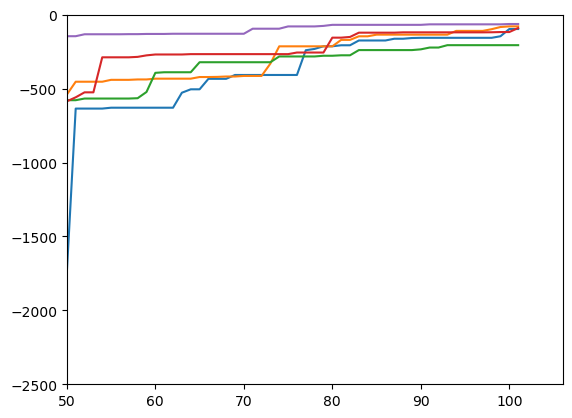

In [52]:
for i in range(nchains):
    plt.plot(D.chains[i].likelihood)
plt.xlim(nburn,)
plt.ylim(-2500,0)

In [72]:
pickle.dump(results, open('../results/dream_results.pkl','wb'))

#### Plot parameter estimates

In [73]:
fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
B = np.loadtxt(fname)[:,1:]
n = int(B.shape[0]/nchains)
A = B.reshape((n, nchains, npars))
B.shape

FileNotFoundError: ../modelfiles/run_pars.dat not found.

In [ ]:
#fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
#B = np.loadtxt(fname)[nburn*nchains:,1:]
#A = B.reshape((minsamp-nburn, nchains, npars))

In [ ]:
for i in range(npars-1,npars):
    for j in range(nchains):
        plt.plot(A[:,j,i], 'o',ms=3)
plt.plot((0, minsamp),(-200, -200), color = 'black', lw = 3)
plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples x chains')
plt.ylabel('control point z (m)')
plt.axvline(nburn)
plt.ylim(-250,0)

In [ ]:
hk_ref = [1, 0.1, 5, 0.1] 
vk_ref = [i/10 for i in hk_ref]
ss_ref = [ 0.00005, 0.00005, 0.00005]

In [ ]:
fig, ax = plt.subplots(4,4, figsize = (10,10))

# Hk
for i in range(4):
    ax = plt.subplot(4,4,i+1)
    ax.hist(A[nburn:,:,i].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(hk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Hk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i], Max[i]])
    if i != 0: ax.set_yticks([])

# Vk        
for i in range(4):
    ax = plt.subplot(4,4,i+5)
    ax.hist(A[nburn:,:,i+4].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(vk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Vk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+4], Max[i+4]])
    if i != 0: ax.set_yticks([])
        
# Sy
ax = plt.subplot(4,4,9)
ax.hist(A[nburn:,:,-2].flatten(), bins=30, range = (0,0.2))
plt.axvline(P.sy[0], color = 'black', lw = 1)
ax.set_xlabel('Sy (Lay 0)')
ax.set_ylabel('Frequency')
ax.set_xlim([0, 0.2])
ax.set_ylim([0,500])

#Ss
for i in range(3):
    ax = plt.subplot(4,4,i+10)
    ax.hist(A[nburn:,:,i+8].flatten(), bins=30, range = (-5,-4))
    plt.axvline(logfunc(ss_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Ss (Lay {i+1})')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+8], Max[i+8]])
    ax.set_yticks([])

# CPz    
ax = plt.subplot(4,4,13)    
ax.hist(A[nburn:,:,-1].flatten(), bins=30, range = (-250,0))
plt.axvline(-200, color = 'black', lw = 1)
ax.set_xlabel('Control Point Z (m)')
ax.set_ylabel('Frequency')
ax.set_xlim([-250,0])

ax = plt.subplot(4,4,14) 
ax.set_axis_off()
ax = plt.subplot(4,4,15) 
ax.set_axis_off()
ax = plt.subplot(4,4,16) 
ax.set_axis_off()
        
plt.subplots_adjust(wspace=0.5)#, hspace=0.1)    
plt.tight_layout()  
fig.savefig('../figures/figure7', dpi=450) 

In [ ]:
meanK = []
meanX = []
meanY = []
meanL = []
meanTheta = []
varK = []
varX = []
varY = []
varL = []
varTheta = []
for i in range(1,np.shape(B)[0]):
    meanK.append(np.mean(B[:i,0]))
    varK.append(np.var(B[:i,0]))
    meanX.append(np.mean(B[:i,1]))
    varX.append(np.var(B[:i,1]))
    meanY.append(np.mean(B[:i,2]))
    varY.append(np.var(B[:i,2]))
    meanL.append(np.mean(B[:i,3]))
    varL.append(np.var(B[:i,3]))
    meanTheta.append(np.mean(B[:i,4]))
    varTheta.append(np.var(B[:i,4]))

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
for k in range(5):
    for j in range(npars-2):
        for i in range(len(A) - nburn):        
            ax.plot(j, A[i][k][j],'o', ms = 2.)

for j in range(npars-2):
    ax.plot(j, Mean[j], 'o', ms = 5., color = 'black')
#ax.set_xlabel('Parameter Number')
ax.set_xticks(np.arange(0,npars-2,1))
ax.set_xticklabels(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3','ss1','ss2','ss3'])
ax.set_ylabel('Log Value')
ax.set_ylim([-5,1.5])

### Compare predictions against reality

In [83]:
# Get times
csv_file = os.path.join(P.workspace, "ref_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365 

csv_file = os.path.join(P.workspace, M.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365 

times = times_past.tolist() + [i +2 for i in times_future.tolist()]

In [85]:
# Load REFERENCE results
fname = '../results/ref_past.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_past = pickle.load(pickleoff)
pickleoff.close()
ref_past = np.array(ref_past)

fname = '../results/ref_future.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_future = pickle.load(pickleoff)
pickleoff.close()
ref_future = np.array(ref_future)

ref_results = np.append(ref_past, ref_future, axis=2)

# Load DREAM results
fname = '../results/dream_results.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
dream_results = pickle.load(pickleoff)
pickleoff.close()
dream_results = np.array(dream_results)

ref_past shape (5, 3, 12)
ref_future shape (5, 3, 30)
ref_resuts shape (5, 3, 42)


### Plot reality vs predicted

In [88]:
# number of ACCEPTED parameter set past/future results, nobs_xy, nobs_z, nts
print('dream_results shape', dream_results.shape)   
print('ref_results shape', ref_results.shape) 

dream_results shape (260, 5, 3, 42)
ref_results shape (5, 3, 42)


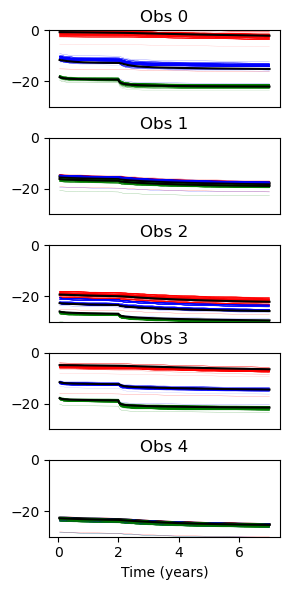

In [94]:
fig = plt.figure(figsize=(3,6))
#plt.suptitle(modelname, size = 14)
colors = ['red', 'blue','green']
for j in range(5):  # OBS in xy
    ax = plt.subplot(5, 1, j+1,aspect='auto')
    ax.set_title('Obs %i' %(j))
        
    for k in range(3): # OBS in z
        for i in range(len(dream_results)): 
            ax.plot(times, dream_results[i, j, k], '-', color = colors[k], alpha = 0.6, lw = 0.1 ) 
        
        ax.plot(times, ref_results[j, k], lw = 1.5, color = 'black')#colors[k]) # Plot truth
    if j == 4: ax.set_xlabel('Time (years)', size = 10)
    if j < 4: ax.set_xticks([])

    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Head (m)', size = 10)
    #ax.axvline(2)
    ax.set_ylim([-30,0])
plt.tight_layout()    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(10,8))

for k in range(3): # OBS in z
    for j in range(5):  # OBS in xy
    
        ax = plt.subplot(3, 5, k * 5 + j + 1,aspect='auto')
        ax.set_title('Obs %i\nz = %im' %(j, P.zobs[j,k]), size = 8)
        ax.hist(obs_future[:, j, k, -1], bins = 5)
        ax.axvline(ref_future[j, k, -1], lw = 1, color = 'black') # Plot truth
        if j == 0: ax.set_ylabel('Frequency', size = 10)
        if k == 2: ax.set_ylabel('Predicted head (m)', size = 10)
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_xlim([ref_future[j, k, -1] - 2, ref_future[j, k,-1] + 2])
        
        ax.set_xticks(ticks=[ref_future[j, k, -1] - 2, ref_future[j, k, -1], ref_future[j, k, -1] + 2], 
                      labels=[str(round(float(ref_future[j, k, -1] - 2),1)), 
                              str(round(float(ref_future[j, k, -1]),1)), 
                              str(round(float(ref_future[j, k, -1] + 2),1)),],
                      size = 8)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)    
plt.tight_layout()  
fig.savefig('../figures/figure8', dpi=450) 
plt.show()

In [ ]:
Scrap Code

In [ ]:
#help(flopy.discretization.StructuredGrid)

#cell2dcar = mgs.get_gridprops_vertexgrid()
#lrc_list = mgs.get_lrc()
#node = mgs.get_node(lrc_list)

#verts = sg.verts
#xycenters = sg.xycenters
#xyzvertices = sg.xyzvertices

def convert_to_disu(mgs, idx, dztol):
    global d2d
    
    delr = mgs.delr
    delc = mgs.delc
    top = mgs.top
    botm = mgs.botm
    key = list(parameters.keys())[idx]
    staggered = parameters[key]['staggered']
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered, dztol=dztol)
    
    return (d2d)

gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(P.x0, P.y0), (P.x0, P.y1)])
cells0 = gi.intersect(line)["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(P.x1, P.y0), (P.x1, P.y1)])
cells1 = gi.intersect(line)["cellids"]
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell
for i in P.xypumpbores:
    point = Point((i[0], i[1]))
cells2 = gi.intersect(point)["cellids"]
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd, alpha = 0.6)
    vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
'''from flopy.export import vtk
from pathlib import Path
from tempfile import TemporaryDirectory

nam_file = "CV.nam"
ml = flopy.modflow.Modflow.load(nam_file, model_ws=P.workspace, check=False)

tempdir = TemporaryDirectory()
workspace = Path(tempdir.name)

output_dir = workspace / "arrays_test"
output_dir.mkdir(exist_ok=True)

output_dir'''

In [ ]:
# Plot observations
colors = ['black', 'red', 'green', 'purple', 'orange']
marker_styles = ['s', 's', 's', 'o', 'o', 'o'] #['s', '^', 'p', 's', '^', 'p']    
line_styles = ['dashed', 'dashed','dashed','dotted', 'dotted','dotted','solid']  
fill_color = ['red', 'green', 'purple', 'white', 'white', 'white']
#modelnames = [M.modelname for M in models]

 
#---------- STEADY -------------
models = [M]
fig = plt.figure(figsize = (12,3))
fig.suptitle('Steady state heads')
    
for ob in range(P.nobs): # New figure for each obs bore (OB1, OB2, OB3, OB4)
    ax = plt.subplot(1,5,ob+1)#, aspect = 'equal')
    ax.set_title(P.idobsbores[ob], size = 10) 

    for i, model in enumerate(models): # colored line for each model
        for z in range(len(P.zobs)): # New figure for each obs bore (OB1, OB2, OB3, OB4)
            ax.plot(z, model.hobs_steady[ob,z][0], 'o', c = colors[i],#, marker = marker_styles[i], s = 20,)
                    label = M.modelname)
    
    #ax.set_xlim([10,30])
    ax.set_ylabel('Obs Depth (m)')
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(P.zobs)
    ax.set_ylim([-20,10])
    if ob > 0: ax.set_yticks([])
    #ax.set_yticks([30, 40, 50, 60])
    if ob == 0: ax.set_ylabel('Head (m)')
    
            
handles, labels = plt.gca().get_legend_handles_labels()
ax = plt.subplot(1,5,5, aspect = 'equal')
ax.set_axis_off()
ax.legend(handles=handles)
plt.show()

In [ ]:
#for attribute, value in M.__dict__.items(): print(attribute)

In [ ]:
"""workspace = 'vtk_files'
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

model_output_dir = os.path.join(workspace, "model_output_test")
M.gwf.export(model_output_dir, fmt="vtk")

from flopy.export import vtk
fname = '{}.hds'.format(M.modelname)
print(os.path.join(P.workspace, fname))
hds = flopy.utils.binaryfile.HeadFile(os.path.join(P.workspace, fname))  


vtkobj = vtk.Vtk(M.gwf, xml=True, pvd=True, vertical_exageration=2)
vtkobj.add_heads(hds)
vtkobj.write(os.path.join(workspace, "heads_output_test", "KW.vtu"))"""